In [18]:
from evaluation import regression_evaluator
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [19]:
def partition(data, play_type="pass"):
    return data[data['play_type'] == play_type].drop('play_type', axis=1)

In [20]:
data = pd.read_csv("fourth_down_dataset.csv")
print(data['play_type'].value_counts())


passing = partition(data,'pass')
run = partition(data,'run')
fg = partition(data,'field_goal')
punt = partition(data,'punt')

partitioned_dataset = [("run", run) , 
                       ("pass", passing), 
                       ("fg", fg), ("punt", punt)]

play_type
punt          13390
field_goal     5762
pass           2694
run            1608
no_play        1364
qb_kneel         20
Name: count, dtype: int64


In [29]:
y = run['wpa_avg'].to_numpy()
X = run.drop('wpa_avg', axis=1)
cols = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xg = xgb.XGBRegressor(objective='reg:squarederror')
sel_xg = SelectFromModel(xg, threshold='median')
sel_xg.fit(X_train, y_train)

cols = X_train.columns[(sel_xg.get_support())]

X_train_sel, X_test_sel = X_train[cols], X_test[cols]
re = regression_evaluator(col_names=cols)

In [92]:
params = {'colsample_bytree': 0.6609327156875529, 
          'eta': 0.06785747672769736, 
          'gamma': 0.0010918143411478261, 
          'huber_slope': 0.9194156689003281, 
          'max_depth': 9, 'min_child_weight': 7.0, 
          'reg_alpha': 0.35779564693698374, 
          'reg_lambda': 2.51437281780092}

model = xgb.XGBRegressor(**params)
model.fit(X_train_sel, y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:31:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "huber_slope" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6609327156875529, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.06785747672769736, eval_metric=None, feature_types=None,
             gamma=0.0010918143411478261, grow_policy=None,
             huber_slope=0.9194156689003281, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=7.0, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None, ...)

Evaluation for XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6609327156875529, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.06785747672769736, eval_metric=None, feature_types=None,
             gamma=0.0010918143411478261, grow_policy=None,
             huber_slope=0.9194156689003281, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=7.0, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None, ...) (Train)
Max Error: 0.3718077718769074
Mean Absolute Error: 0.019009423159818243
Mean Squared Error: 0.0009722148409029256
Root Mean Squared Error: 0.031180359858457785
R-Squared: 0.715

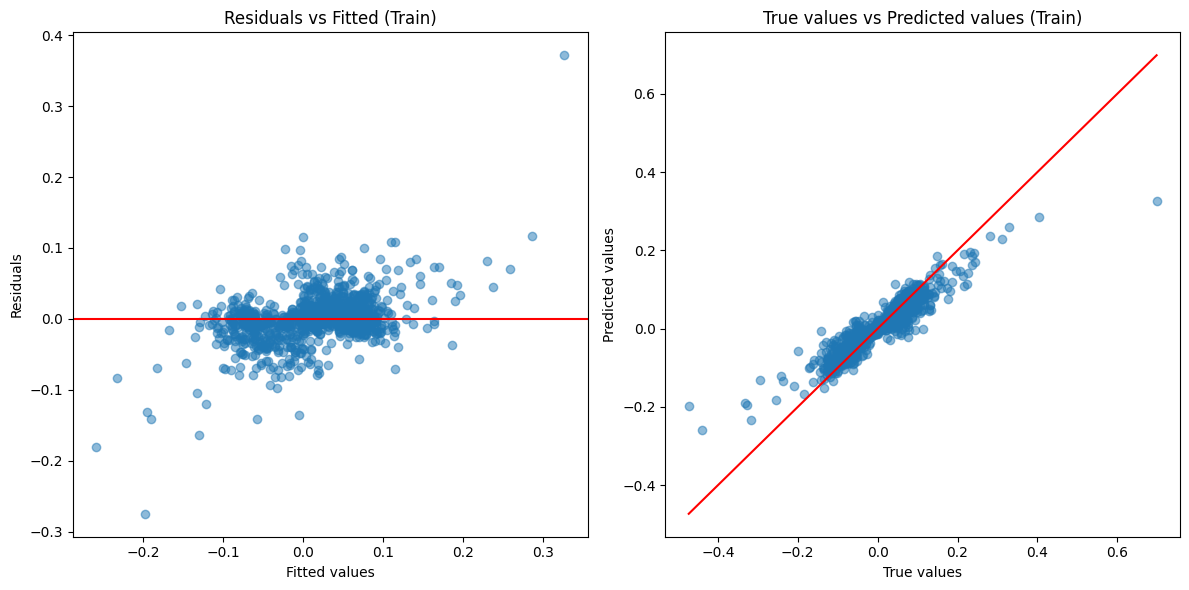

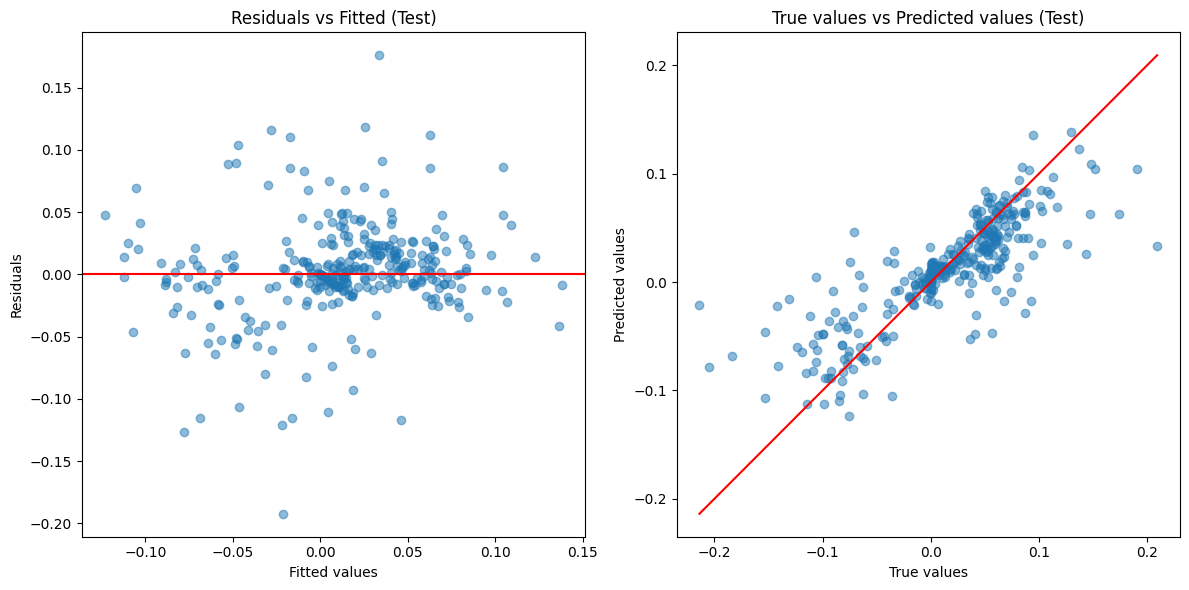

In [82]:
re.evaluate(model, X_train_sel, X_test_sel, y_train, y_test)

In [73]:
import time
import random

def random_num():
    num = random.randint(0,round(time.time() * 1000))
    return num
random_num()

447170260176

Evaluation for RandomForestRegressor(max_depth=10, random_state=42) (Train)
Max Error: 0.2372899399027138
Mean Absolute Error: 0.016514821678517467
Mean Squared Error: 0.0007929413246511475
Root Mean Squared Error: 0.02815921385001981
R-Squared: 0.7747883561029618
Mean Squared Error for +wpa: 0.0005425104745305046
Mean Squared Error for -wpa: 0.0013148224008018396
Regression Accuracy: 0.9409020217729394
----------------------------
Evaluation for RandomForestRegressor(max_depth=10, random_state=42) (Test)
Max Error: 0.2559608123169169
Mean Absolute Error: 0.02644458143397246
Mean Squared Error: 0.0018530735699957377
Root Mean Squared Error: 0.043047341032818015
R-Squared: 0.1631597172717424
Mean Squared Error for +wpa: 0.0013019593510257203
Mean Squared Error for -wpa: 0.003008293759759813
Regression Accuracy: 0.8726708074534162
----------------------------
Feature Importances for RandomForestRegressor(max_depth=10, random_state=42)
posteam_rush_epa_per_sec: 0.16868148261549232
game_se

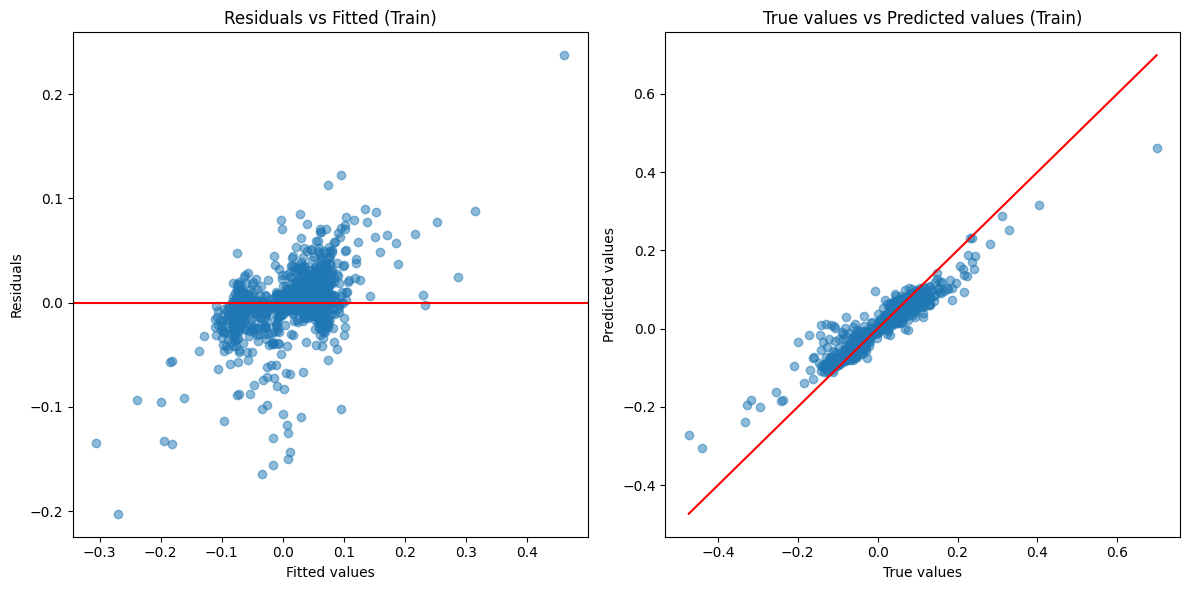

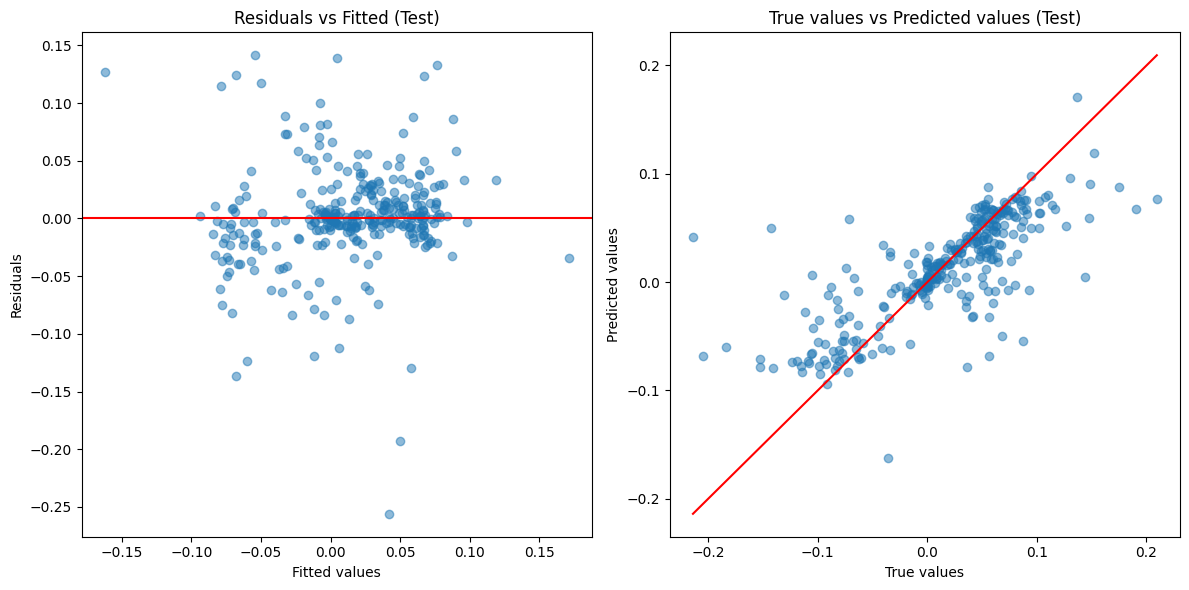

In [96]:
rf = RandomForestRegressor(n_estimators=1000, max_depth=10, random_state=42) 
rf.fit(X_train_sel, y_train)

re.evaluate(rf, X_train_sel, X_test_sel, y_train, y_test)

In [97]:
individual_preds = np.array([tree.predict(X_test_sel) for tree in rf.estimators_])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeRegre

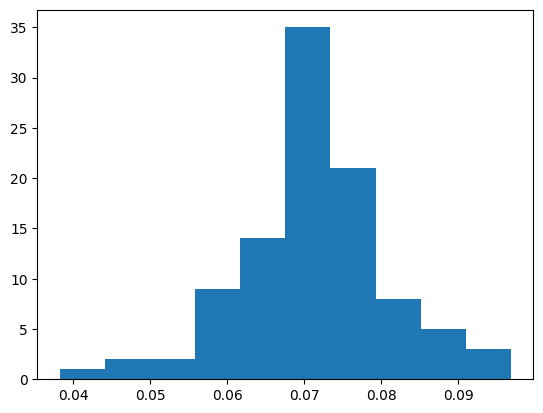

0.049968444
Minimum: 0.03823203929881864
Q1 (First Quartile): 0.06699523510347703
Median: 0.0710252353112639
Q3 (Third Quartile): 0.07604864948276871
Maximum: 0.0968389329272727
True
--------------------------


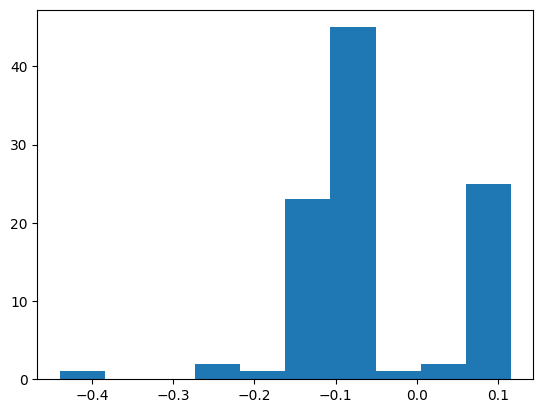

0.08739803
Minimum: -0.4397846
Q1 (First Quartile): -0.1076018
Median: -0.08164966
Q3 (Third Quartile): 0.050605893984329894
Maximum: 0.11599255409375
True
--------------------------


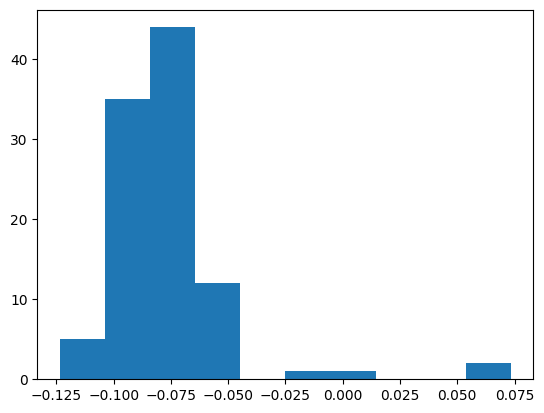

-0.08219607
Minimum: -0.123465877
Q1 (First Quartile): -0.09206449124999999
Median: -0.07862894871621622
Q3 (Third Quartile): -0.06821900661537349
Maximum: 0.07334916579999999
True
--------------------------


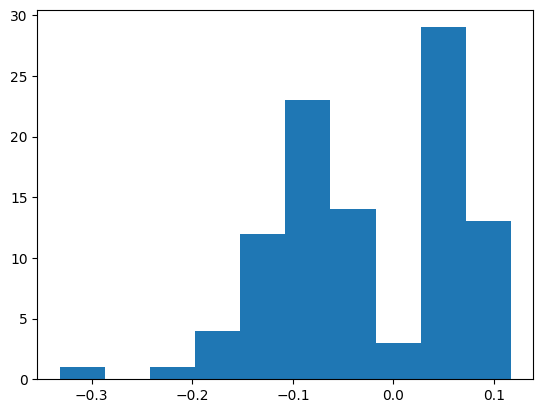

-0.1119097
Minimum: -0.33154798
Q1 (First Quartile): -0.09128728795454545
Median: -0.04947719
Q3 (Third Quartile): 0.05347985469551282
Maximum: 0.11657813
True
--------------------------


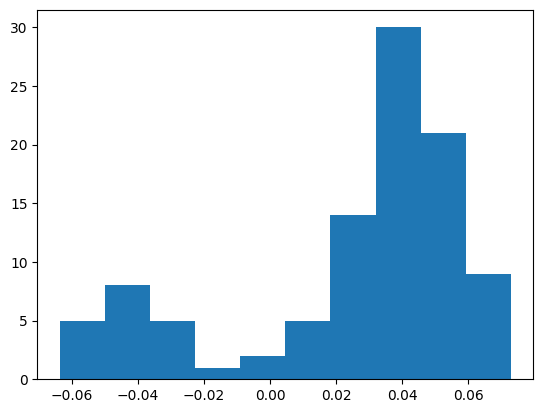

-0.034134973
Minimum: -0.063635804
Q1 (First Quartile): 0.015510980328688678
Median: 0.03669045671505376
Q3 (Third Quartile): 0.04740746624890351
Maximum: 0.07287641073333333
True
--------------------------


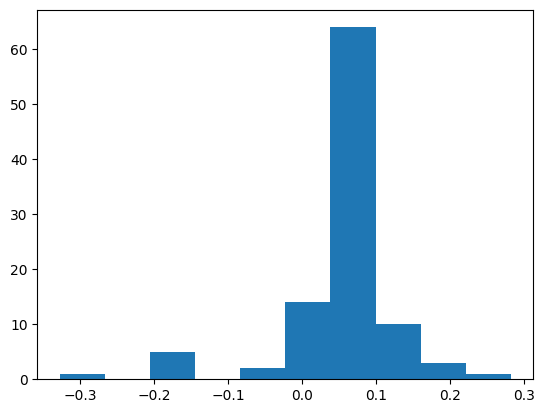

0.056373104
Minimum: -0.327262
Q1 (First Quartile): 0.0464706242343299
Median: 0.07006831131643357
Q3 (Third Quartile): 0.08551783661101399
Maximum: 0.28255415
True
--------------------------


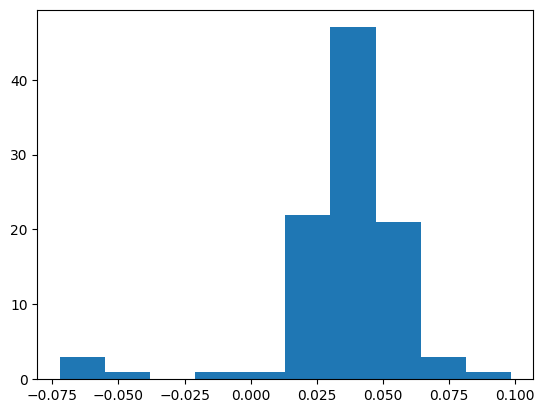

0.06705302
Minimum: -0.07212832290909091
Q1 (First Quartile): 0.02918154771369048
Median: 0.036093589467827626
Q3 (Third Quartile): 0.04694105865294461
Maximum: 0.09832344977419356
True
--------------------------


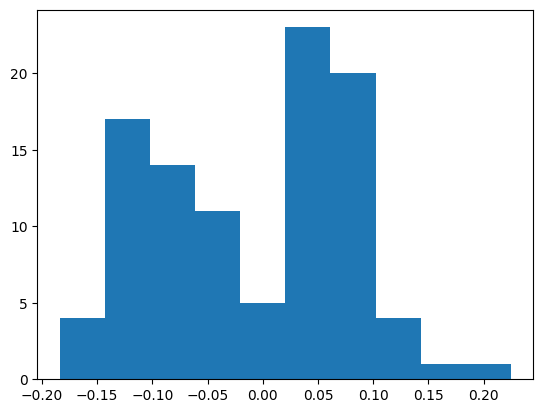

-0.13127978
Minimum: -0.18358667
Q1 (First Quartile): -0.08002681
Median: 0.0070811998724551704
Q3 (Third Quartile): 0.06192887117391304
Maximum: 0.22448586
True
--------------------------


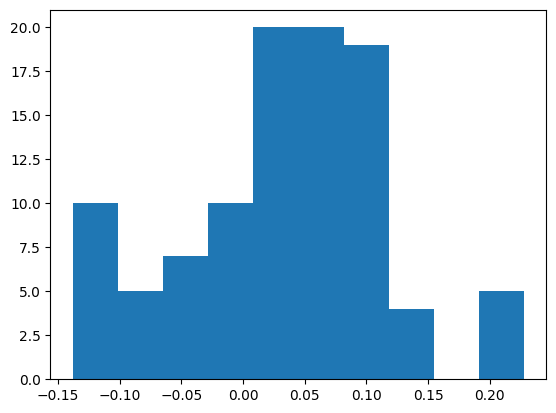

0.04654804
Minimum: -0.137808
Q1 (First Quartile): -7.829688194825e-05
Median: 0.042692495161387636
Q3 (Third Quartile): 0.09076341813636363
Maximum: 0.22756333999999998
True
--------------------------


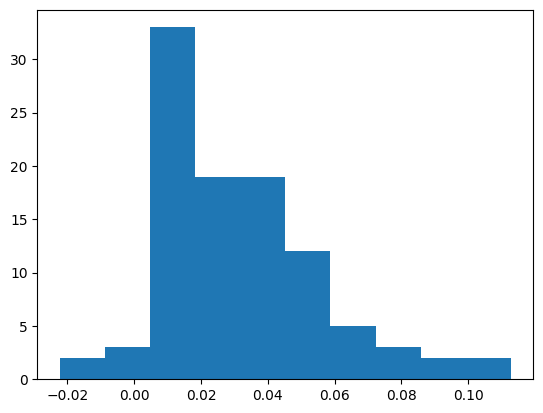

0.017913127
Minimum: -0.02224482
Q1 (First Quartile): 0.013566471232102272
Median: 0.0264148155
Q3 (Third Quartile): 0.04402778564237968
Maximum: 0.112721265
True
--------------------------


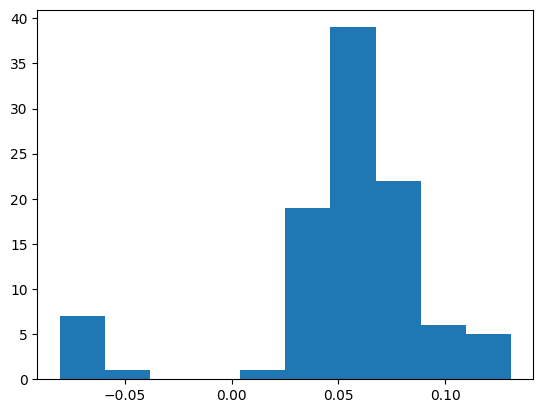

0.07024829
Minimum: -0.08045356
Q1 (First Quartile): 0.04500383028763441
Median: 0.0604511390494253
Q3 (Third Quartile): 0.07127934990000001
Maximum: 0.13080737
True
--------------------------


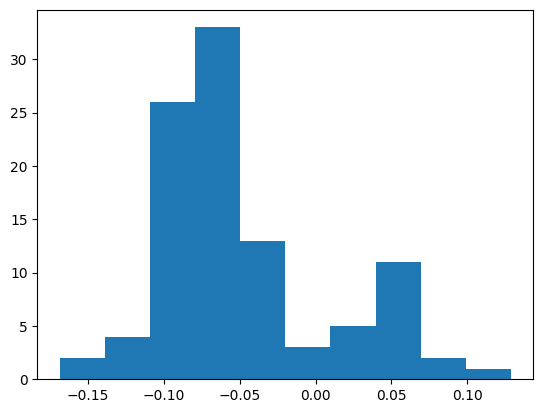

-0.07640572
Minimum: -0.16863105
Q1 (First Quartile): -0.08358918010119047
Median: -0.07089803474242423
Q3 (Third Quartile): -0.026820767477272727
Maximum: 0.12866214
True
--------------------------


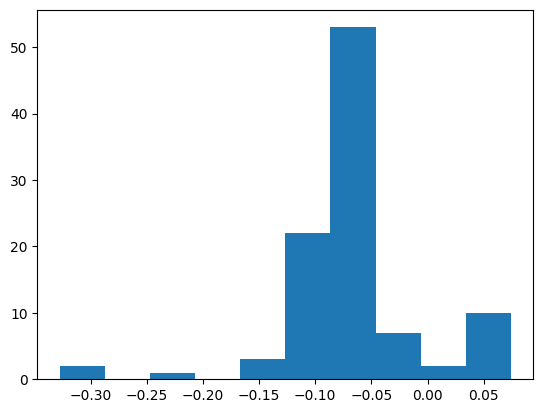

-0.0608501
Minimum: -0.327262
Q1 (First Quartile): -0.08868692926785715
Median: -0.07711987249999999
Q3 (Third Quartile): -0.06575451741666666
Maximum: 0.074146494
True
--------------------------


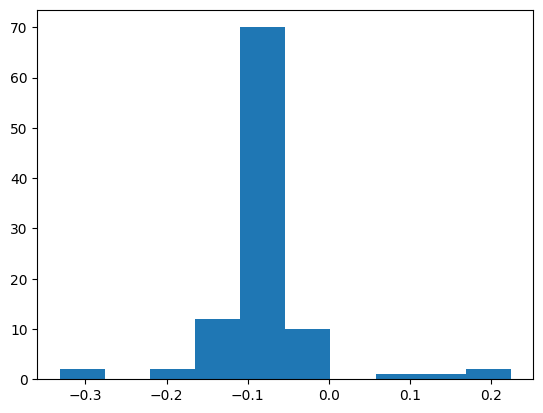

-0.15311721
Minimum: -0.33154798
Q1 (First Quartile): -0.09028345498511905
Median: -0.07741836545454546
Q3 (Third Quartile): -0.06588686138991046
Maximum: 0.22448586
True
--------------------------


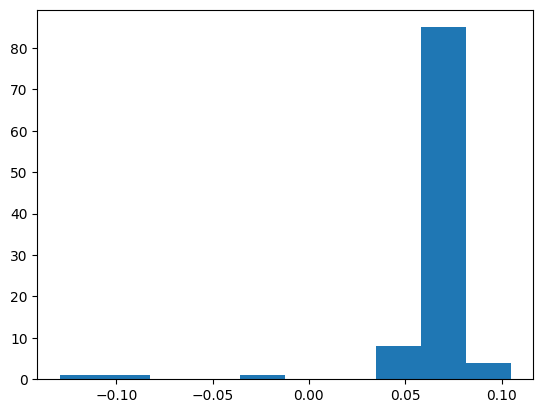

0.0633807
Minimum: -0.12928255
Q1 (First Quartile): 0.06123445385159708
Median: 0.06623463904217693
Q3 (Third Quartile): 0.0719805517571364
Maximum: 0.10481254425
True
--------------------------


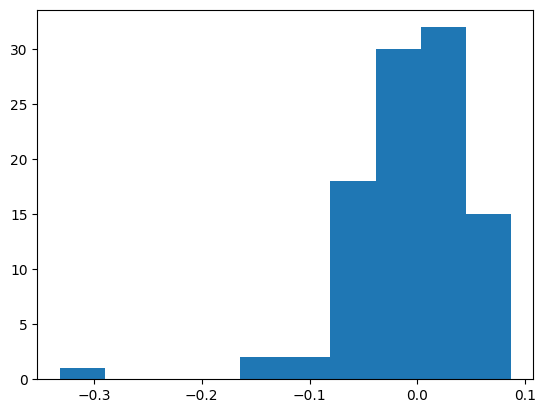

-0.024840467
Minimum: -0.33154798
Q1 (First Quartile): -0.031903885
Median: 0.0005046831607464999
Q3 (Third Quartile): 0.038267
Maximum: 0.08662616
True
--------------------------


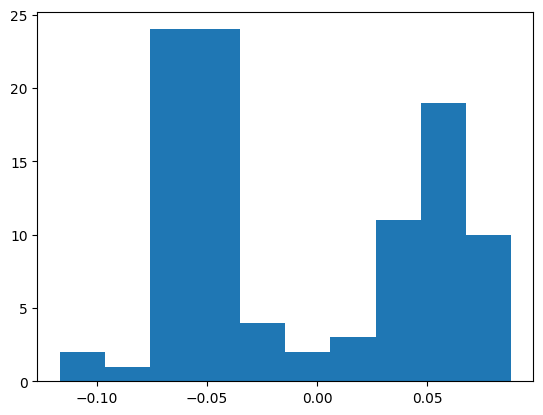

-0.06299862
Minimum: -0.116910934
Q1 (First Quartile): -0.05709
Median: -0.03965394
Q3 (Third Quartile): 0.05272157859375
Maximum: 0.08799088
True
--------------------------


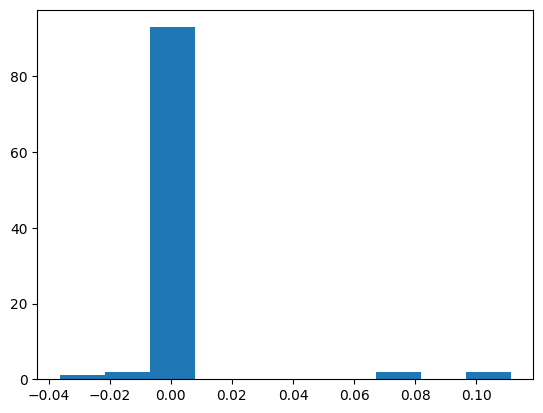

6.46253e-06
Minimum: -0.03627918
Q1 (First Quartile): -0.000644477683226223
Median: -6.066164229771929e-05
Q3 (Third Quartile): 1.2429603603977272e-05
Maximum: 0.11125433
True
--------------------------


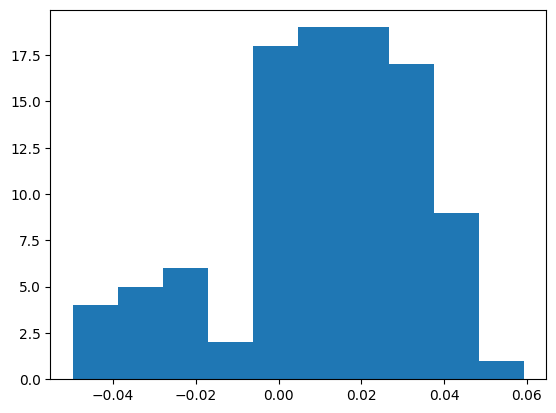

0.012190954
Minimum: -0.049697787
Q1 (First Quartile): -0.0005399631358341605
Median: 0.01401032306818182
Q3 (Third Quartile): 0.0271946855625
Maximum: 0.05928972735
True
--------------------------


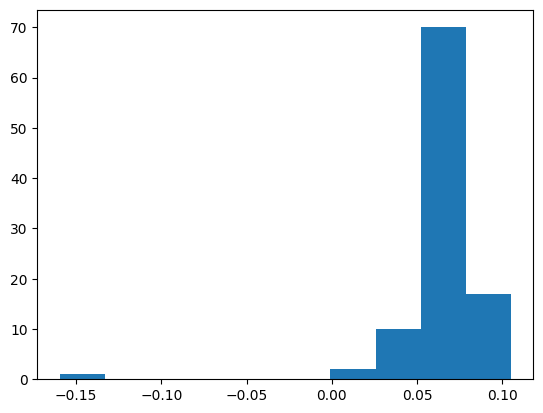

0.07681809
Minimum: -0.159467468
Q1 (First Quartile): 0.06006298743392857
Median: 0.06750251061439666
Q3 (Third Quartile): 0.0753036926150064
Maximum: 0.10489408734722223
True
--------------------------


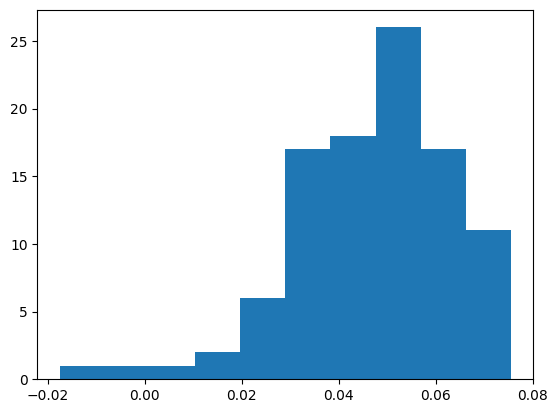

0.06177427
Minimum: -0.017474077625
Q1 (First Quartile): 0.03805561281870172
Median: 0.050087817743973764
Q3 (Third Quartile): 0.05857195161634887
Maximum: 0.07548029
True
--------------------------


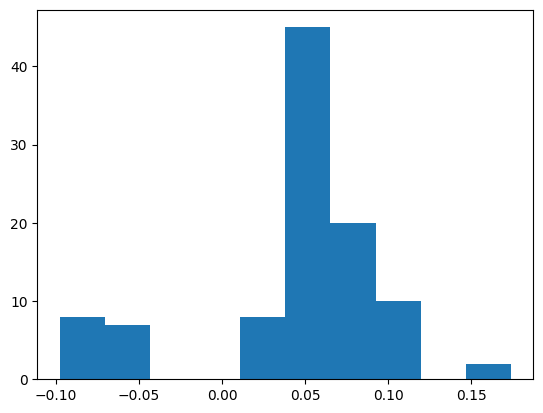

0.07859838
Minimum: -0.09750521
Q1 (First Quartile): 0.04109362373424797
Median: 0.05524987605016026
Q3 (Third Quartile): 0.07153665726564198
Maximum: 0.17377096
True
--------------------------


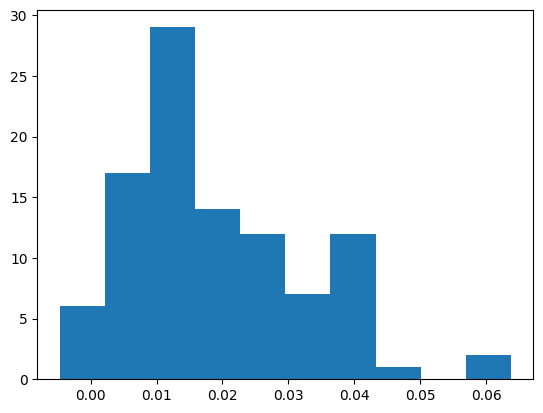

0.01673209
Minimum: -0.004652341002255814
Q1 (First Quartile): 0.009903133546628778
Median: 0.01557201948452381
Q3 (Third Quartile): 0.02776878330302431
Maximum: 0.06372067147058824
True
--------------------------


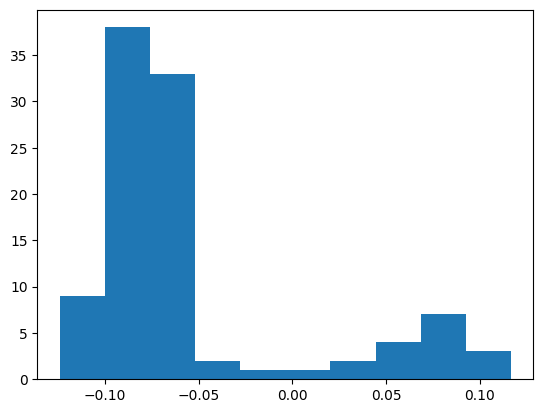

-0.07782461
Minimum: -0.124031425
Q1 (First Quartile): -0.08421390250735293
Median: -0.07416897187550303
Q3 (Third Quartile): -0.060174083044642855
Maximum: 0.11657813
True
--------------------------


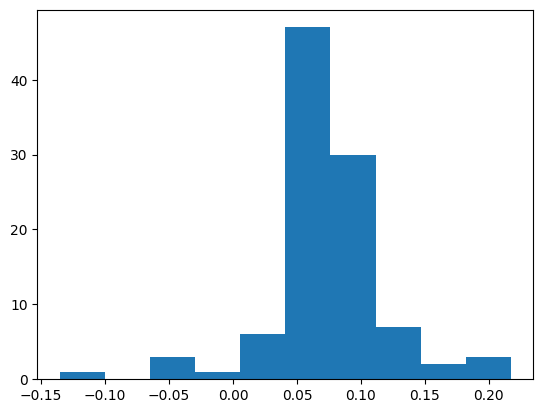

0.052566916
Minimum: -0.13535455
Q1 (First Quartile): 0.05934519529965157
Median: 0.07209793388145742
Q3 (Third Quartile): 0.08674534736111111
Maximum: 0.21714658
True
--------------------------


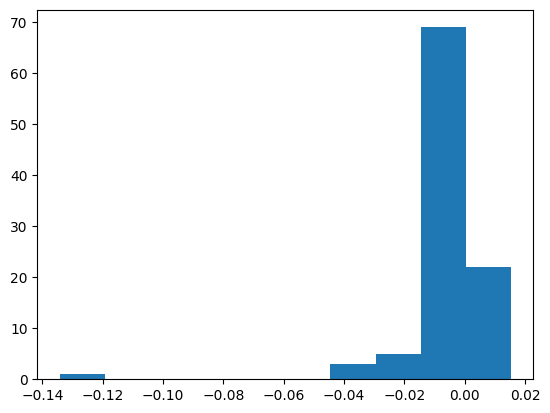

-0.013472158
Minimum: -0.1341429
Q1 (First Quartile): -0.006513326159374999
Median: -0.0009263004455555557
Q3 (Third Quartile): 1.5707036508928568e-05
Maximum: 0.015312104
True
--------------------------


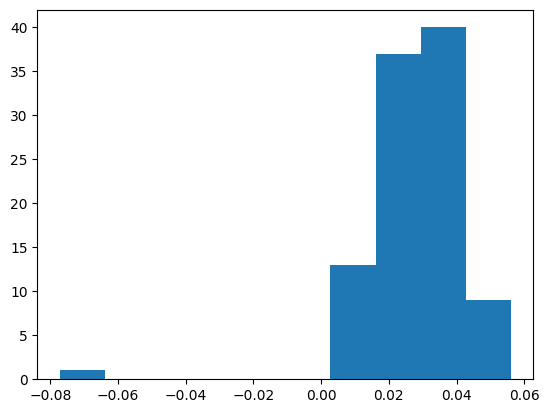

0.030708792
Minimum: -0.07715576685714286
Q1 (First Quartile): 0.024730741845942976
Median: 0.02929528823968254
Q3 (Third Quartile): 0.03517083432826923
Maximum: 0.05603335
True
--------------------------


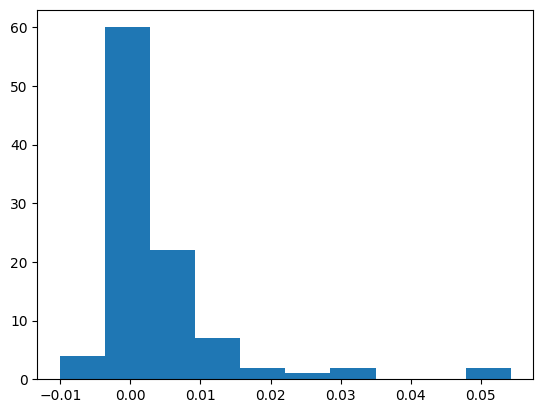

0.00020253658
Minimum: -0.010052016924857144
Q1 (First Quartile): 0.000266781970506746
Median: 0.0014352140604199138
Q3 (Third Quartile): 0.004136857758242139
Maximum: 0.054288596
True
--------------------------


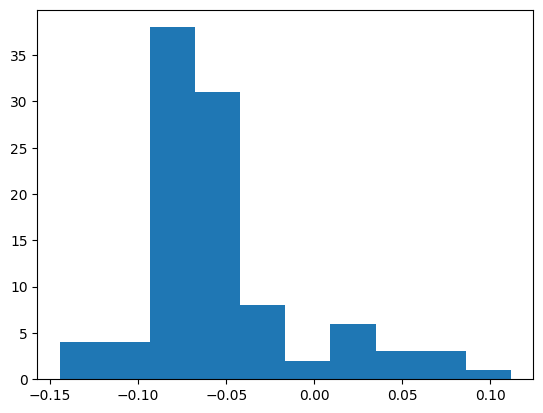

-0.067423485
Minimum: -0.14449838277777777
Q1 (First Quartile): -0.07690015420933015
Median: -0.06457362754578756
Q3 (Third Quartile): -0.04825063217857143
Maximum: 0.111742504
True
--------------------------


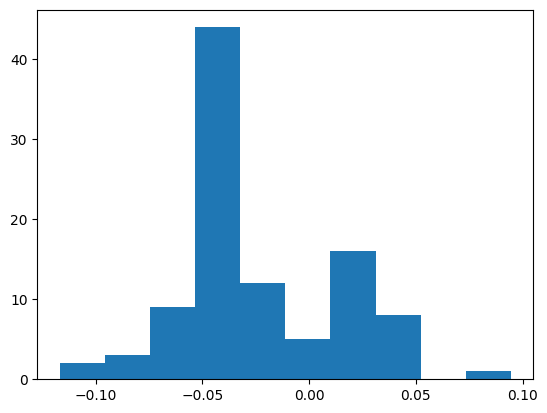

-0.039801136
Minimum: -0.11680281
Q1 (First Quartile): -0.044187702
Median: -0.03627918
Q3 (Third Quartile): 0.009396992
Maximum: 0.09448922
True
--------------------------


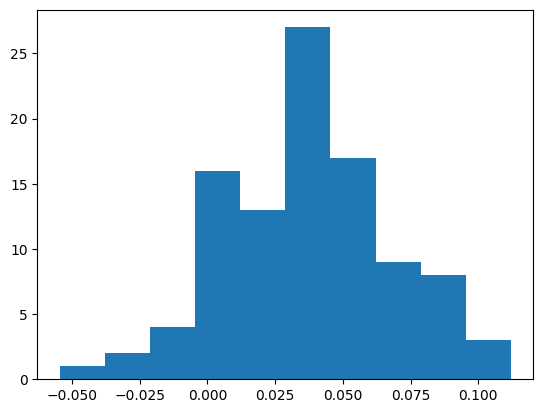

0.029481491
Minimum: -0.05448193
Q1 (First Quartile): 0.014164058450432693
Median: 0.038697255
Q3 (Third Quartile): 0.056895645666
Maximum: 0.1120031720828
True
--------------------------


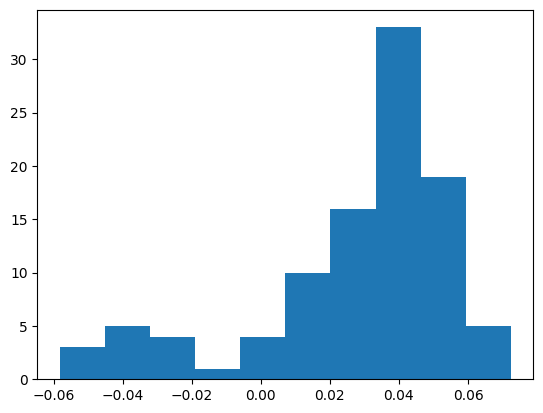

0.026278457
Minimum: -0.0581515
Q1 (First Quartile): 0.017962717675000003
Median: 0.03545946
Q3 (Third Quartile): 0.04610458053846154
Maximum: 0.0723904
True
--------------------------


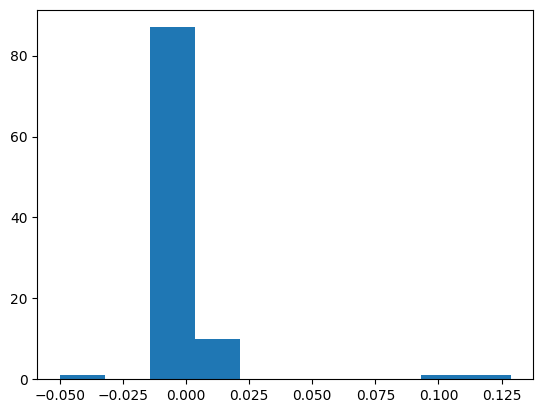

0.0011189282
Minimum: -0.04994297
Q1 (First Quartile): -0.0004053286
Median: 7.157250406666667e-05
Q3 (Third Quartile): 0.0015536845
Maximum: 0.12866214
True
--------------------------


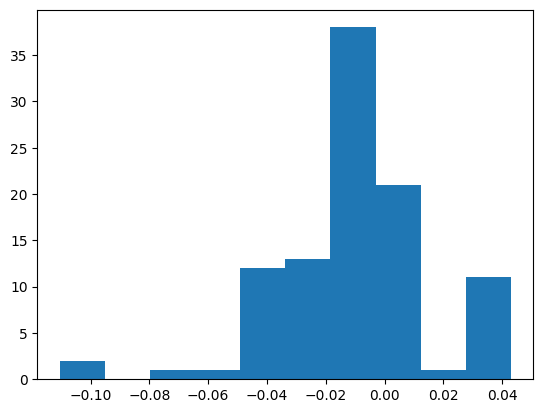

-0.013685145
Minimum: -0.11046974
Q1 (First Quartile): -0.02023924725
Median: -0.009409506
Q3 (Third Quartile): -0.00019586585718143383
Maximum: 0.042979497
True
--------------------------


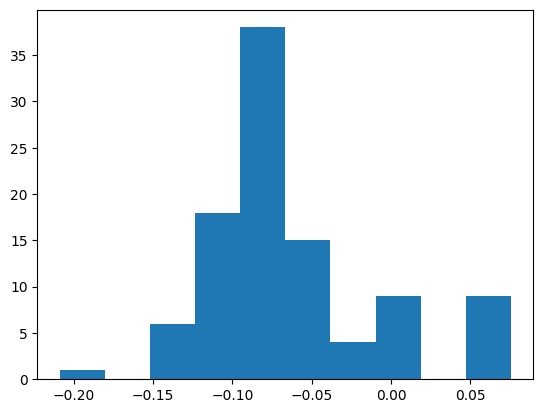

-0.06497002
Minimum: -0.2088615
Q1 (First Quartile): -0.09345745961923077
Median: -0.07654858930952381
Q3 (Third Quartile): -0.046013415
Maximum: 0.07553321
True
--------------------------


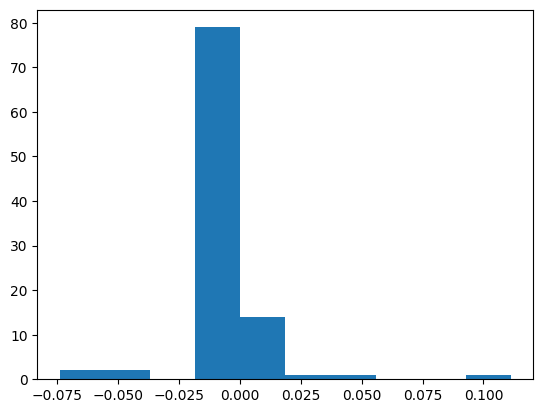

0.00011882186
Minimum: -0.07390368
Q1 (First Quartile): -0.0012353189642666665
Median: -0.00011553952666666666
Q3 (Third Quartile): 3.2130341892857144e-05
Maximum: 0.11125433
True
--------------------------


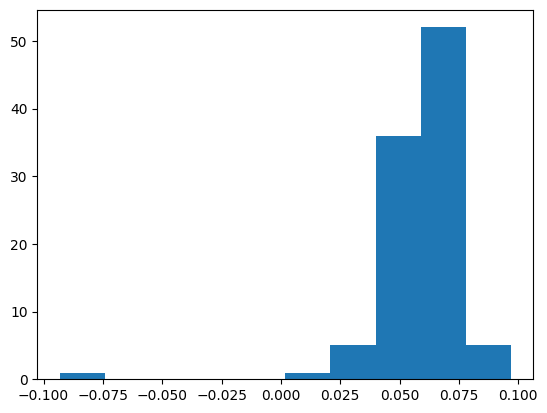

0.05867192
Minimum: -0.09310900933333334
Q1 (First Quartile): 0.050413053748629116
Median: 0.06120852681942643
Q3 (Third Quartile): 0.06888644060808397
Maximum: 0.096873622
True
--------------------------


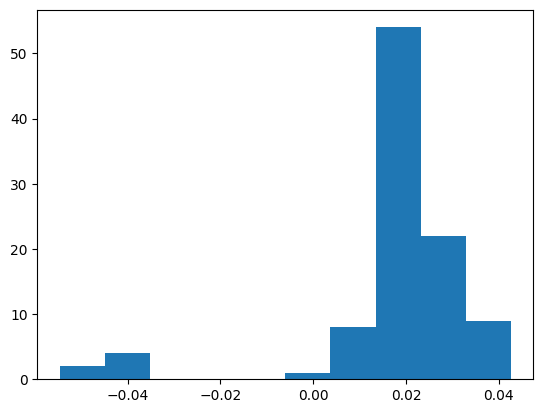

0.020465523
Minimum: -0.054602765
Q1 (First Quartile): 0.01657113776532091
Median: 0.019003450916666664
Q3 (Third Quartile): 0.02491962278541666
Maximum: 0.04259444557142857
True
--------------------------


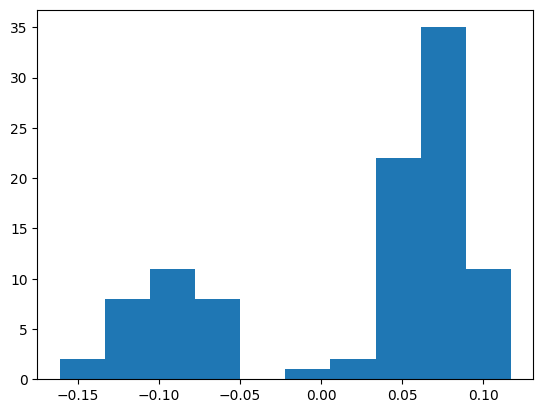

0.04722902
Minimum: -0.161112
Q1 (First Quartile): -0.0681659445234375
Median: 0.0588016855
Q3 (Third Quartile): 0.07292779402499999
Maximum: 0.11687196
True
--------------------------


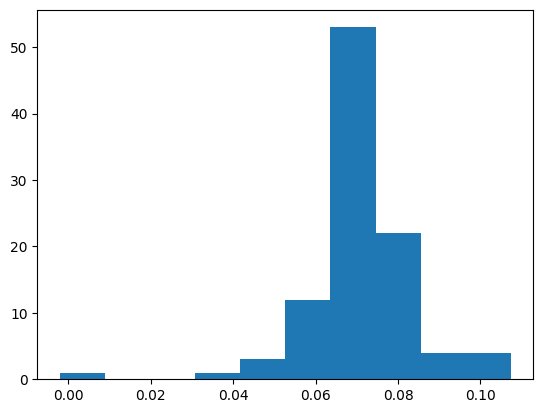

0.08503011
Minimum: -0.002041157846153843
Q1 (First Quartile): 0.06554599319429347
Median: 0.07128675485036295
Q3 (Third Quartile): 0.07582843024586323
Maximum: 0.107355098
True
--------------------------


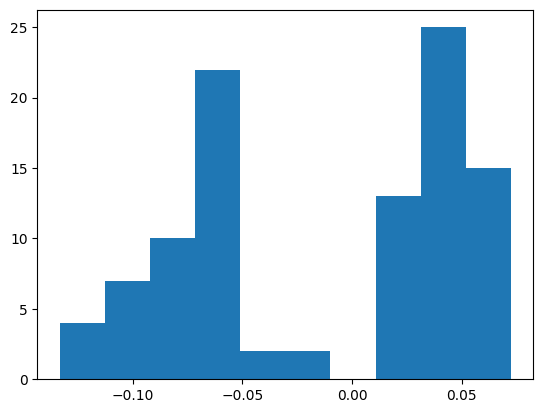

0.03831897
Minimum: -0.1331401
Q1 (First Quartile): -0.06827449
Median: 0.025705119599537668
Q3 (Third Quartile): 0.04473263346875
Maximum: 0.0723904
True
--------------------------


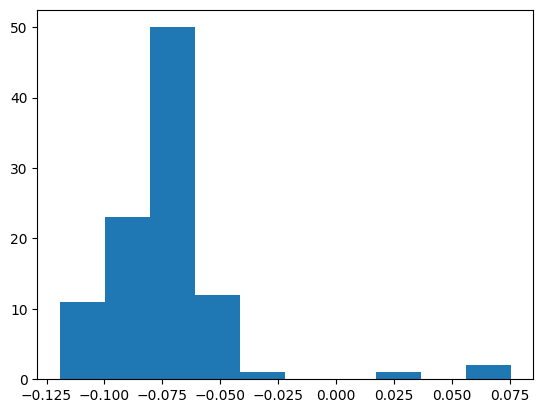

-0.08093174
Minimum: -0.11923580125000001
Q1 (First Quartile): -0.08651996488095237
Median: -0.07320216529029606
Q3 (Third Quartile): -0.06538253556691895
Maximum: 0.07553321
True
--------------------------


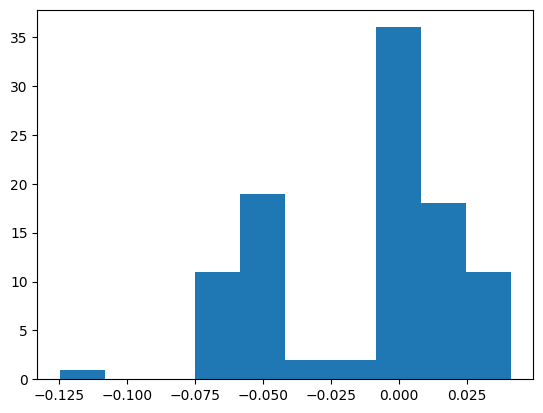

0.030889958
Minimum: -0.12480098
Q1 (First Quartile): -0.05089905
Median: 0.0023077743460033183
Q3 (Third Quartile): 0.009433947372380952
Maximum: 0.041190416
True
--------------------------


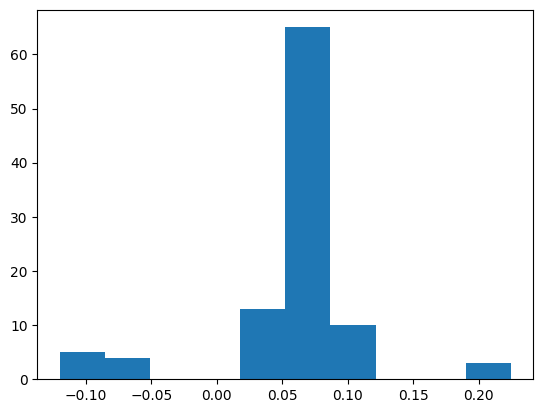

0.050308317
Minimum: -0.11989467333333333
Q1 (First Quartile): 0.05425135754411765
Median: 0.060661118461038964
Q3 (Third Quartile): 0.0767116343
Maximum: 0.22448586
True
--------------------------


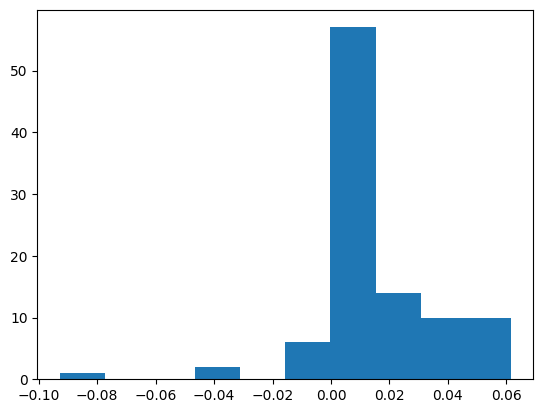

0.0030616708
Minimum: -0.092760086
Q1 (First Quartile): 0.0027189692552144736
Median: 0.008636517777142857
Q3 (Third Quartile): 0.024243923251719146
Maximum: 0.06151038
True
--------------------------


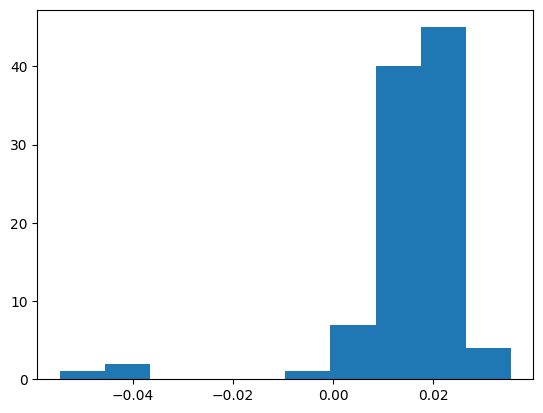

0.006283462
Minimum: -0.054602765
Q1 (First Quartile): 0.013375672218749999
Median: 0.01719154798489011
Q3 (Third Quartile): 0.019199553783248082
Maximum: 0.0354770431519084
True
--------------------------


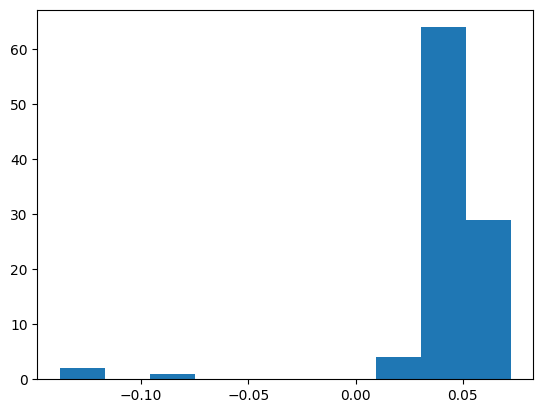

0.043980718
Minimum: -0.137808
Q1 (First Quartile): 0.039830177083333335
Median: 0.04631026701700658
Q3 (Third Quartile): 0.05194806998658731
Maximum: 0.07239344903913042
True
--------------------------


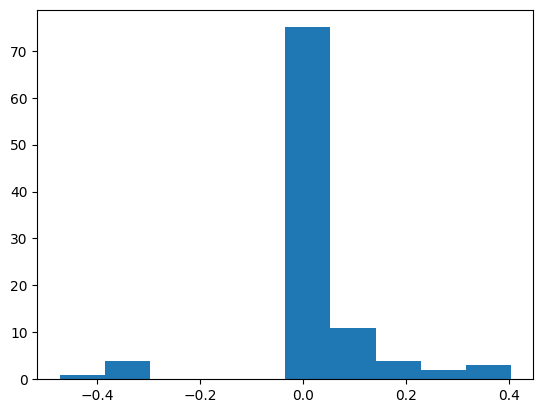

-0.0009495523
Minimum: -0.47288948
Q1 (First Quartile): -4.285589776617647e-05
Median: 0.003172222016518571
Q3 (Third Quartile): 0.02888324305357143
Maximum: 0.40301746
True
--------------------------


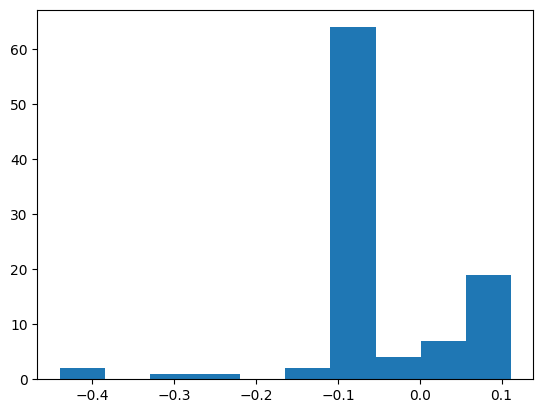

0.0679358
Minimum: -0.4397846
Q1 (First Quartile): -0.08122198151190475
Median: -0.06831661493051243
Q3 (Third Quartile): 0.01732390025
Maximum: 0.11125433
True
--------------------------


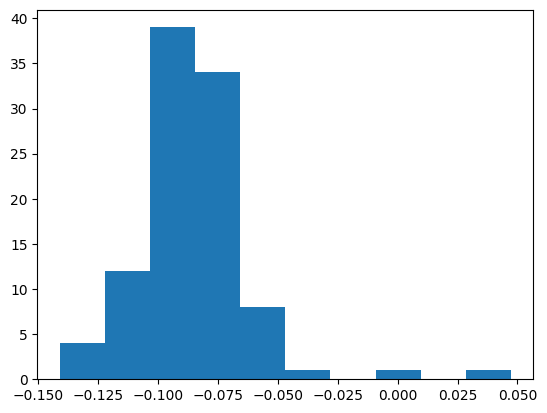

-0.09790693
Minimum: -0.14100335125
Q1 (First Quartile): -0.0966716950467742
Median: -0.08631285653991597
Q3 (Third Quartile): -0.07193329162165776
Maximum: 0.04722847
True
--------------------------


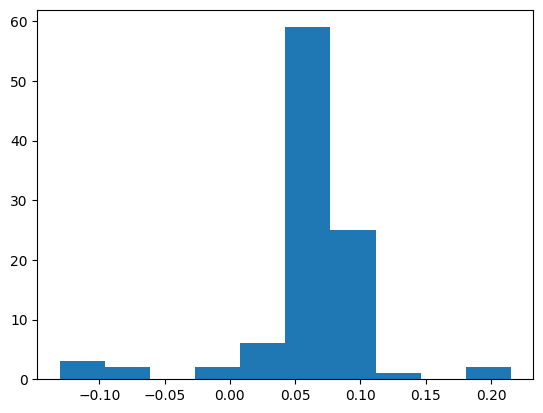

0.102494195
Minimum: -0.13019139
Q1 (First Quartile): 0.06399927983350563
Median: 0.07134469644963129
Q3 (Third Quartile): 0.07782082891482538
Maximum: 0.21515149
True
--------------------------


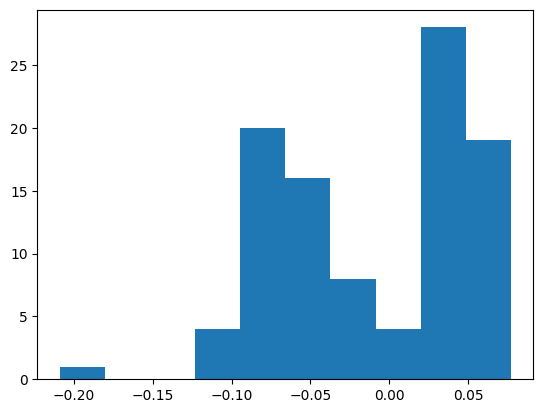

-0.090556934
Minimum: -0.2088615
Q1 (First Quartile): -0.0639588018046875
Median: -0.0026050001011279074
Q3 (Third Quartile): 0.04167195154100051
Maximum: 0.07710283714285714
True
--------------------------


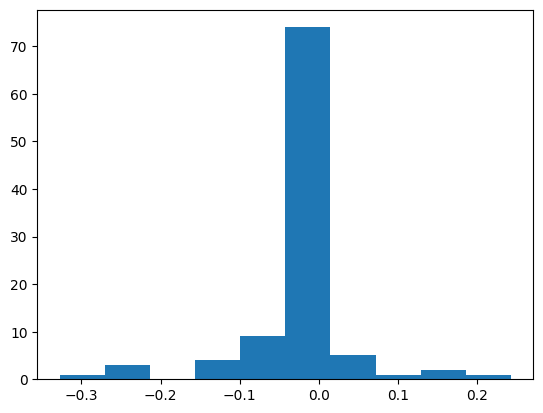

-0.0020988272
Minimum: -0.327262
Q1 (First Quartile): -0.009157917741666667
Median: 0.00015321244973809524
Q3 (Third Quartile): 0.0016319198587579175
Maximum: 0.24306695
True
--------------------------


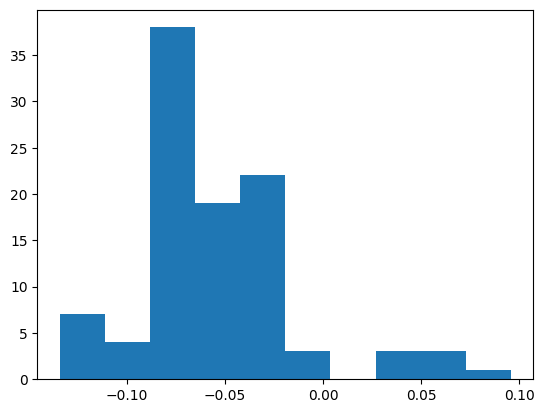

-0.0587008
Minimum: -0.1341429
Q1 (First Quartile): -0.07881915914204546
Median: -0.06382766597619047
Q3 (Third Quartile): -0.03687642
Maximum: 0.09565875
True
--------------------------


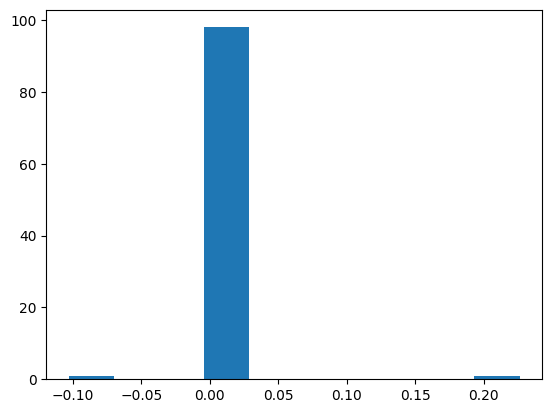

4.0961386e-05
Minimum: -0.103168815
Q1 (First Quartile): 0.0004443346723361111
Median: 0.0012326373172222222
Q3 (Third Quartile): 0.0031557077227178034
Maximum: 0.22618708
True
--------------------------


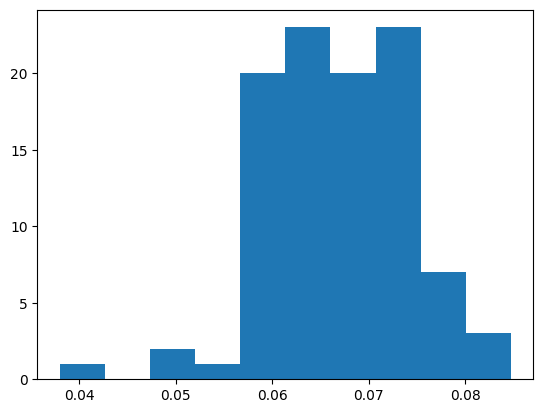

0.08684778
Minimum: 0.03798341112043796
Q1 (First Quartile): 0.06183867212403043
Median: 0.06623463904217693
Q3 (Third Quartile): 0.07152872034006885
Maximum: 0.08472012003999999
False
--------------------------


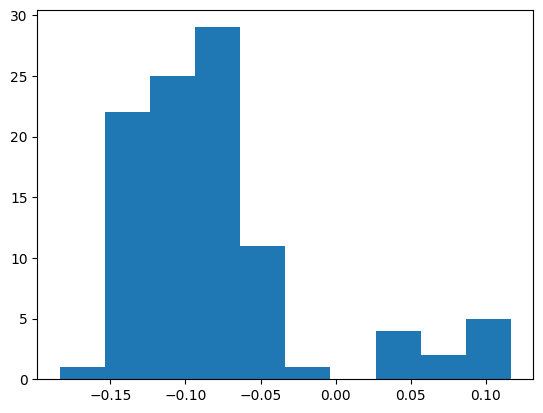

-0.09855084
Minimum: -0.18358667
Q1 (First Quartile): -0.11469126606818181
Median: -0.08906521233636364
Q3 (Third Quartile): -0.06669985268833334
Maximum: 0.11657813
True
--------------------------


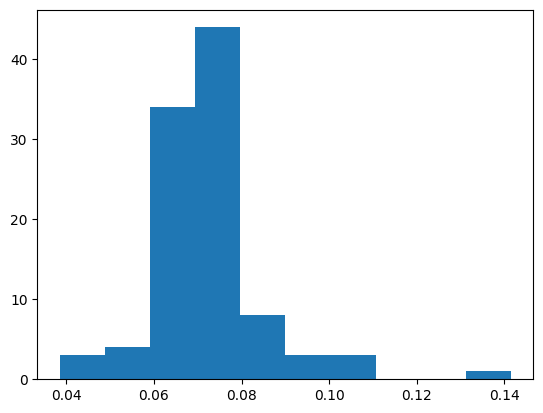

0.07144357
Minimum: 0.03853214700877192
Q1 (First Quartile): 0.0651336019968463
Median: 0.07114313454390625
Q3 (Third Quartile): 0.07581963562212682
Maximum: 0.14148808
True
--------------------------


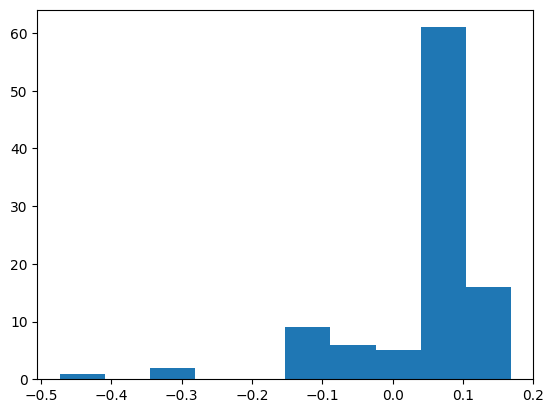

-0.21391432
Minimum: -0.4728894799999999
Q1 (First Quartile): 0.043343577844752124
Median: 0.07591172857142857
Q3 (Third Quartile): 0.08772087750000002
Maximum: 0.16798836928571426
True
--------------------------


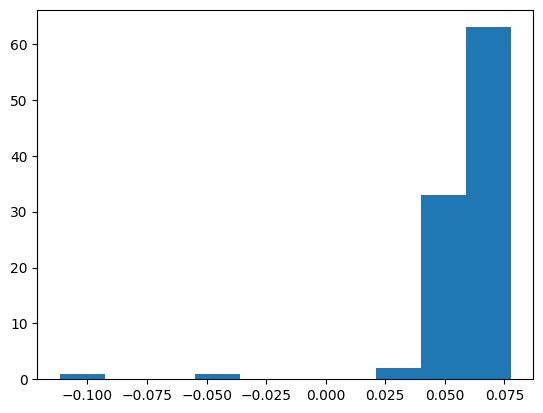

0.052116603
Minimum: -0.11157219
Q1 (First Quartile): 0.05600107631149733
Median: 0.061305750211409854
Q3 (Third Quartile): 0.06733282949570761
Maximum: 0.07770493945945947
True
--------------------------


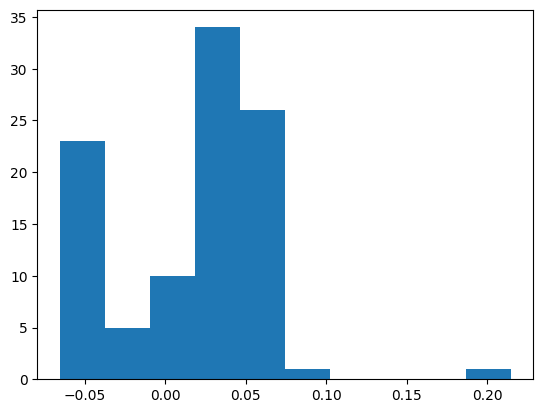

0.033622645
Minimum: -0.06532600428571429
Q1 (First Quartile): -0.0225127195
Median: 0.03361932583333334
Q3 (Third Quartile): 0.04852396310555556
Maximum: 0.21448883
True
--------------------------


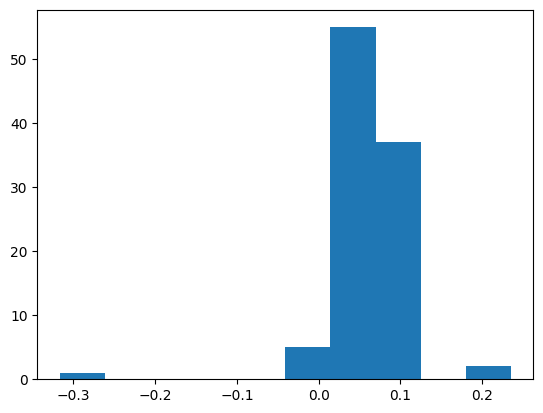

0.073906034
Minimum: -0.31655174
Q1 (First Quartile): 0.058658053257356145
Median: 0.06540424975469755
Q3 (Third Quartile): 0.07216196300132358
Maximum: 0.2350689
True
--------------------------


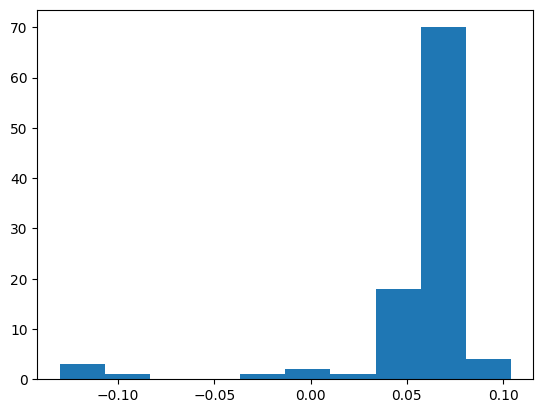

0.048687458
Minimum: -0.13019139
Q1 (First Quartile): 0.05585822014120998
Median: 0.06356963934759655
Q3 (Third Quartile): 0.07080713985656216
Maximum: 0.10393204775
True
--------------------------


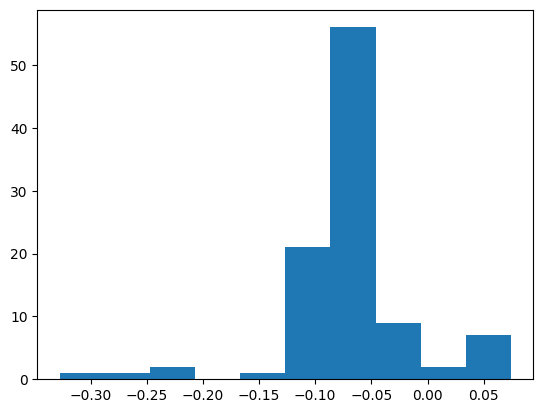

-0.11921772
Minimum: -0.327262
Q1 (First Quartile): -0.08863488725
Median: -0.07718294421978023
Q3 (Third Quartile): -0.066723793875
Maximum: 0.074146494
True
--------------------------


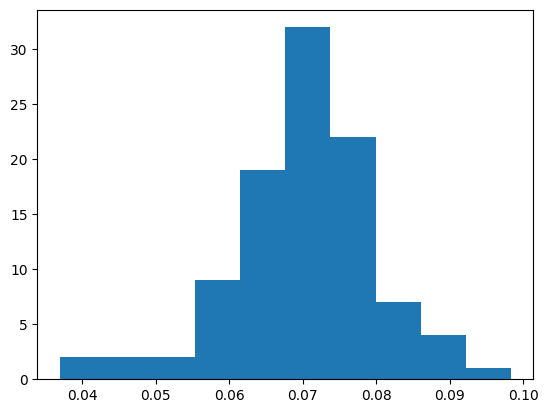

0.052796617
Minimum: 0.03695580606976745
Q1 (First Quartile): 0.06458831430327867
Median: 0.07100009830051922
Q3 (Third Quartile): 0.07597446930806287
Maximum: 0.09832344977419356
True
--------------------------


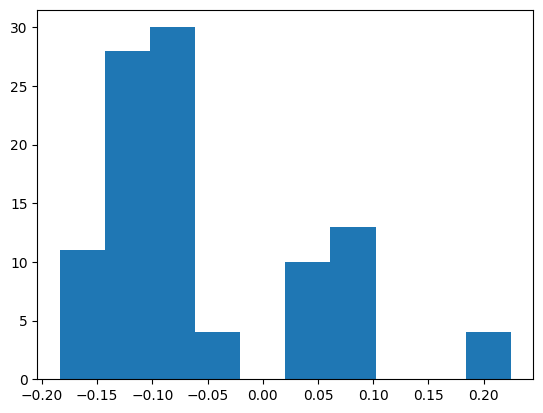

-0.075867236
Minimum: -0.18358667
Q1 (First Quartile): -0.118277205
Median: -0.0870114834181818
Q3 (Third Quartile): 0.038983166
Maximum: 0.22448586
True
--------------------------


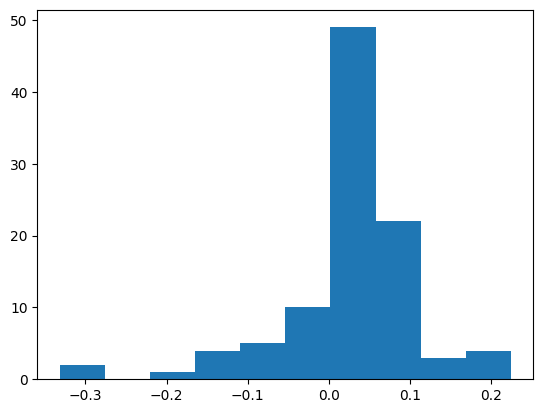

0.08157931
Minimum: -0.33154798
Q1 (First Quartile): 0.010454483967453531
Median: 0.043015927
Q3 (Third Quartile): 0.0579366086
Maximum: 0.22448586
True
--------------------------


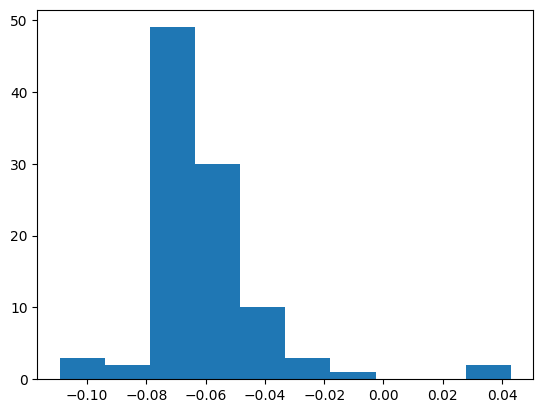

-0.041113935
Minimum: -0.109221965
Q1 (First Quartile): -0.07058972136607142
Median: -0.06529676804578756
Q3 (Third Quartile): -0.05486932163571428
Maximum: 0.042979497
True
--------------------------


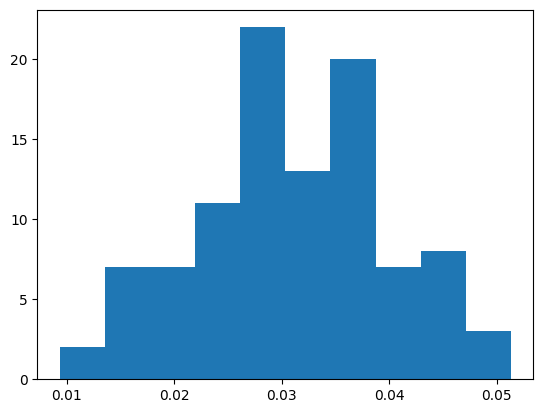

0.0281623
Minimum: 0.009377547739059525
Q1 (First Quartile): 0.025430109324712645
Median: 0.030519169666195858
Q3 (Third Quartile): 0.03614283293750001
Maximum: 0.05131173981355933
True
--------------------------


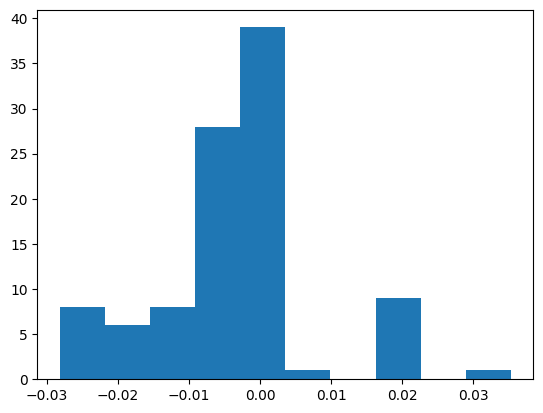

-0.0035544273
Minimum: -0.028179657416666667
Q1 (First Quartile): -0.00742960645875
Median: -0.002677384045375
Q3 (Third Quartile): -0.0001132748365875
Maximum: 0.035275474
True
--------------------------


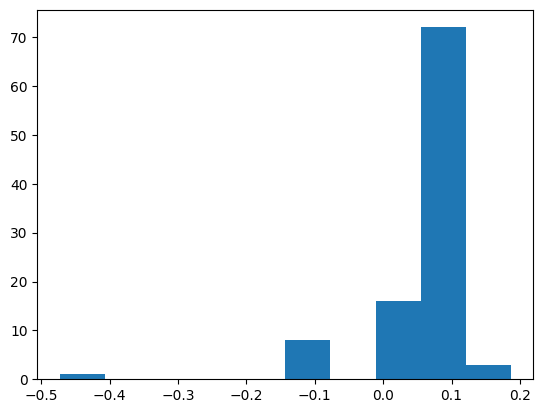

0.101934716
Minimum: -0.47288948
Q1 (First Quartile): 0.05595035852142857
Median: 0.06846150706211336
Q3 (Third Quartile): 0.07582843024586323
Maximum: 0.18666393
True
--------------------------


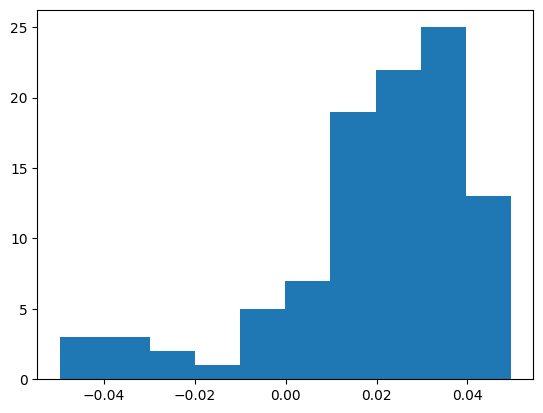

0.023101974
Minimum: -0.049697787
Q1 (First Quartile): 0.012988500642316034
Median: 0.026405091515151517
Q3 (Third Quartile): 0.035213084718749996
Maximum: 0.049551785
True
--------------------------


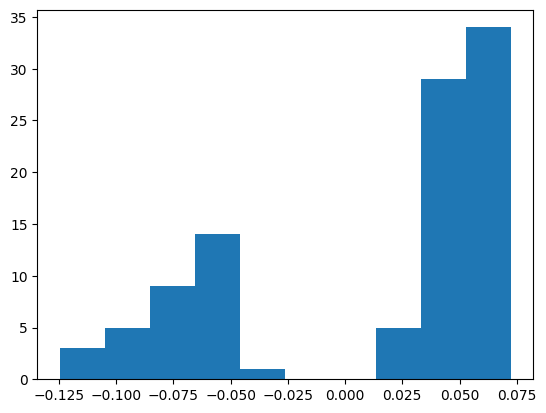

0.053223252
Minimum: -0.12454429666666667
Q1 (First Quartile): -0.050880253
Median: 0.048069565555555555
Q3 (Third Quartile): 0.053180024
Maximum: 0.0723904
True
--------------------------


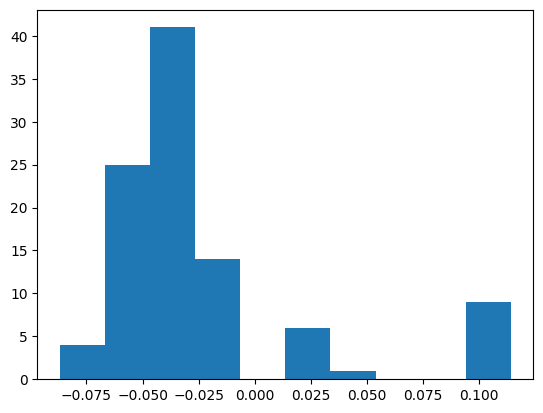

-0.04032162
Minimum: -0.08681868
Q1 (First Quartile): -0.047761573675
Median: -0.036750123
Q3 (Third Quartile): -0.02198896
Maximum: 0.11405867
True
--------------------------


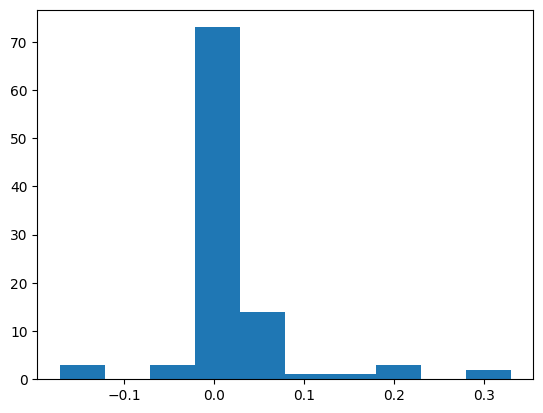

0.0007600767
Minimum: -0.17100567
Q1 (First Quartile): 0.0008948851170833334
Median: 0.00678821764706875
Q3 (Third Quartile): 0.018739284250000002
Maximum: 0.329482
True
--------------------------


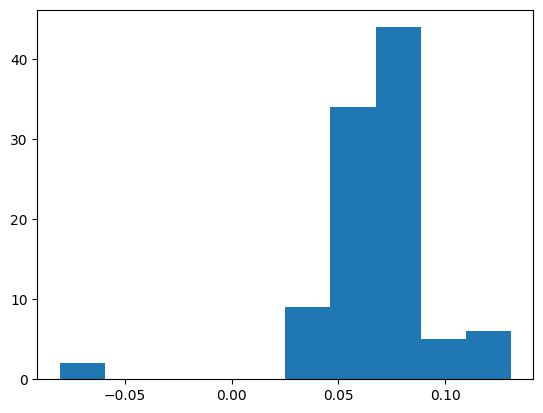

0.05777985
Minimum: -0.08045356
Q1 (First Quartile): 0.059908498679152274
Median: 0.06955493726982696
Q3 (Third Quartile): 0.07557321239020272
Maximum: 0.13080737
True
--------------------------


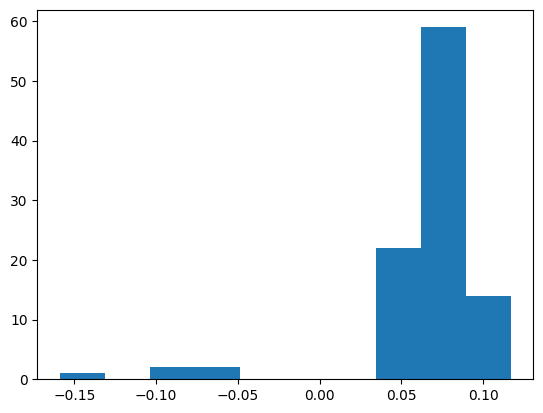

0.064175844
Minimum: -0.15887879
Q1 (First Quartile): 0.06129276765135033
Median: 0.07017390644836671
Q3 (Third Quartile): 0.08117913958333332
Maximum: 0.11687196
True
--------------------------


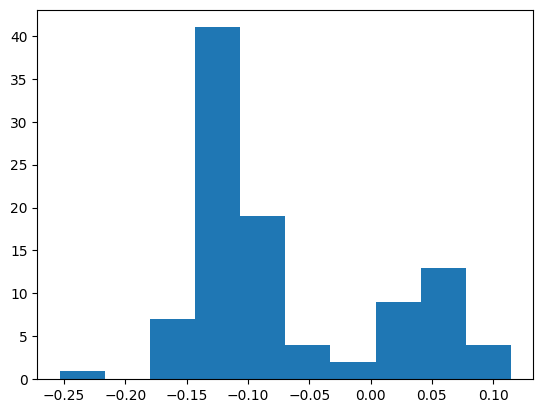

-0.09477106
Minimum: -0.25327846
Q1 (First Quartile): -0.137808
Median: -0.10463209791666667
Q3 (Third Quartile): 0.03485470745096449
Maximum: 0.11438987
True
--------------------------


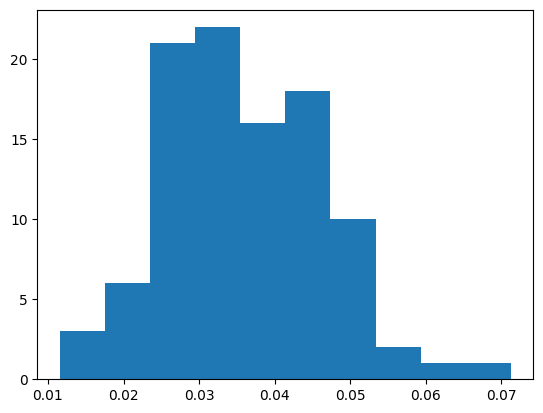

0.03475198
Minimum: 0.0115741132974359
Q1 (First Quartile): 0.02898432902083333
Median: 0.035206596701163315
Q3 (Third Quartile): 0.0437563016653226
Maximum: 0.0712510600078125
True
--------------------------


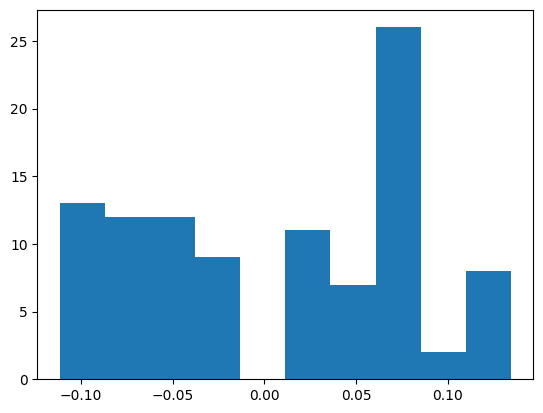

0.14365146
Minimum: -0.11157219
Q1 (First Quartile): -0.058942564
Median: 0.013807693633333335
Q3 (Third Quartile): 0.06695455
Maximum: 0.13443619
False
--------------------------


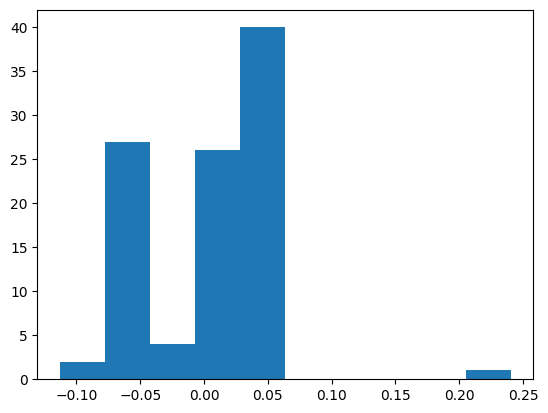

0.03501427
Minimum: -0.11289916
Q1 (First Quartile): -0.05089905
Median: 0.019026238495833334
Q3 (Third Quartile): 0.036728864325
Maximum: 0.2404426
True
--------------------------


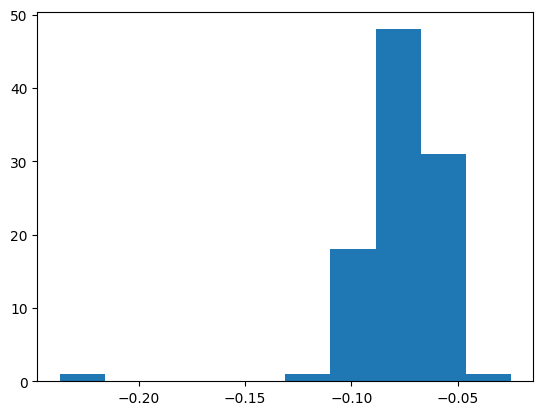

-0.09246221
Minimum: -0.23707876
Q1 (First Quartile): -0.08468194710454546
Median: -0.07216552264770443
Q3 (Third Quartile): -0.0652429934995324
Maximum: -0.024968555954545456
True
--------------------------


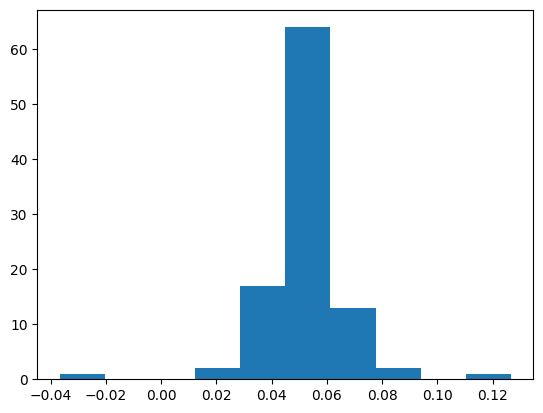

0.12608999
Minimum: -0.036710486
Q1 (First Quartile): 0.0458061010334596
Median: 0.05150208862424242
Q3 (Third Quartile): 0.05869945001582355
Maximum: 0.12660560599999998
True
--------------------------


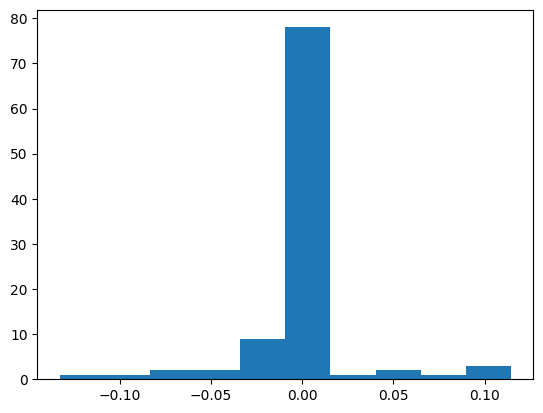

-0.007828182
Minimum: -0.13295135
Q1 (First Quartile): -0.006445382699999999
Median: -0.001752211875
Q3 (Third Quartile): 0.0008653425375454545
Maximum: 0.11438987
True
--------------------------


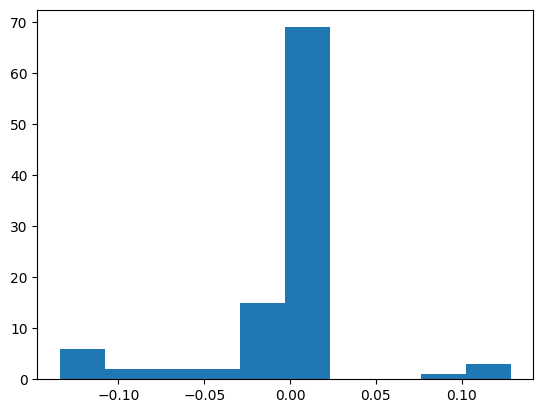

0.0006570816
Minimum: -0.1341429
Q1 (First Quartile): -0.00523533106875
Median: -0.000268589202
Q3 (Third Quartile): 0.0007184251405046428
Maximum: 0.12866214
True
--------------------------


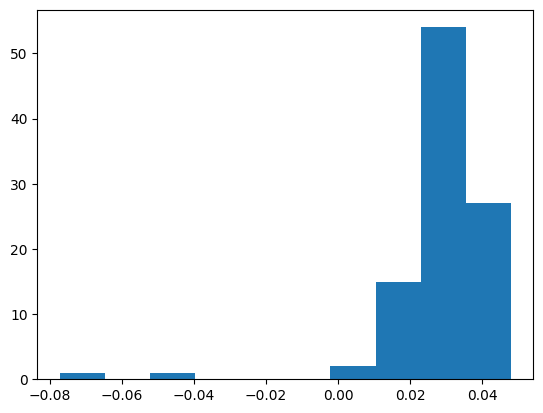

0.02703163
Minimum: -0.07715576685714286
Q1 (First Quartile): 0.025373117324712646
Median: 0.0294968009010989
Q3 (Third Quartile): 0.03552680720967598
Maximum: 0.047924430874999986
True
--------------------------


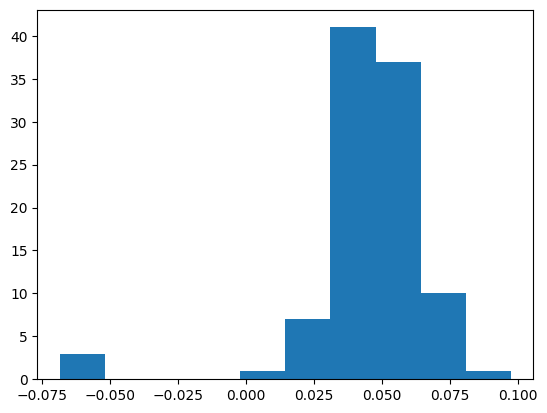

0.04548558
Minimum: -0.06827449
Q1 (First Quartile): 0.03677521535416667
Median: 0.04679267196928298
Q3 (Third Quartile): 0.05531683497916667
Maximum: 0.097492665
True
--------------------------


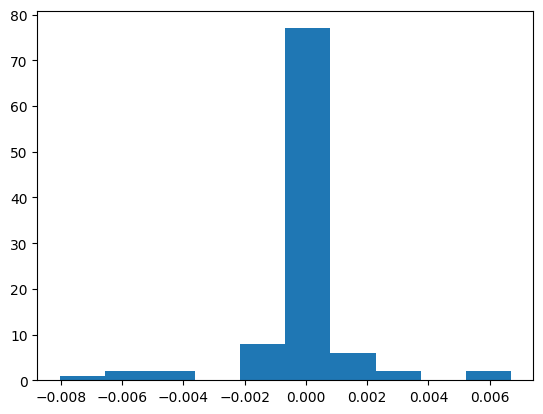

-2.128744e-05
Minimum: -0.008029211
Q1 (First Quartile): -0.00024624655160416674
Median: 5.413138224999994e-06
Q3 (Third Quartile): 0.00014445392862499998
Maximum: 0.0066898763
True
--------------------------


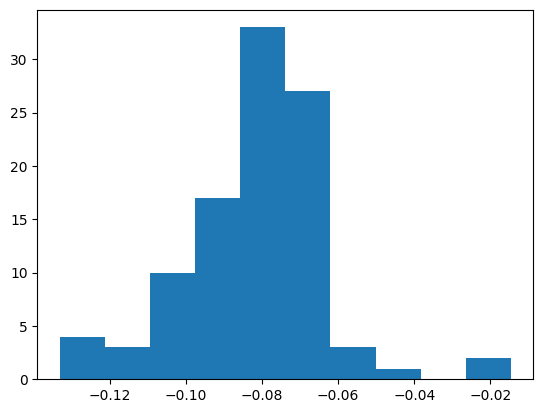

-0.08393738
Minimum: -0.1331401
Q1 (First Quartile): -0.08932737275324676
Median: -0.0793232146733871
Q3 (Third Quartile): -0.0709637168631476
Maximum: -0.01461911225
True
--------------------------


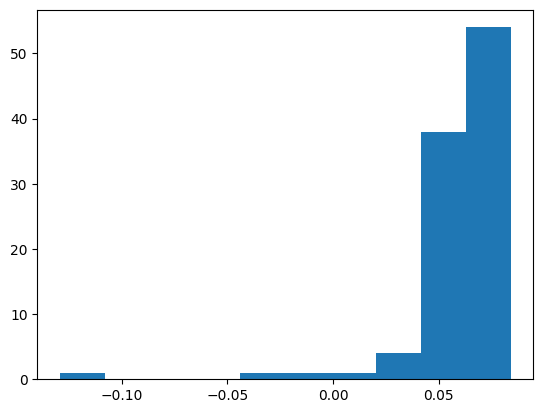

0.046066195
Minimum: -0.12928255
Q1 (First Quartile): 0.05770055330183416
Median: 0.06393207206407006
Q3 (Third Quartile): 0.07001375155576925
Maximum: 0.08420140982786886
True
--------------------------


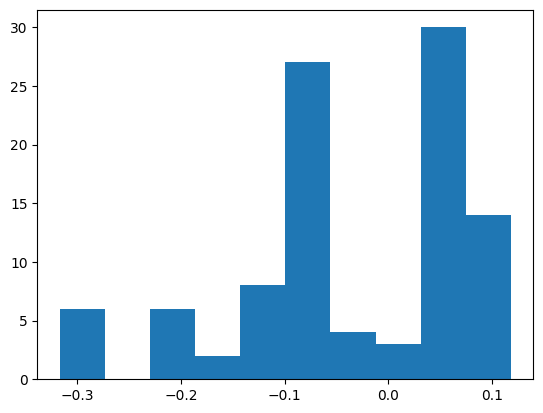

-0.099178076
Minimum: -0.31655174
Q1 (First Quartile): -0.08653853062938596
Median: -0.04390986677967033
Q3 (Third Quartile): 0.06602419987576219
Maximum: 0.11815353
True
--------------------------


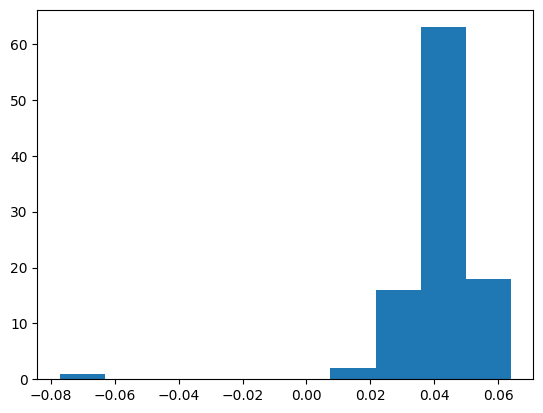

0.03922826
Minimum: -0.07715576685714286
Q1 (First Quartile): 0.03710066681333185
Median: 0.04356998042524467
Q3 (Third Quartile): 0.04874531056493507
Maximum: 0.0639281
True
--------------------------


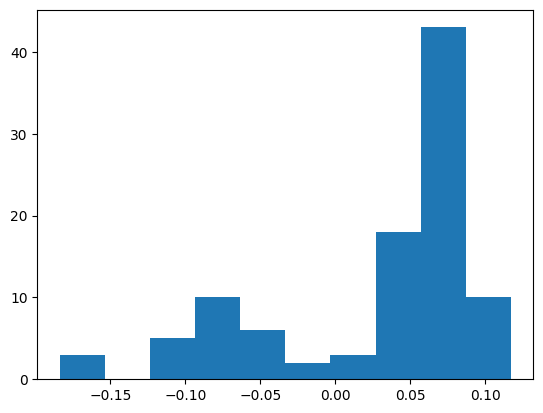

0.053306058
Minimum: -0.18358667
Q1 (First Quartile): -0.015721899136294116
Median: 0.05976829969999999
Q3 (Third Quartile): 0.07499802783333333
Maximum: 0.11687196
True
--------------------------


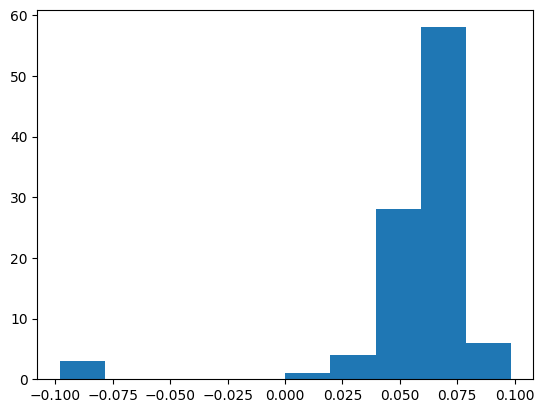

0.061035514
Minimum: -0.09807103333333334
Q1 (First Quartile): 0.05340282356458458
Median: 0.06281880621503497
Q3 (Third Quartile): 0.07083235430726902
Maximum: 0.09832344977419356
True
--------------------------


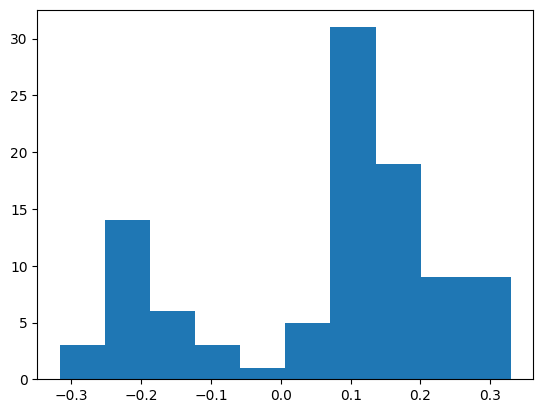

0.1905067
Minimum: -0.31655174
Q1 (First Quartile): -0.09269087312499999
Median: 0.11741610929687499
Q3 (Third Quartile): 0.1648905608763158
Maximum: 0.329482
True
--------------------------


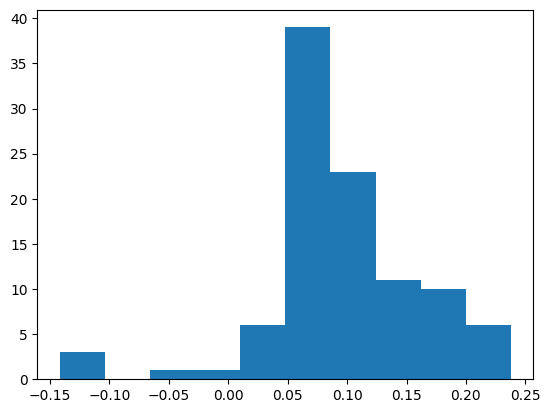

0.12990697
Minimum: -0.14164317
Q1 (First Quartile): 0.07088391387280493
Median: 0.08736608618162393
Q3 (Third Quartile): 0.12808168112079327
Maximum: 0.23775575
True
--------------------------


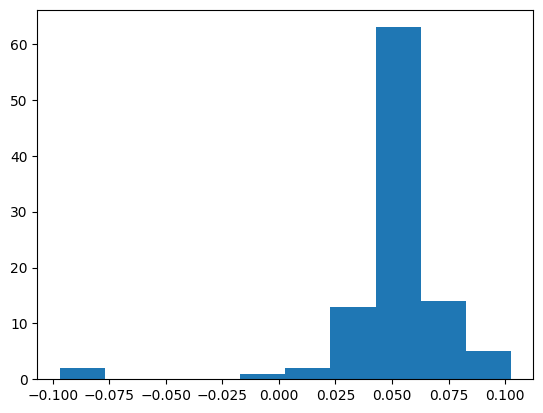

0.08509812
Minimum: -0.0967976
Q1 (First Quartile): 0.046017636756368205
Median: 0.052386585068589744
Q3 (Third Quartile): 0.06119838467459417
Maximum: 0.10253084600000001
True
--------------------------


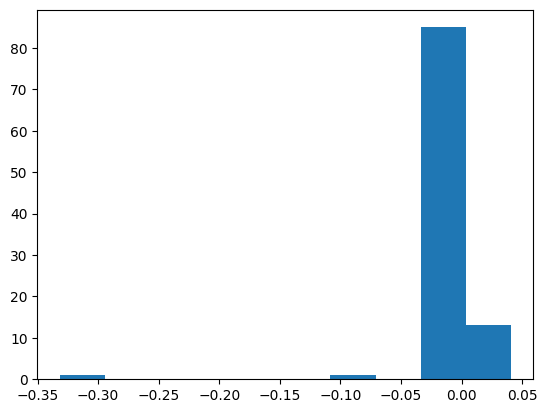

-0.00030525005
Minimum: -0.33154798
Q1 (First Quartile): -0.002999194654209
Median: -0.00017953307016754544
Q3 (Third Quartile): 0.0005836237606848889
Maximum: 0.040645868
True
--------------------------


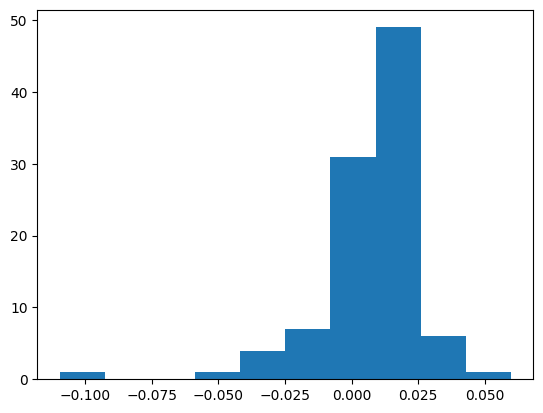

0.012359619
Minimum: -0.109443784
Q1 (First Quartile): 0.00252580567806702
Median: 0.010138358983000001
Q3 (Third Quartile): 0.016670600672297295
Maximum: 0.05971098
True
--------------------------


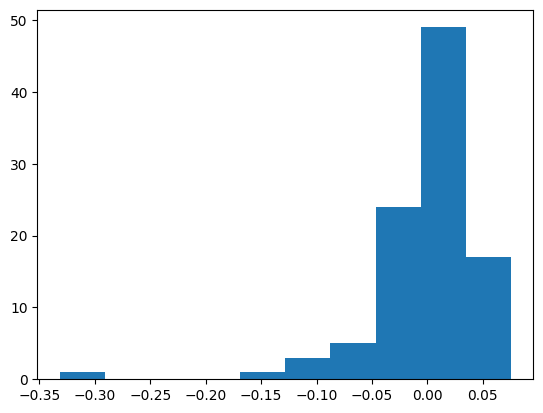

-0.005135839
Minimum: -0.33154798
Q1 (First Quartile): -0.031903885
Median: -0.0006793153176153138
Q3 (Third Quartile): 0.007166182
Maximum: 0.07513226
True
--------------------------


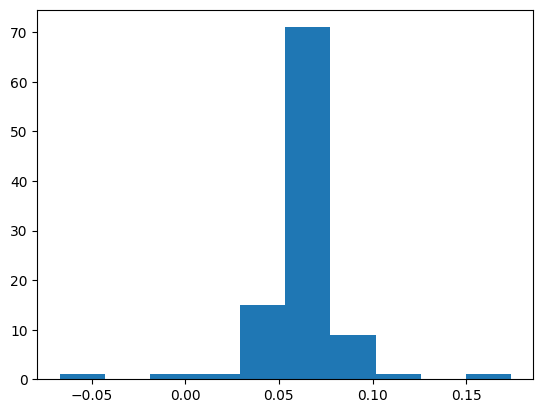

0.06913276
Minimum: -0.06687080975
Q1 (First Quartile): 0.05919995559365836
Median: 0.0661685072403626
Q3 (Third Quartile): 0.07209907453391386
Maximum: 0.17377096
True
--------------------------


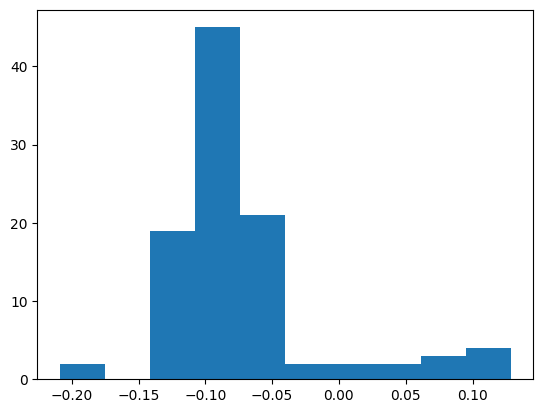

-0.123915195
Minimum: -0.2088615
Q1 (First Quartile): -0.106403955
Median: -0.08590930570000001
Q3 (Third Quartile): -0.07007094182340426
Maximum: 0.12866214
True
--------------------------


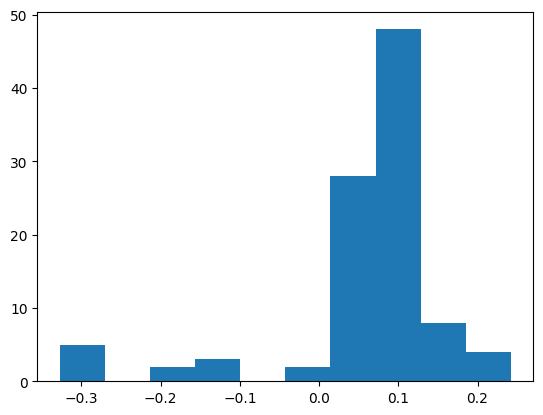

-0.07108373
Minimum: -0.327262
Q1 (First Quartile): 0.06258334510665958
Median: 0.07766576806596824
Q3 (Third Quartile): 0.1064948254923114
Maximum: 0.24204447999999998
True
--------------------------


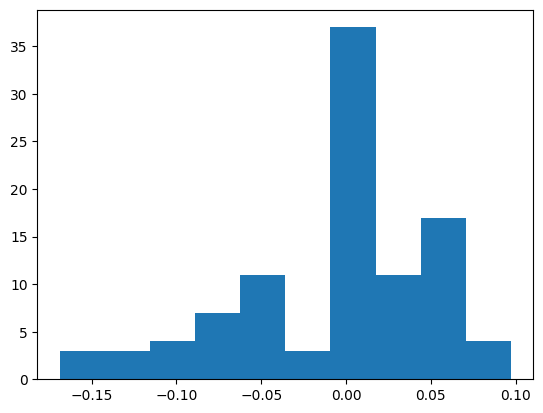

-0.0064673075
Minimum: -0.16863105
Q1 (First Quartile): -0.04351604347224999
Median: 0.006428804319999999
Q3 (Third Quartile): 0.031373143
Maximum: 0.09709264
True
--------------------------


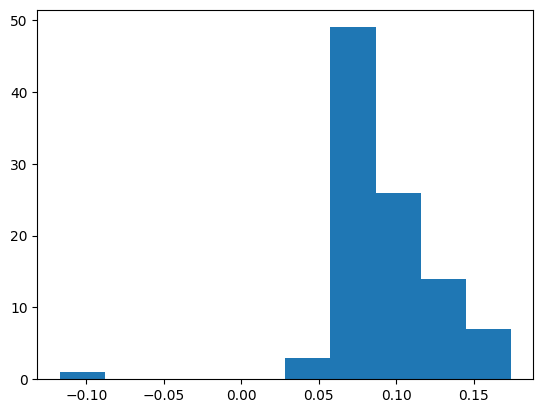

0.14870849
Minimum: -0.11699024
Q1 (First Quartile): 0.07177187997641964
Median: 0.08446076493393442
Q3 (Third Quartile): 0.10607072349999999
Maximum: 0.17377096
True
--------------------------


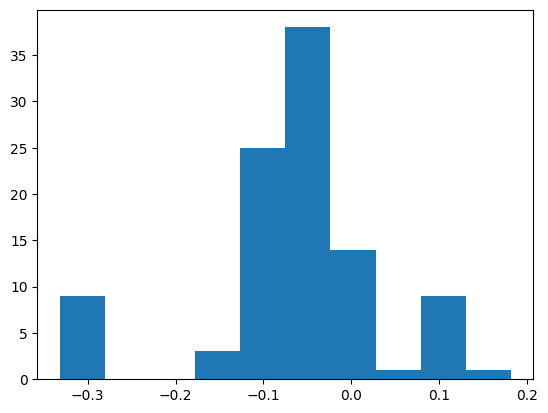

-0.18357629
Minimum: -0.33154798
Q1 (First Quartile): -0.0880160825
Median: -0.0650748844
Q3 (Third Quartile): -0.02415405068181818
Maximum: 0.18125486
True
--------------------------


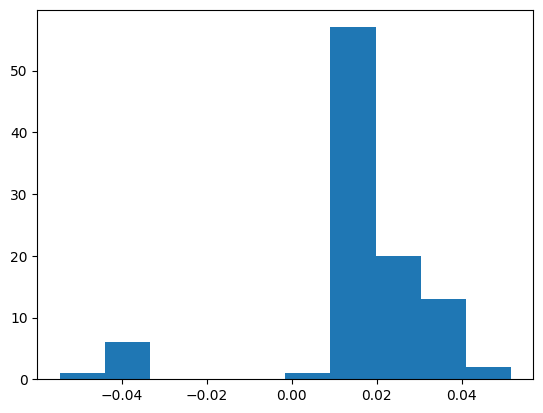

0.020012528
Minimum: -0.054602765
Q1 (First Quartile): 0.015524419983451705
Median: 0.0185727974404246
Q3 (Third Quartile): 0.02491962278541666
Maximum: 0.051514953
True
--------------------------


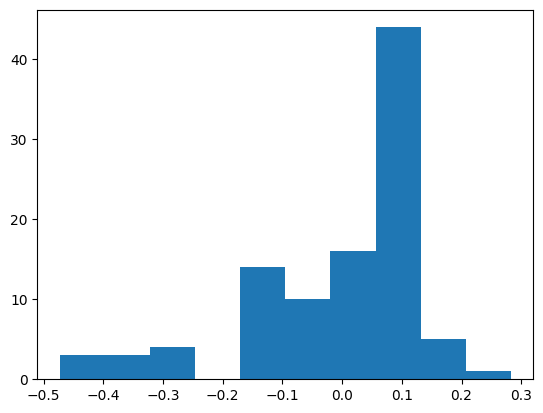

0.09244564
Minimum: -0.47288948
Q1 (First Quartile): -0.09278723347426471
Median: 0.05523005104027063
Q3 (Third Quartile): 0.0849529075
Maximum: 0.28255415
True
--------------------------


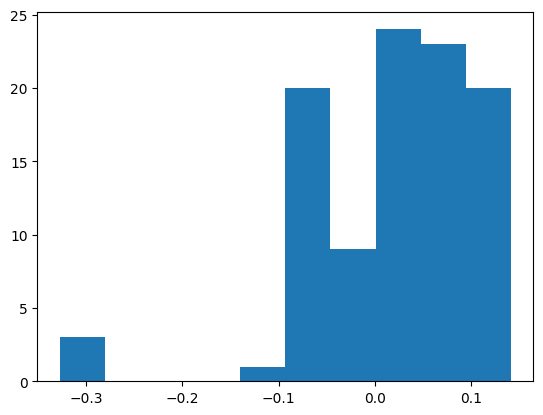

0.06418457
Minimum: -0.327262
Q1 (First Quartile): -0.035880134625000004
Median: 0.03496382557992424
Q3 (Third Quartile): 0.06939553563928572
Maximum: 0.14148808
True
--------------------------


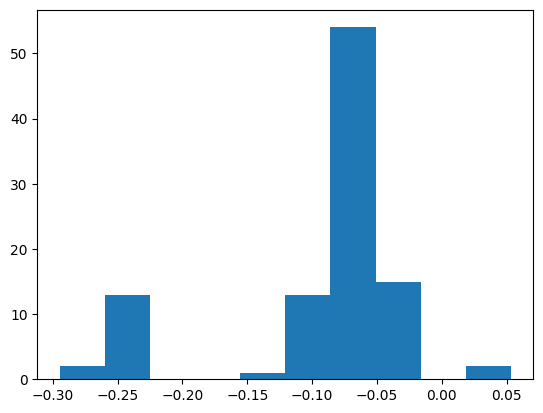

-0.09192987
Minimum: -0.29443255
Q1 (First Quartile): -0.09260684573195122
Median: -0.07276742974540443
Q3 (Third Quartile): -0.062729296405873
Maximum: 0.053180024
True
--------------------------


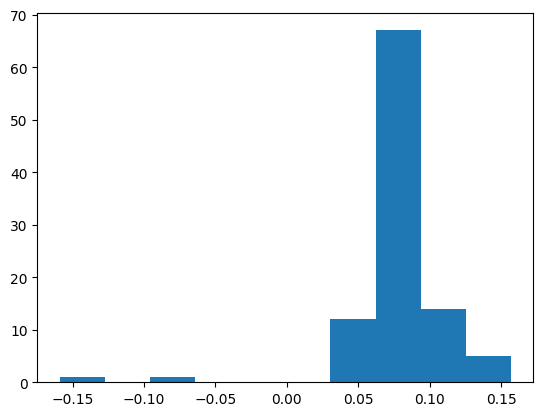

0.09043676
Minimum: -0.15887879
Q1 (First Quartile): 0.06869105025099194
Median: 0.07598307062132353
Q3 (Third Quartile): 0.08583371457989926
Maximum: 0.15675663125000003
True
--------------------------


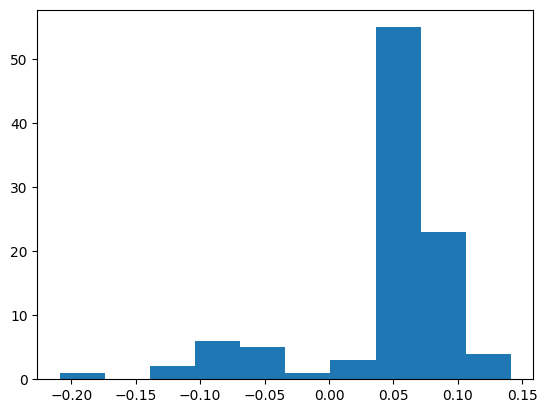

0.053545143
Minimum: -0.2088615
Q1 (First Quartile): 0.05001528970295698
Median: 0.06416162718203884
Q3 (Third Quartile): 0.07196261921237398
Maximum: 0.14112675
True
--------------------------


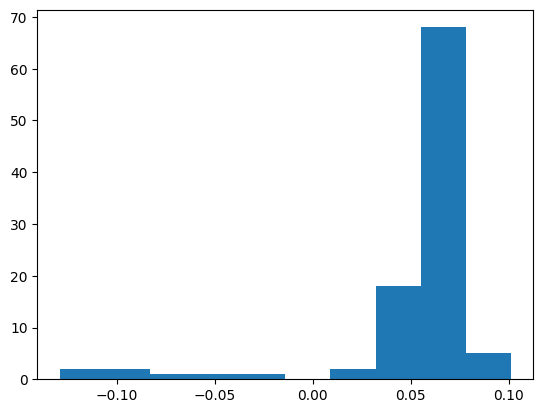

0.062382013
Minimum: -0.12928255
Q1 (First Quartile): 0.05374526221758022
Median: 0.06299782539512985
Q3 (Third Quartile): 0.06974976693308746
Maximum: 0.1011076548888889
True
--------------------------


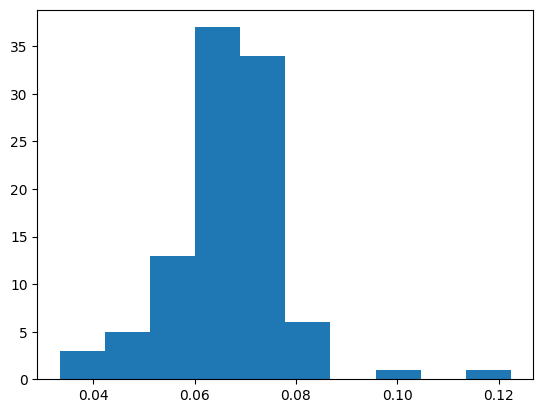

0.07406095
Minimum: 0.03338235394348388
Q1 (First Quartile): 0.06124106859964116
Median: 0.06685028579125948
Q3 (Third Quartile): 0.0719805517571364
Maximum: 0.12241788607142857
True
--------------------------


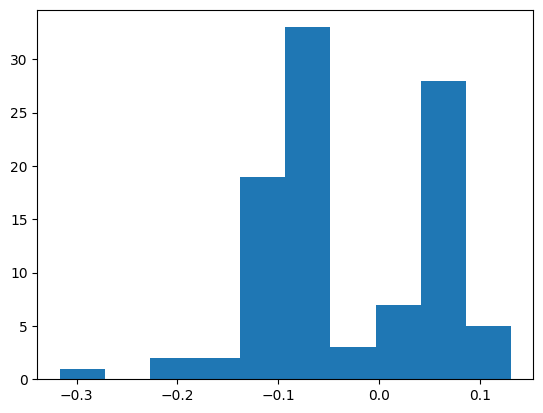

0.04187061
Minimum: -0.31655174
Q1 (First Quartile): -0.09083423893526787
Median: -0.06101021218421053
Q3 (Third Quartile): 0.05308130775
Maximum: 0.13080737
True
--------------------------


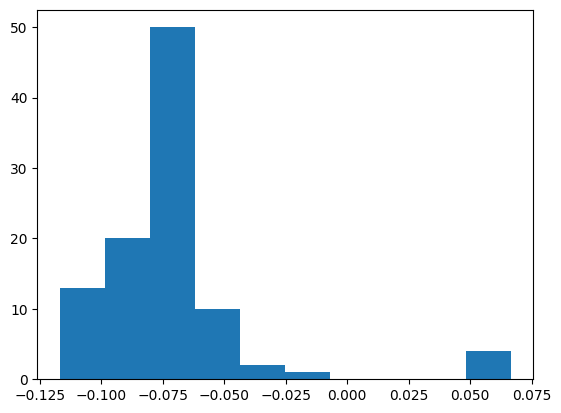

-0.07596406
Minimum: -0.11680281
Q1 (First Quartile): -0.08993977982663526
Median: -0.07328988384208779
Q3 (Third Quartile): -0.0652429934995324
Maximum: 0.06649947122222222
True
--------------------------


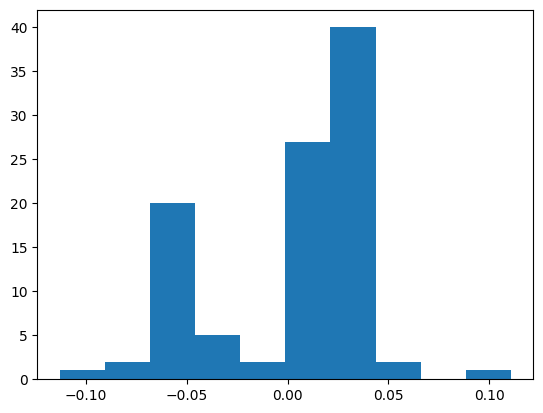

0.050315738
Minimum: -0.11289916
Q1 (First Quartile): -0.02938164
Median: 0.017655939750000002
Q3 (Third Quartile): 0.041190416
Maximum: 0.110670626
True
--------------------------


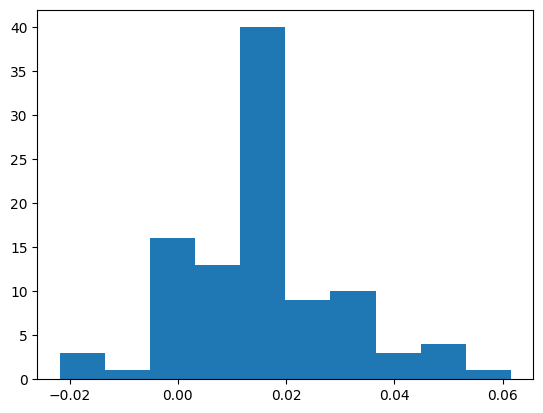

0.012990472
Minimum: -0.021795738
Q1 (First Quartile): 0.00678426773469186
Median: 0.014465873950757577
Q3 (Third Quartile): 0.02104159823369565
Maximum: 0.06151038
True
--------------------------


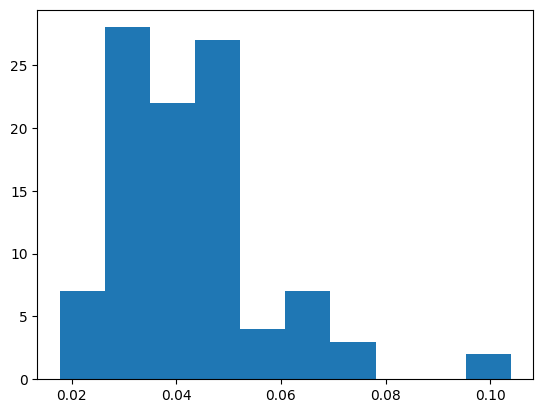

0.034836262
Minimum: 0.017777768916666666
Q1 (First Quartile): 0.0309241978125
Median: 0.040986442124999994
Q3 (Third Quartile): 0.05054502342478815
Maximum: 0.10388255
True
--------------------------


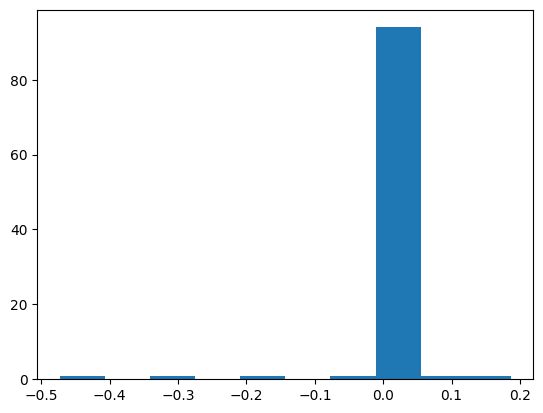

0.0019654818
Minimum: -0.47288948
Q1 (First Quartile): 9.107267193259564e-05
Median: 0.000585653251336
Q3 (Third Quartile): 0.0039028097890007113
Maximum: 0.18660437
True
--------------------------


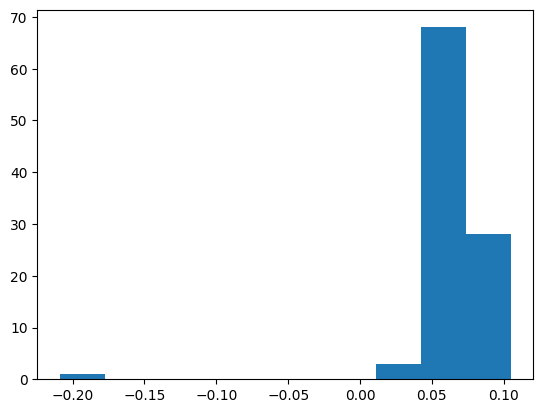

0.10154881
Minimum: -0.2088615
Q1 (First Quartile): 0.05688108764097744
Median: 0.06713903350152436
Q3 (Third Quartile): 0.07403081672669147
Maximum: 0.10489408734722223
True
--------------------------


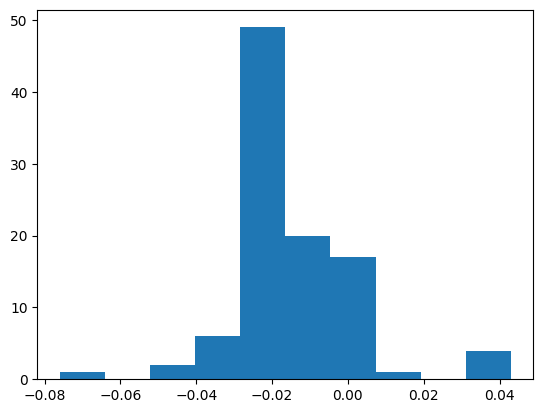

-0.016023932
Minimum: -0.07594608
Q1 (First Quartile): -0.021561258012499997
Median: -0.018496430166666668
Q3 (Third Quartile): -0.009409506
Maximum: 0.042979497
True
--------------------------


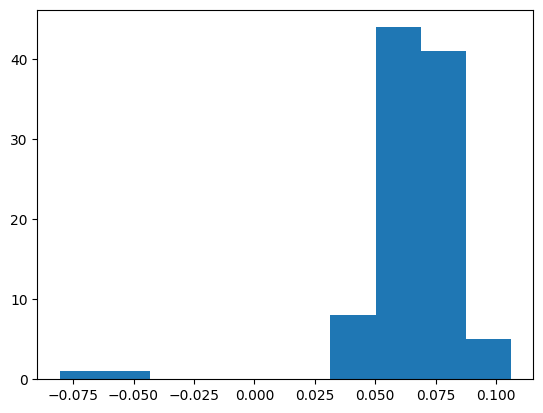

0.05674632
Minimum: -0.08045356
Q1 (First Quartile): 0.05972213991545601
Median: 0.06781215755026455
Q3 (Third Quartile): 0.07385894602000001
Maximum: 0.10608891471428572
True
--------------------------


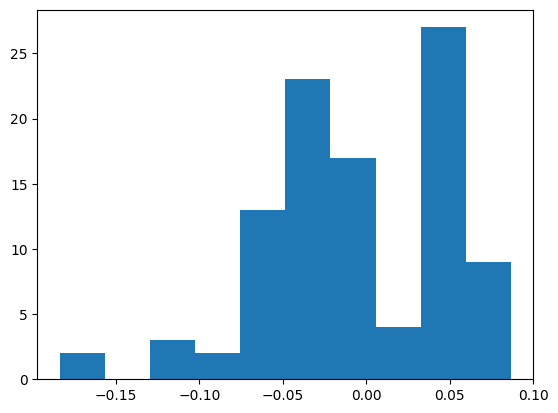

0.07383939
Minimum: -0.18358667
Q1 (First Quartile): -0.041296200166666665
Median: -0.0137263015
Q3 (Third Quartile): 0.04128799
Maximum: 0.08662616
True
--------------------------


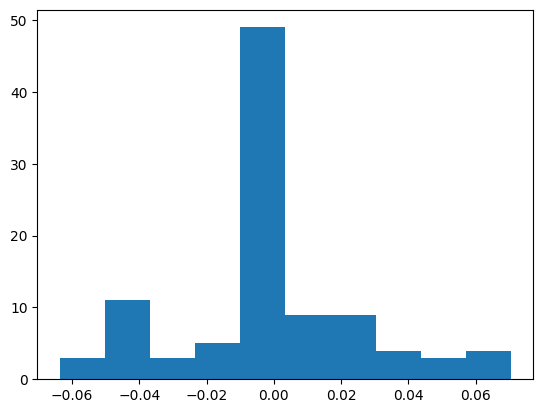

-0.008376536
Minimum: -0.063635804
Q1 (First Quartile): -0.0071835196031507995
Median: -0.0017194127537059798
Q3 (Third Quartile): 0.0102805439
Maximum: 0.07044910183333332
True
--------------------------


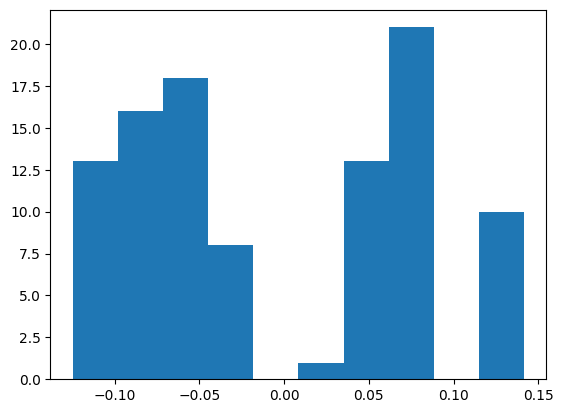

0.055406332
Minimum: -0.124606535
Q1 (First Quartile): -0.08991208
Median: -0.03358210625
Q3 (Third Quartile): 0.06567363719285713
Maximum: 0.14148808
True
--------------------------


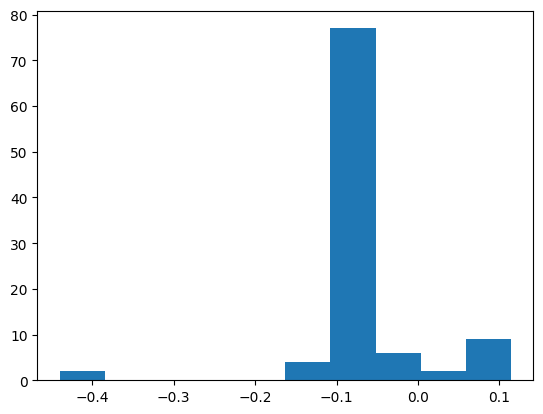

-0.10621399
Minimum: -0.4397846
Q1 (First Quartile): -0.08777388375
Median: -0.07429565040095895
Q3 (Third Quartile): -0.06313824988
Maximum: 0.11405867
True
--------------------------


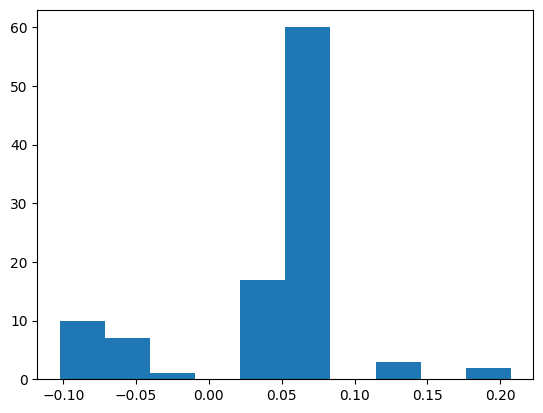

0.05538728
Minimum: -0.10229018
Q1 (First Quartile): 0.048031303
Median: 0.05861673077272728
Q3 (Third Quartile): 0.06589074575000001
Maximum: 0.20719887
True
--------------------------


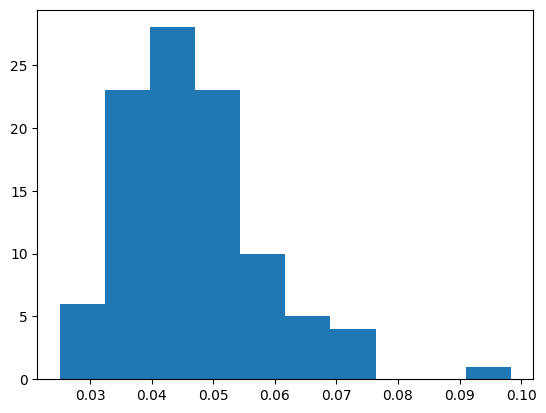

0.04302457
Minimum: 0.025081128
Q1 (First Quartile): 0.03805048904567308
Median: 0.04549616120588235
Q3 (Third Quartile): 0.05194806998658731
Maximum: 0.09832344977419356
True
--------------------------


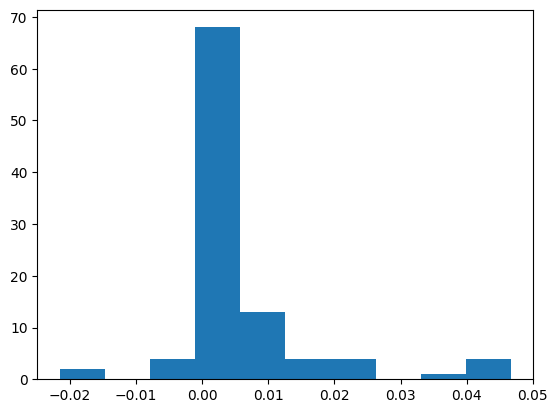

-0.00021484513
Minimum: -0.021492710733333337
Q1 (First Quartile): 0.00011832528786789774
Median: 0.0009638144965427352
Q3 (Third Quartile): 0.006918653411283985
Maximum: 0.04666106997910653
True
--------------------------


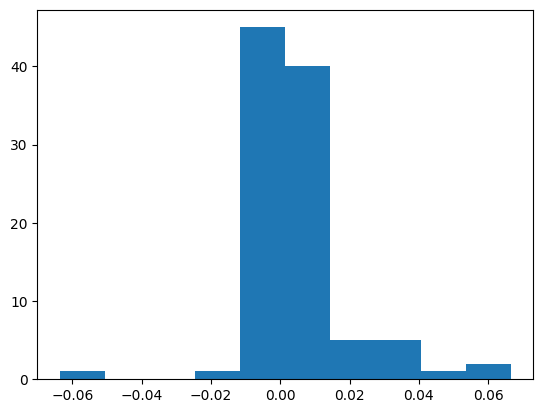

0.0077282847
Minimum: -0.063635804
Q1 (First Quartile): -0.0004944413471593182
Median: 0.001788703601648364
Q3 (Third Quartile): 0.008684778422434213
Maximum: 0.06652388
True
--------------------------


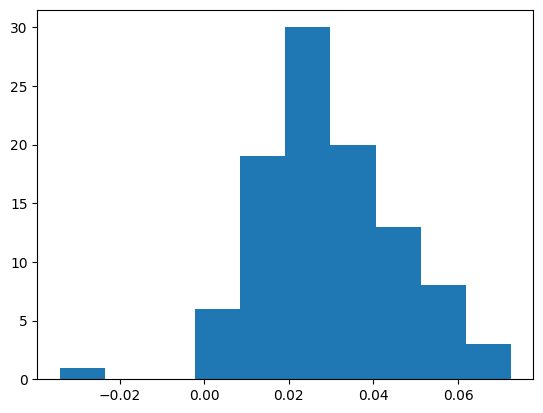

0.021959115
Minimum: -0.03408913
Q1 (First Quartile): 0.018856459385700203
Median: 0.0277053183756181
Q3 (Third Quartile): 0.04005974121613712
Maximum: 0.07244065362303666
True
--------------------------


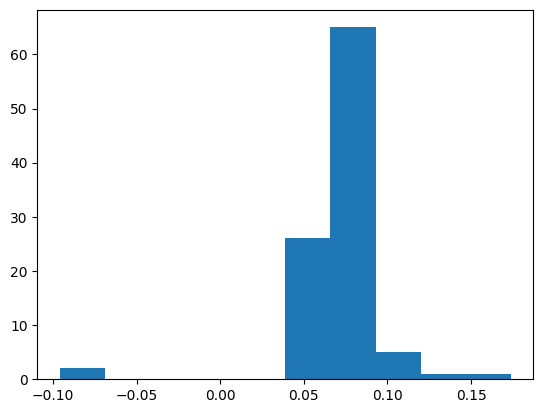

0.11332375
Minimum: -0.09585925479999999
Q1 (First Quartile): 0.0651336019968463
Median: 0.07136191530605265
Q3 (Third Quartile): 0.07757235439662184
Maximum: 0.17377096
True
--------------------------


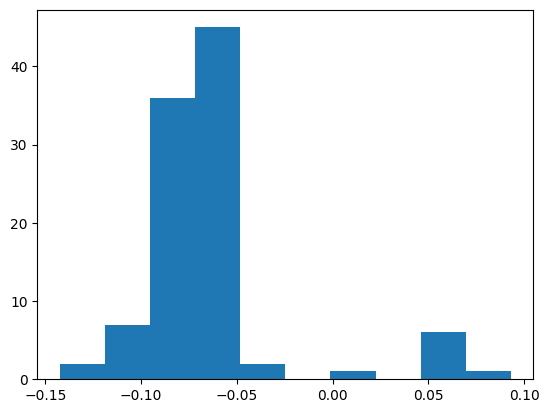

-0.08610217
Minimum: -0.14246388
Q1 (First Quartile): -0.0803185346320116
Median: -0.06808591727504554
Q3 (Third Quartile): -0.05846749
Maximum: 0.093091115
True
--------------------------


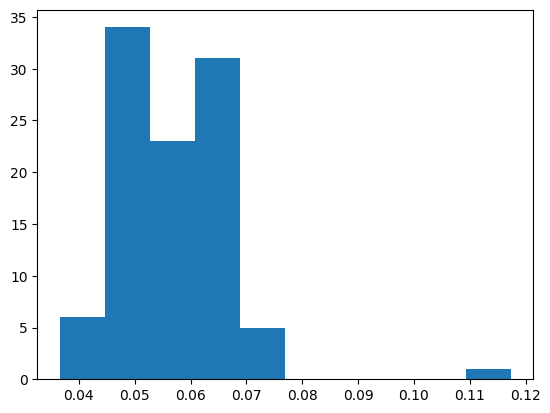

0.043130696
Minimum: 0.03660275257142858
Q1 (First Quartile): 0.049055984605392164
Median: 0.05655245685901535
Q3 (Third Quartile): 0.062391016180098145
Maximum: 0.11736606
True
--------------------------


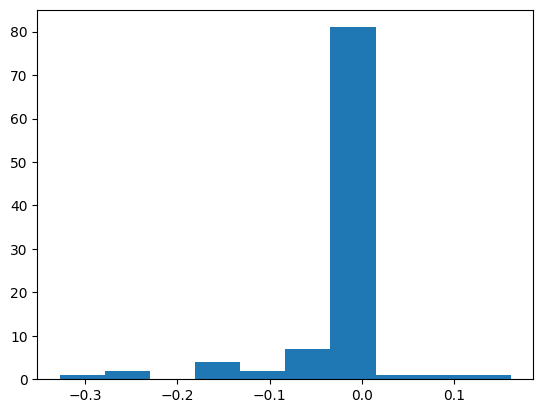

0.0005404353
Minimum: -0.327262
Q1 (First Quartile): -0.015171759784935485
Median: -0.0013497405
Q3 (Third Quartile): 0.0005543900795125
Maximum: 0.1610451
True
--------------------------


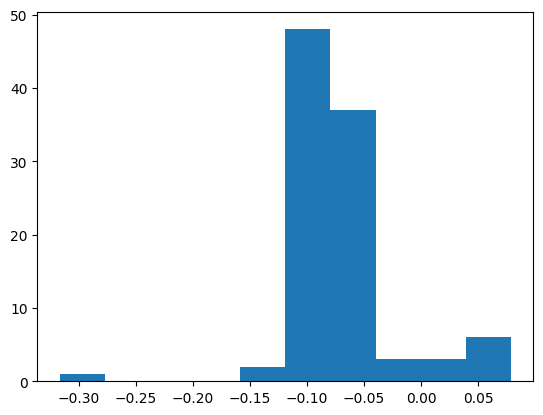

-0.108428165
Minimum: -0.31655174
Q1 (First Quartile): -0.09939065216666668
Median: -0.08113803511840031
Q3 (Third Quartile): -0.06843673742461581
Maximum: 0.078528464
True
--------------------------


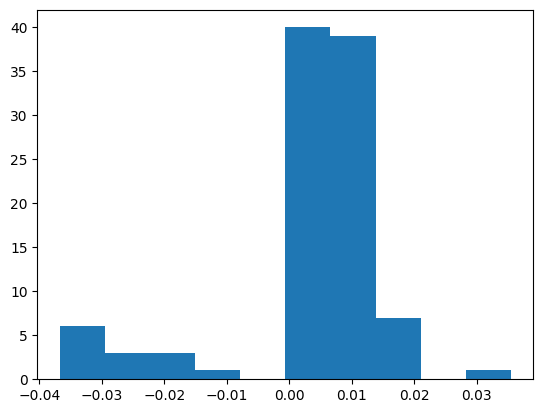

0.010804057
Minimum: -0.036710486
Q1 (First Quartile): 0.0017138141773389696
Median: 0.005250952601512865
Q3 (Third Quartile): 0.010477791572916666
Maximum: 0.0354770431519084
True
--------------------------


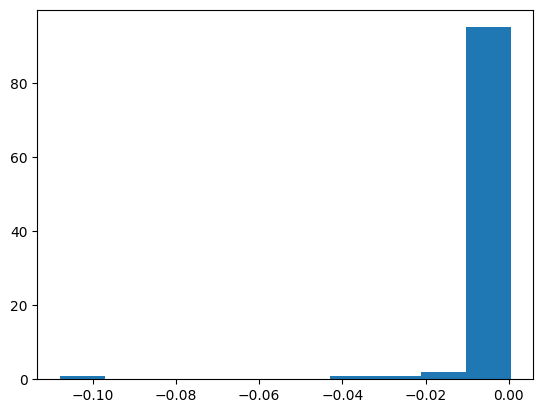

-0.00013424085
Minimum: -0.107920304
Q1 (First Quartile): -0.0025435756720059784
Median: -0.0002711850534
Q3 (Third Quartile): -1.653210893118132e-05
Maximum: 0.00048736084855882357
True
--------------------------


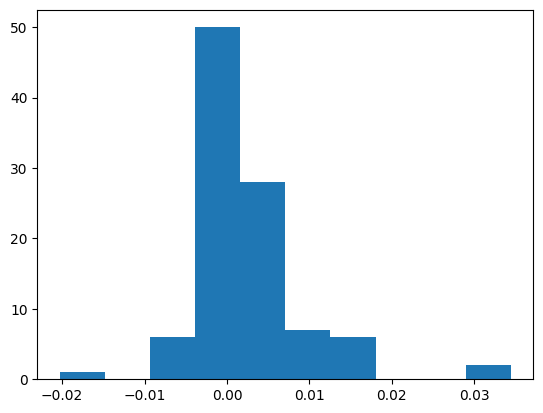

0.004183877
Minimum: -0.020265143
Q1 (First Quartile): -0.0002789351832275357
Median: 0.0011883158703005347
Q3 (Third Quartile): 0.003200500230357143
Maximum: 0.034430337736842107
True
--------------------------


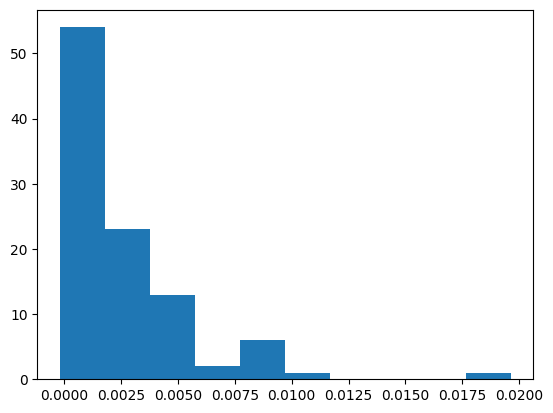

0.00028899312
Minimum: -0.00019935510256250026
Q1 (First Quartile): 0.0006131318208333332
Median: 0.0015702622002035577
Q3 (Third Quartile): 0.0035033399813748215
Maximum: 0.019636853377865384
True
--------------------------


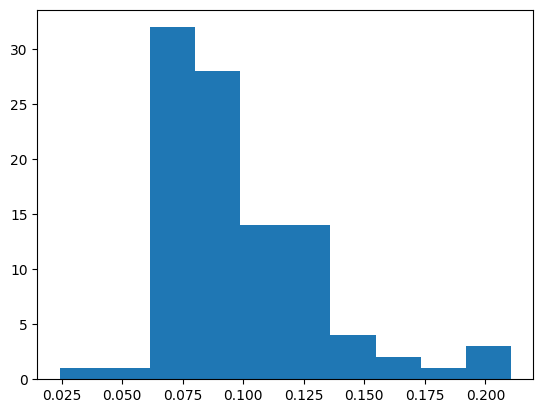

0.095016286
Minimum: 0.024231319333333334
Q1 (First Quartile): 0.07568244157770272
Median: 0.08974367496415442
Q3 (Third Quartile): 0.11577272961885247
Maximum: 0.2104948866666667
True
--------------------------


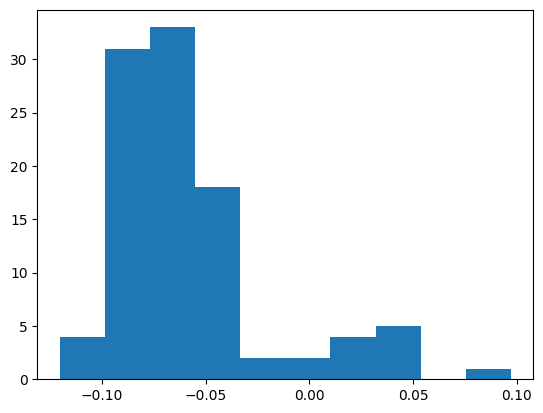

-0.09361543
Minimum: -0.12018340670000001
Q1 (First Quartile): -0.08002998446428572
Median: -0.06749311356590688
Q3 (Third Quartile): -0.04928307909375
Maximum: 0.09709264
True
--------------------------


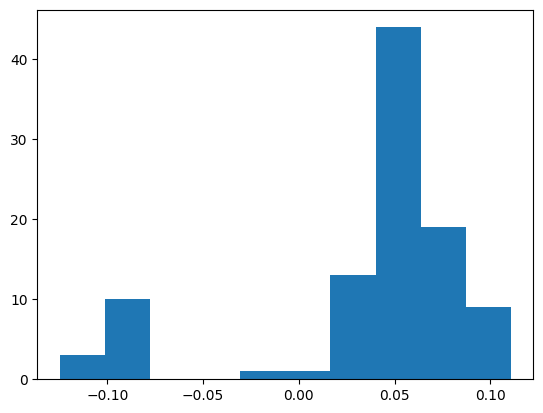

0.042096257
Minimum: -0.12480098
Q1 (First Quartile): 0.03737884654520148
Median: 0.04862510452352942
Q3 (Third Quartile): 0.06504016719830827
Maximum: 0.110670626
True
--------------------------


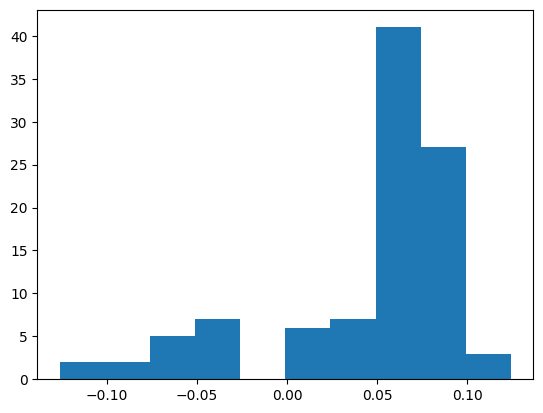

0.06865663
Minimum: -0.12620836
Q1 (First Quartile): 0.03695204547411398
Median: 0.06719637754032257
Q3 (Third Quartile): 0.07620668653533434
Maximum: 0.12426804980000002
True
--------------------------


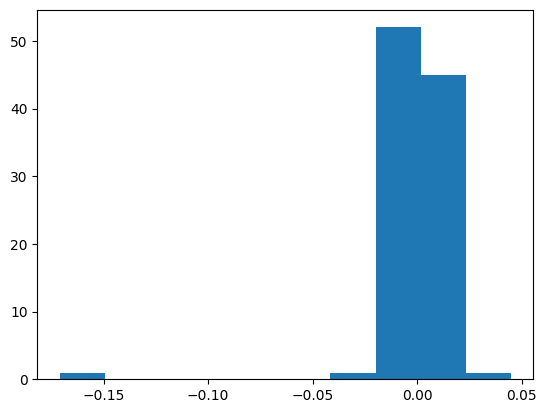

-0.0007499211
Minimum: -0.17100567
Q1 (First Quartile): 0.000510517129979128
Median: 0.0015047501654866667
Q3 (Third Quartile): 0.003480360010694029
Maximum: 0.044863433
True
--------------------------


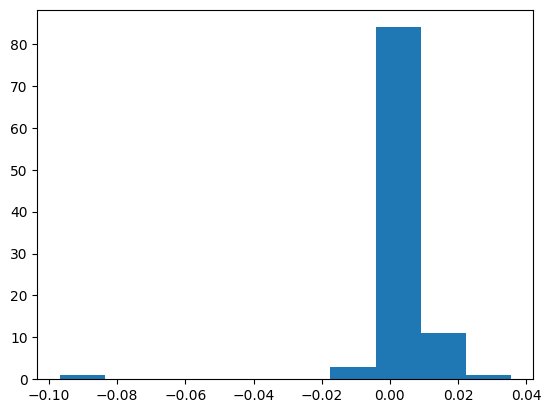

0.008591412
Minimum: -0.0967976
Q1 (First Quartile): 0.0012477768248430852
Median: 0.0033653161829482053
Q3 (Third Quartile): 0.006965567401435407
Maximum: 0.0354770431519084
True
--------------------------


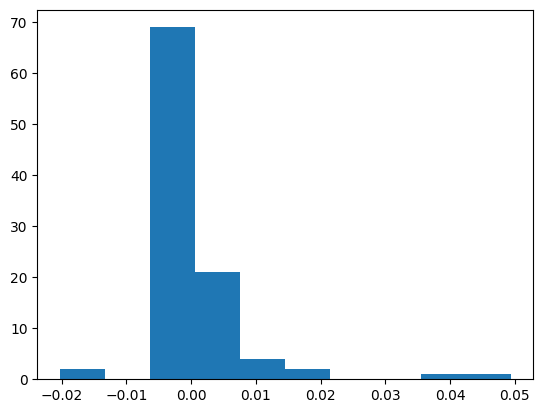

0.00028514705
Minimum: -0.020265143
Q1 (First Quartile): -0.00010021414363392855
Median: 7.162300525675384e-05
Q3 (Third Quartile): 0.0008849396073883928
Maximum: 0.049369358
True
--------------------------


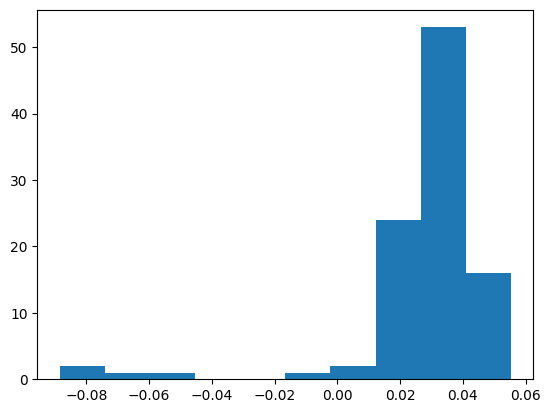

0.030846447
Minimum: -0.08838782
Q1 (First Quartile): 0.025072177333333334
Median: 0.0294968009010989
Q3 (Third Quartile): 0.03609065827317001
Maximum: 0.055252533125
True
--------------------------


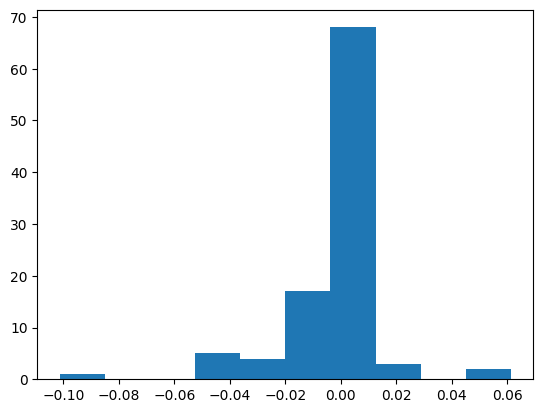

-0.0007197915
Minimum: -0.10121666
Q1 (First Quartile): -0.004014360915975544
Median: -0.0004388785821972596
Q3 (Third Quartile): 0.0005044641787426471
Maximum: 0.06134275899999999
True
--------------------------


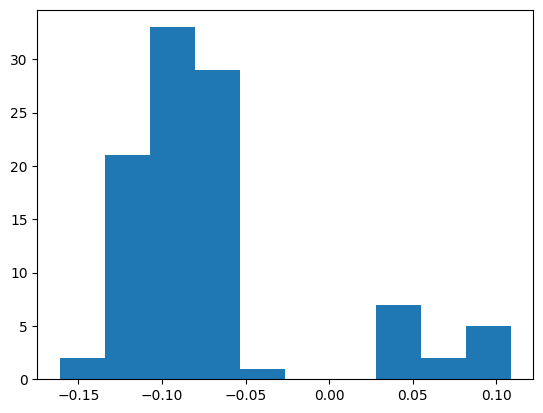

-0.08459192
Minimum: -0.161112
Q1 (First Quartile): -0.10375840708333334
Median: -0.0838791155
Q3 (Third Quartile): -0.06518238379545455
Maximum: 0.10857057
True
--------------------------


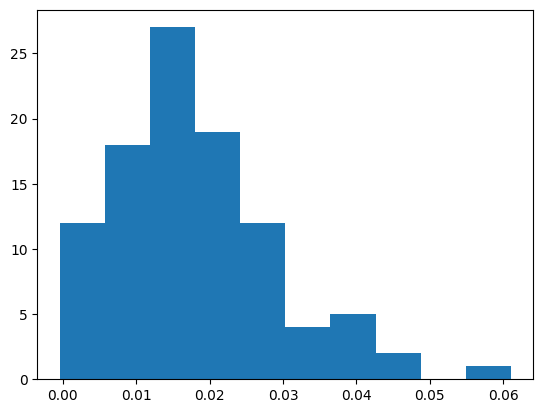

0.009188842
Minimum: -0.00038320782499999973
Q1 (First Quartile): 0.00988811042412878
Median: 0.01557201948452381
Q3 (Third Quartile): 0.023541229312036678
Maximum: 0.06102054775
True
--------------------------


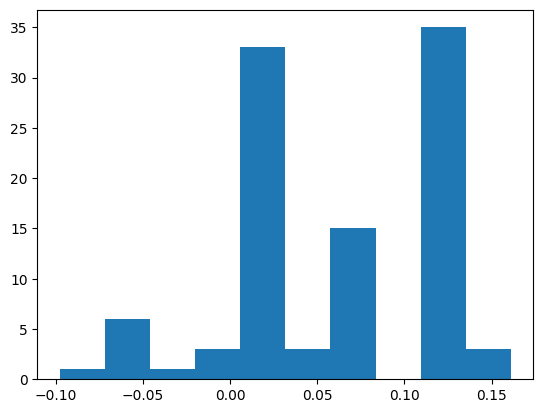

0.04860163
Minimum: -0.09750521
Q1 (First Quartile): 0.017858782910714282
Median: 0.06695455
Q3 (Third Quartile): 0.13443619
Maximum: 0.1610451
True
--------------------------


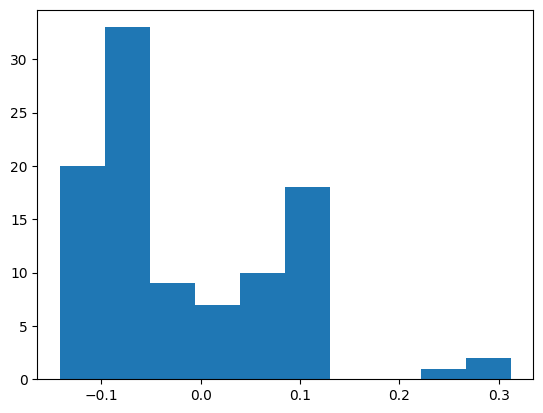

-0.082332104
Minimum: -0.14164317
Q1 (First Quartile): -0.08905247367857144
Median: -0.06605531637179488
Q3 (Third Quartile): 0.0634601275
Maximum: 0.3123142
True
--------------------------


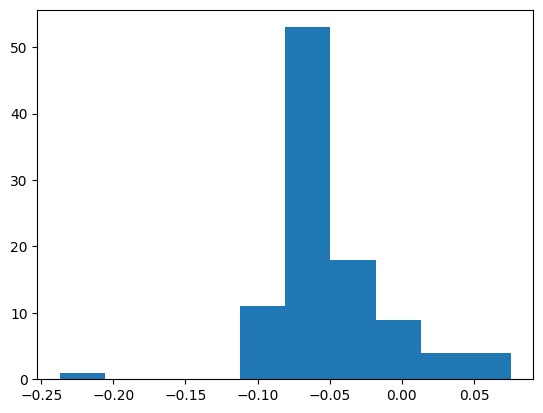

-0.04500598
Minimum: -0.23707876
Q1 (First Quartile): -0.06856368000588768
Median: -0.06028365
Q3 (Third Quartile): -0.040814250125
Maximum: 0.07553321
True
--------------------------


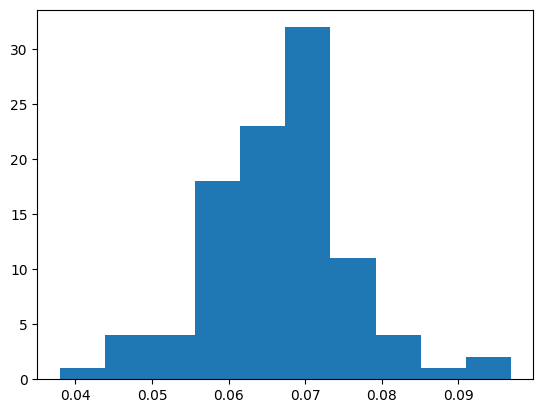

0.052158147
Minimum: 0.03798341112043796
Q1 (First Quartile): 0.06123445385159708
Median: 0.06731711632799495
Q3 (Third Quartile): 0.07207052137218033
Maximum: 0.0968389329272727
True
--------------------------


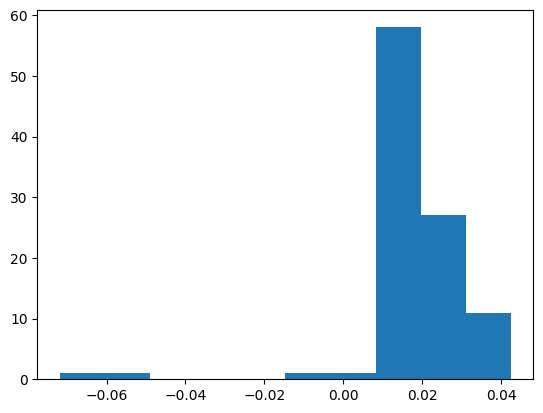

0.01137042
Minimum: -0.071809866
Q1 (First Quartile): 0.01504498574404762
Median: 0.01863530561428571
Q3 (Third Quartile): 0.025632184432785563
Maximum: 0.04240054320512821
True
--------------------------


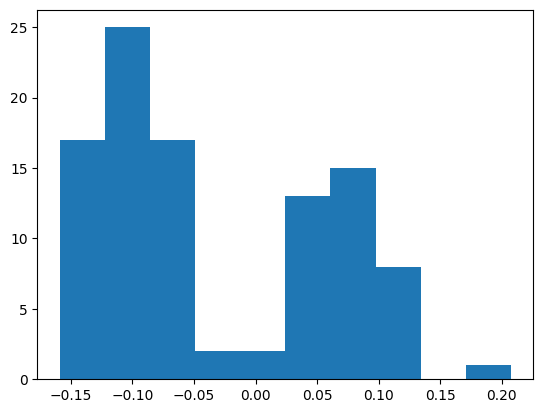

0.05651626
Minimum: -0.15887879
Q1 (First Quartile): -0.10894221535714287
Median: -0.07479122988054705
Q3 (Third Quartile): 0.0543009149
Maximum: 0.20719887
True
--------------------------


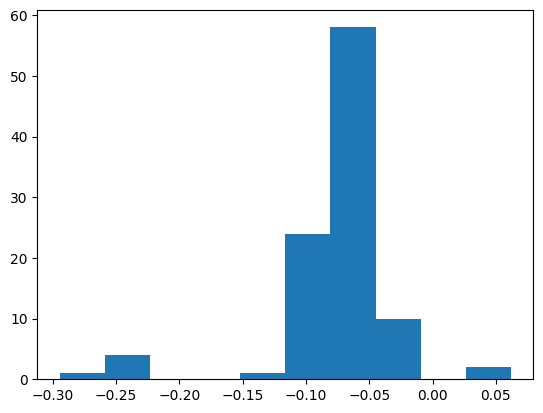

-0.115021974
Minimum: -0.29443255
Q1 (First Quartile): -0.08535427712160634
Median: -0.0697826876496212
Q3 (Third Quartile): -0.062729296405873
Maximum: 0.06182930333333333
True
--------------------------


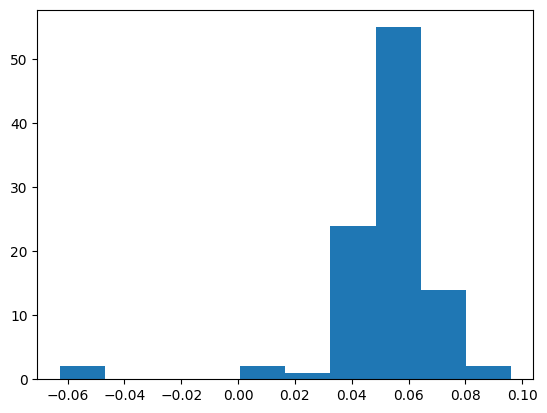

0.0563398
Minimum: -0.062693074
Q1 (First Quartile): 0.046746498206285125
Median: 0.05317895429359243
Q3 (Third Quartile): 0.06128201345401954
Maximum: 0.09600239666666666
True
--------------------------


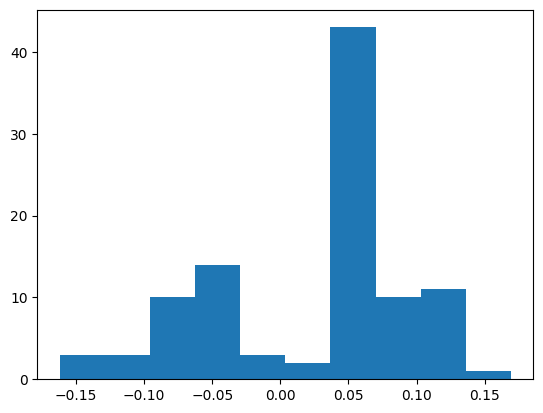

0.053305287
Minimum: -0.16175476333333333
Q1 (First Quartile): -0.04947719
Median: 0.050368602916666665
Q3 (Third Quartile): 0.06326758475000001
Maximum: 0.16911044425
True
--------------------------


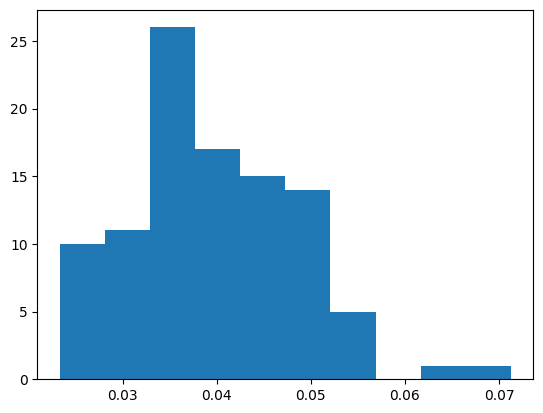

0.054281086
Minimum: 0.02331610653521127
Q1 (First Quartile): 0.0335741171922147
Median: 0.037960140687500005
Q3 (Third Quartile): 0.045709199788352264
Maximum: 0.0712510600078125
True
--------------------------


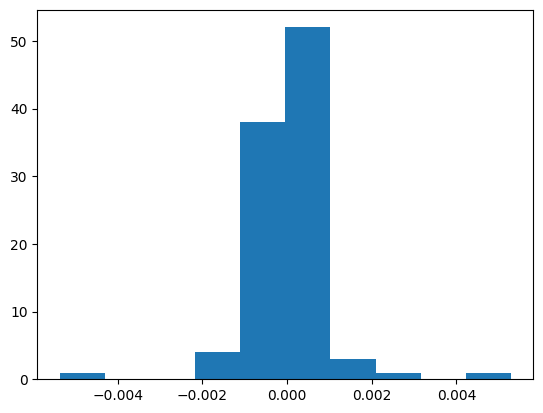

-0.00013170466
Minimum: -0.005360818763014704
Q1 (First Quartile): -0.0002454375189166666
Median: 1.84822584375e-05
Q3 (Third Quartile): 0.000148903575625
Maximum: 0.00528174327932653
True
--------------------------


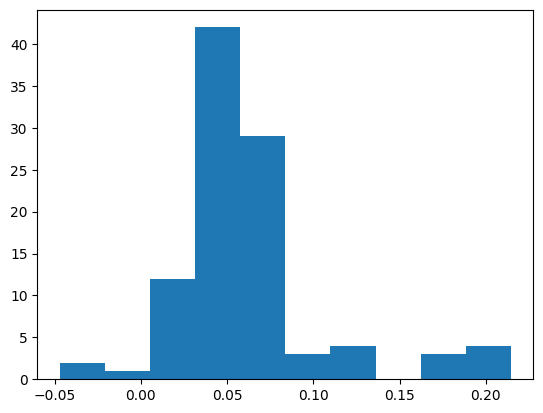

0.053385608
Minimum: -0.04693329
Q1 (First Quartile): 0.03847247184676348
Median: 0.054103151828703705
Q3 (Third Quartile): 0.06951343766063194
Maximum: 0.21448883
True
--------------------------


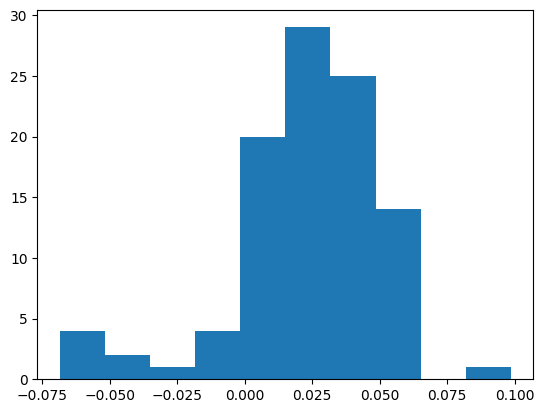

0.06346537
Minimum: -0.06841511367825807
Q1 (First Quartile): 0.013335673523468136
Median: 0.025531216433197914
Q3 (Third Quartile): 0.039768486544117645
Maximum: 0.09861558884615383
True
--------------------------


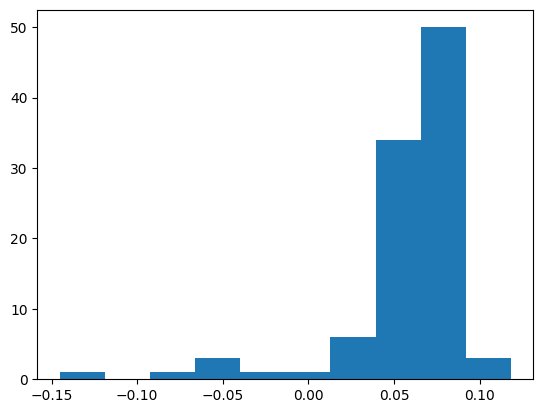

0.08726707
Minimum: -0.14514257
Q1 (First Quartile): 0.052906375172275644
Median: 0.06713903350152436
Q3 (Third Quartile): 0.07385583119763159
Maximum: 0.11815353
True
--------------------------


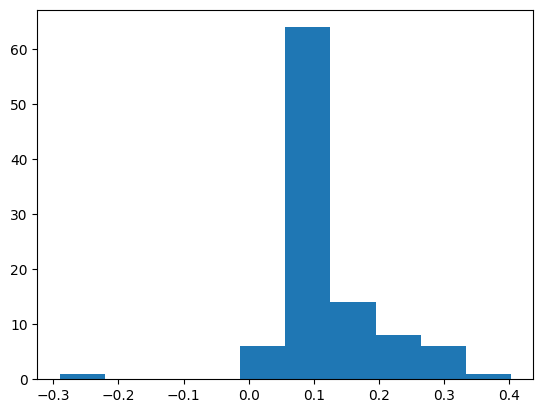

0.15240325
Minimum: -0.2900717333333333
Q1 (First Quartile): 0.07471050501659375
Median: 0.09601229198979593
Q3 (Third Quartile): 0.13744560162185354
Maximum: 0.40301746
True
--------------------------


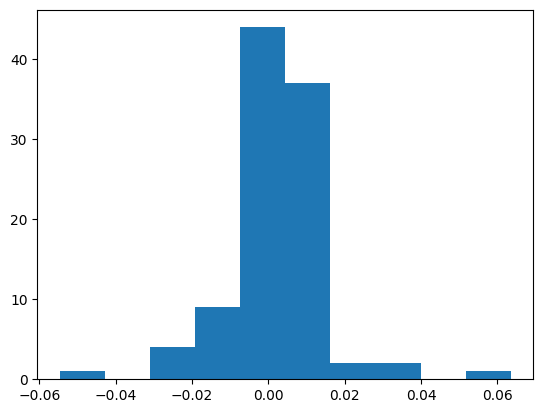

0.0078878105
Minimum: -0.054602765
Q1 (First Quartile): 0.0009721355052437956
Median: 0.0033653161829482053
Q3 (Third Quartile): 0.008709546387058823
Maximum: 0.06352538605555555
True
--------------------------


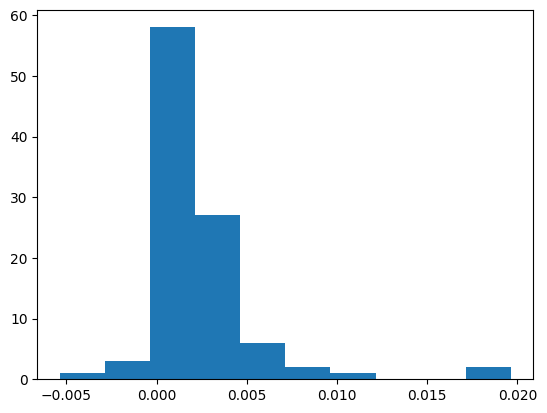

0.00012910366
Minimum: -0.005360818763014704
Q1 (First Quartile): 0.00042557150457371795
Median: 0.001323406668830688
Q3 (Third Quartile): 0.003301294067015734
Maximum: 0.019636853377865384
True
--------------------------


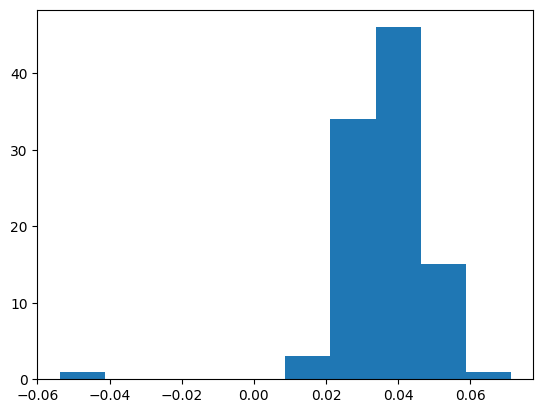

0.06038502
Minimum: -0.053769916
Q1 (First Quartile): 0.02984152145168067
Median: 0.03779686509046053
Q3 (Third Quartile): 0.04438254498535156
Maximum: 0.0712510600078125
True
--------------------------


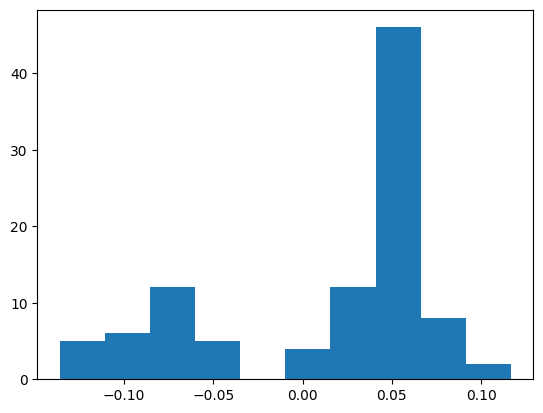

-0.074442044
Minimum: -0.13580634
Q1 (First Quartile): -0.05453101675
Median: 0.047082890475
Q3 (Third Quartile): 0.05397022449759615
Maximum: 0.11657813
True
--------------------------


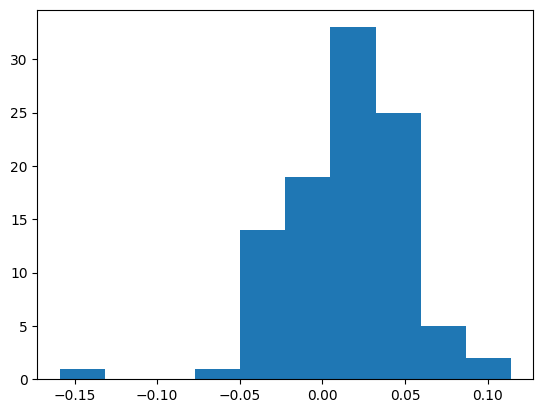

0.017603502
Minimum: -0.15887879
Q1 (First Quartile): -0.004357767281341615
Median: 0.02237172008333333
Q3 (Third Quartile): 0.040338758948660715
Maximum: 0.11405866999999999
True
--------------------------


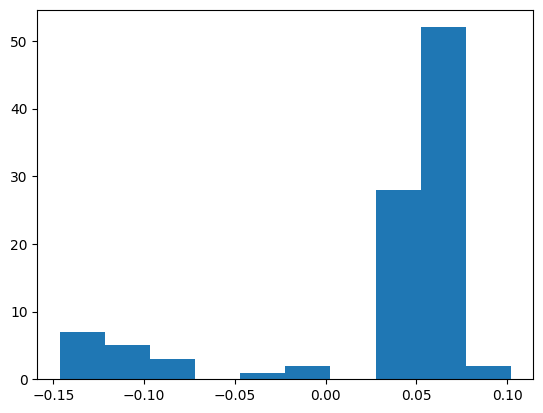

0.057424128
Minimum: -0.14639783
Q1 (First Quartile): 0.044679931221359104
Median: 0.05485082396041667
Q3 (Third Quartile): 0.06364131120800429
Maximum: 0.10203278
True
--------------------------


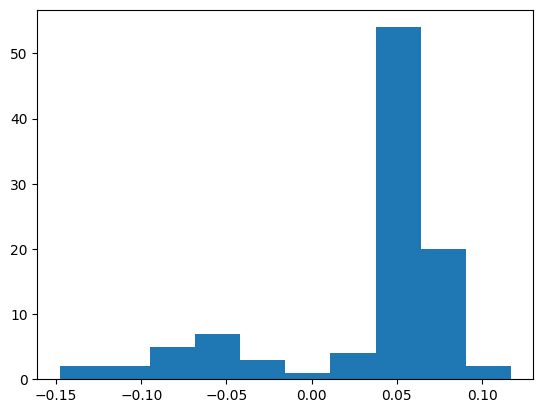

0.055138685
Minimum: -0.147781485
Q1 (First Quartile): 0.038465985855392154
Median: 0.05003681435
Q3 (Third Quartile): 0.06316181116666666
Maximum: 0.11687196
True
--------------------------


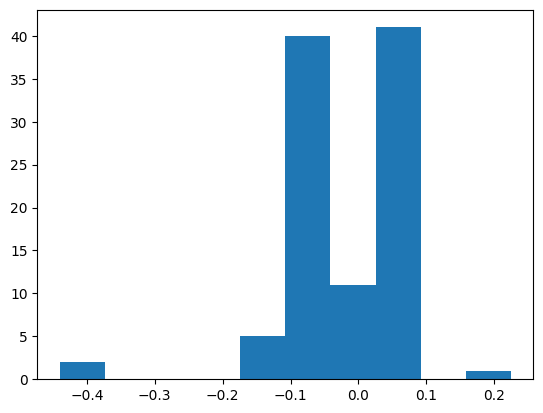

0.06030616
Minimum: -0.4397846
Q1 (First Quartile): -0.06865446001875
Median: -0.036221088
Q3 (Third Quartile): 0.05010381530291667
Maximum: 0.22448586
True
--------------------------


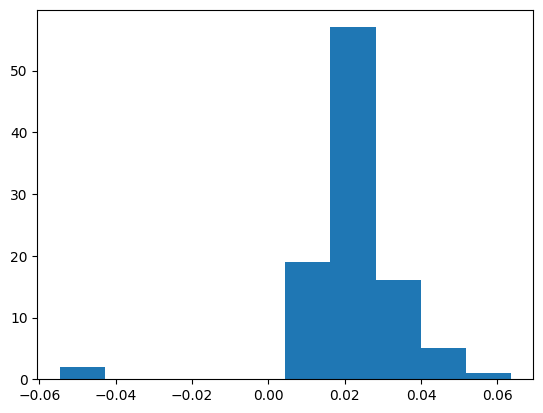

0.060024902
Minimum: -0.054602765
Q1 (First Quartile): 0.01682811801689189
Median: 0.019240322973502304
Q3 (Third Quartile): 0.026836396113337865
Maximum: 0.06352538605555555
True
--------------------------


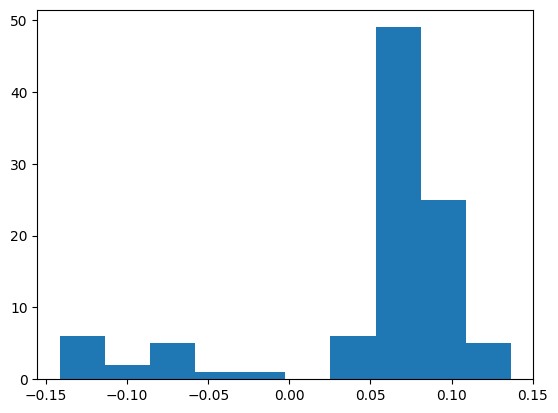

-0.14254183
Minimum: -0.14139342
Q1 (First Quartile): 0.05838441448434902
Median: 0.07129182818959395
Q3 (Third Quartile): 0.08154408636842107
Maximum: 0.1365448
False
--------------------------


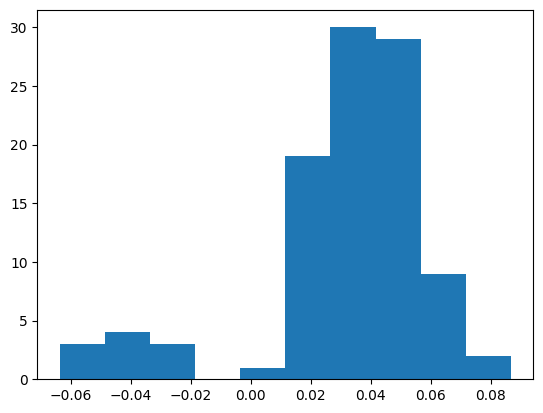

0.046590835
Minimum: -0.063635804
Q1 (First Quartile): 0.024273622737500004
Median: 0.0363819799233871
Q3 (Third Quartile): 0.046643962922794116
Maximum: 0.08662616
True
--------------------------


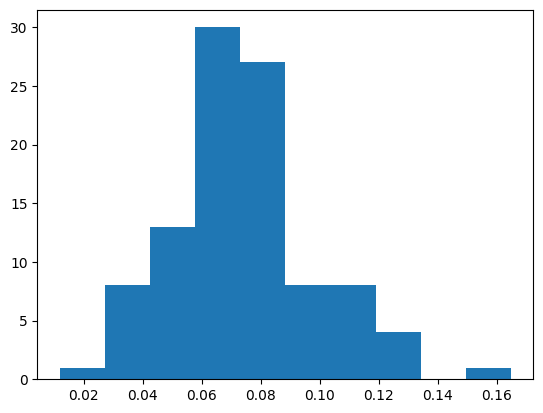

0.07031362
Minimum: 0.011976426185092159
Q1 (First Quartile): 0.06143155445974577
Median: 0.07227993164236364
Q3 (Third Quartile): 0.08195166391178228
Maximum: 0.16480006
True
--------------------------


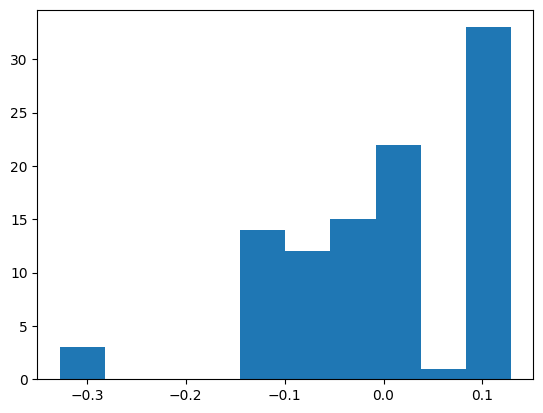

0.007163912
Minimum: -0.327262
Q1 (First Quartile): -0.06064705883333334
Median: -0.0005733967
Q3 (Third Quartile): 0.09448922
Maximum: 0.12866214
True
--------------------------


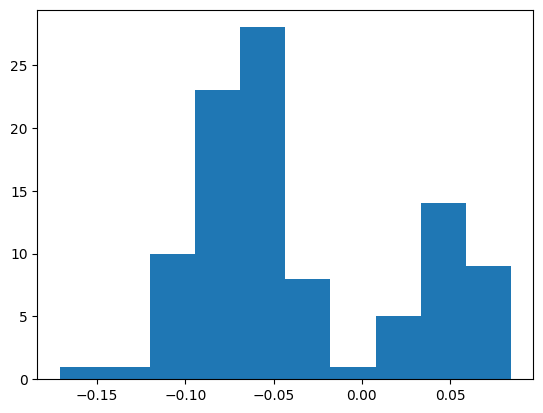

-0.080948606
Minimum: -0.17100567
Q1 (First Quartile): -0.07860645784146342
Median: -0.0581515
Q3 (Third Quartile): 0.025318556924242425
Maximum: 0.08438210666666666
True
--------------------------


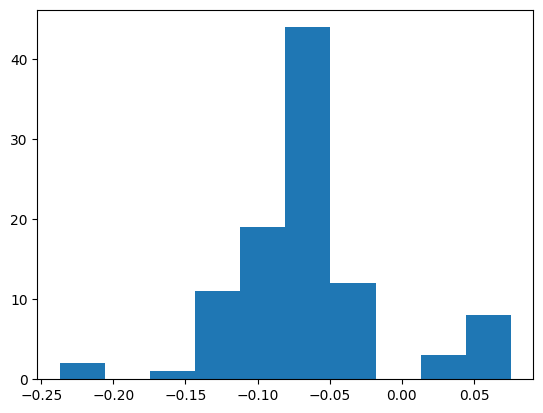

-0.10506819
Minimum: -0.23707876
Q1 (First Quartile): -0.09310990125
Median: -0.0705888240900974
Q3 (Third Quartile): -0.05185082637987014
Maximum: 0.07553321
True
--------------------------


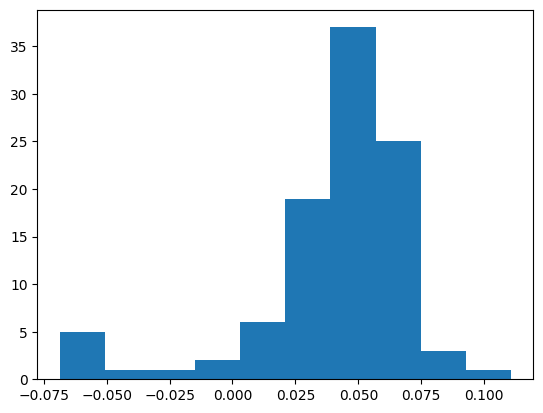

0.08724742
Minimum: -0.06856256
Q1 (First Quartile): 0.0348498513777811
Median: 0.04791315503777778
Q3 (Third Quartile): 0.05976834856779662
Maximum: 0.11057241666666666
True
--------------------------


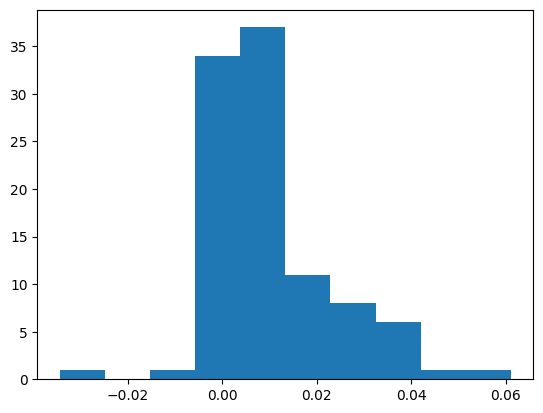

0.0041427584
Minimum: -0.0343698637
Q1 (First Quartile): 0.0028109339
Median: 0.007794916955317187
Q3 (Third Quartile): 0.013556937453995194
Maximum: 0.06102054775
True
--------------------------


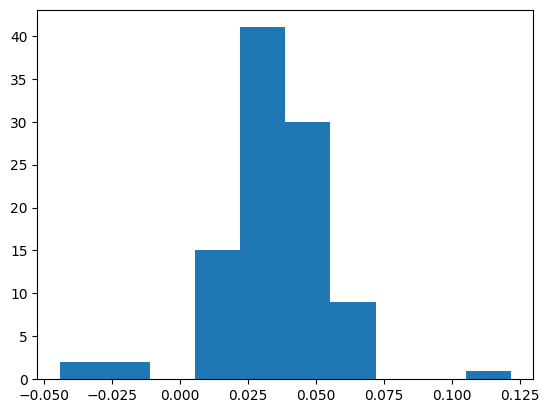

0.02094056
Minimum: -0.04399648
Q1 (First Quartile): 0.026468352924242423
Median: 0.037120059166666663
Q3 (Third Quartile): 0.04368545559102434
Maximum: 0.1217741
True
--------------------------


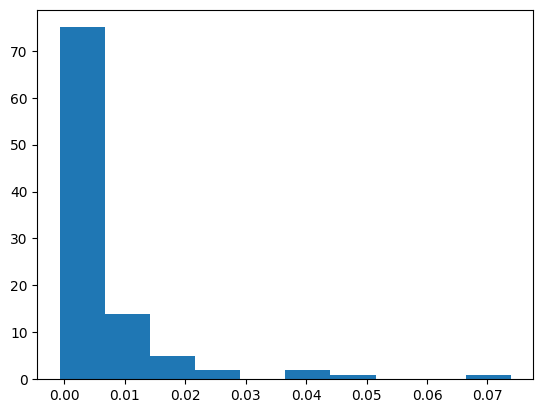

0.00022088617
Minimum: -0.0007083233774642858
Q1 (First Quartile): 0.0002114792285879032
Median: 0.0014967868954222222
Q3 (Third Quartile): 0.006614416456034375
Maximum: 0.07385381933333333
True
--------------------------


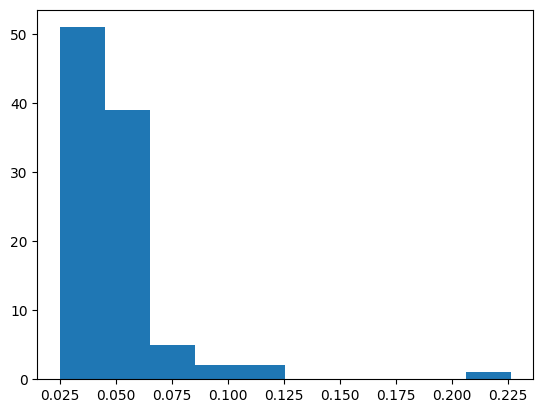

0.053626988
Minimum: 0.024825163847222217
Q1 (First Quartile): 0.03737884654520148
Median: 0.04478342409482759
Q3 (Third Quartile): 0.050238108540441175
Maximum: 0.22618708
True
--------------------------


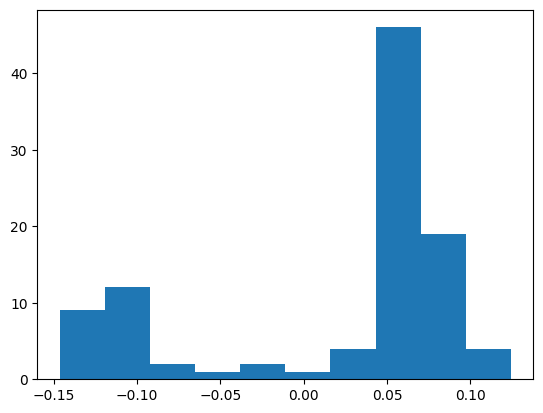

0.0760088
Minimum: -0.14639783
Q1 (First Quartile): -0.01639115375
Median: 0.058247837667511515
Q3 (Third Quartile): 0.0687396088576786
Maximum: 0.12426804980000002
True
--------------------------


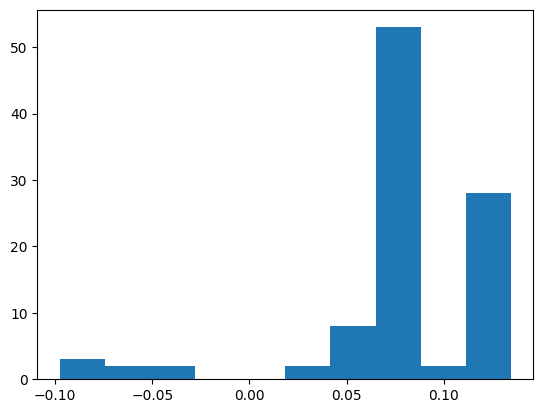

0.20942047
Minimum: -0.09750521
Q1 (First Quartile): 0.06695455
Median: 0.074146494
Q3 (Third Quartile): 0.1210754445
Maximum: 0.13443619
False
--------------------------


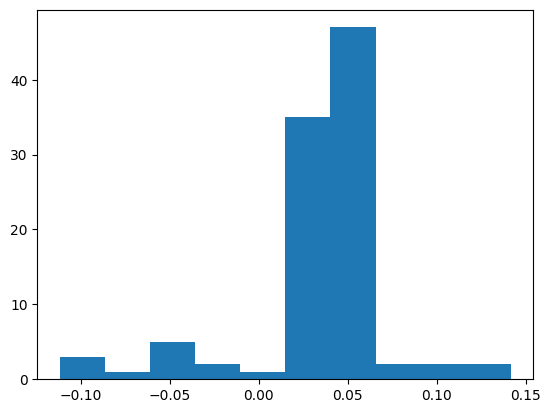

0.0655044
Minimum: -0.11157219
Q1 (First Quartile): 0.03632132521654854
Median: 0.04107532398214286
Q3 (Third Quartile): 0.05051822440178573
Maximum: 0.14148808
True
--------------------------


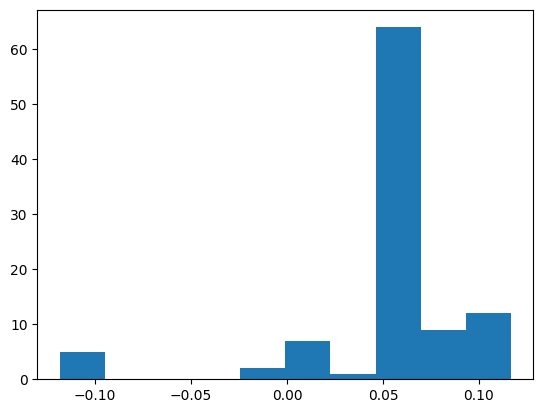

0.06291771
Minimum: -0.11833875
Q1 (First Quartile): 0.05172300465
Median: 0.057813843690476194
Q3 (Third Quartile): 0.06492091062500001
Maximum: 0.11657813
True
--------------------------


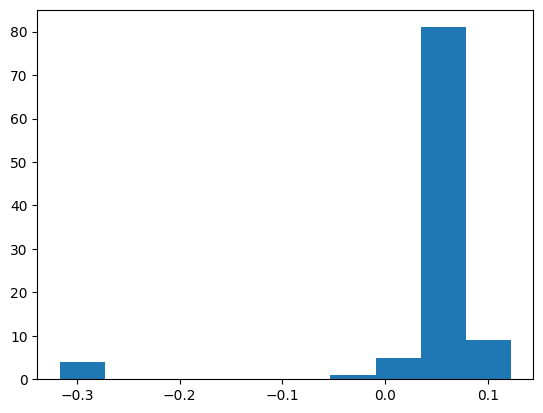

0.059884578
Minimum: -0.31655174
Q1 (First Quartile): 0.05868214437774926
Median: 0.06642785225001548
Q3 (Third Quartile): 0.0719805517571364
Maximum: 0.12241788607142857
True
--------------------------


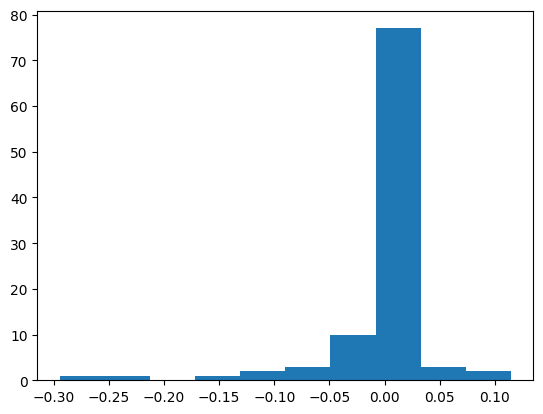

-0.032774314
Minimum: -0.29443255
Q1 (First Quartile): -0.0064453827
Median: -0.0017802894000000001
Q3 (Third Quartile): 0.0015536845
Maximum: 0.11438987
True
--------------------------


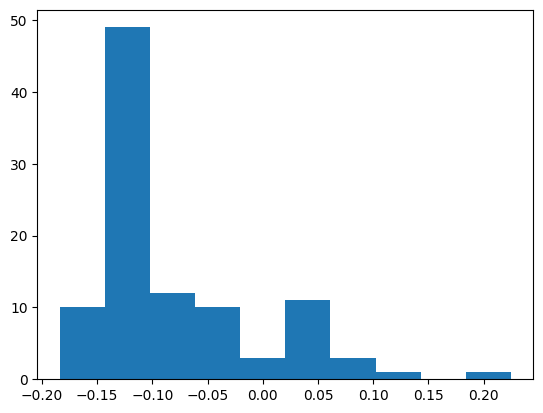

0.035909027
Minimum: -0.18358667
Q1 (First Quartile): -0.12445611179411764
Median: -0.108081065
Q3 (Third Quartile): -0.05287681641875
Maximum: 0.22448586
True
--------------------------


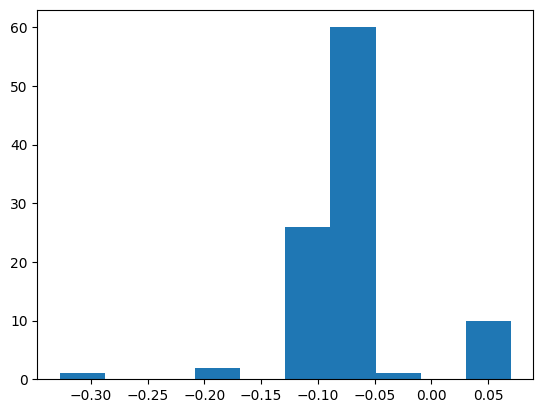

-0.10923739
Minimum: -0.327262
Q1 (First Quartile): -0.08955099375
Median: -0.07864681089914305
Q3 (Third Quartile): -0.06668360765968749
Maximum: 0.07002038
True
--------------------------


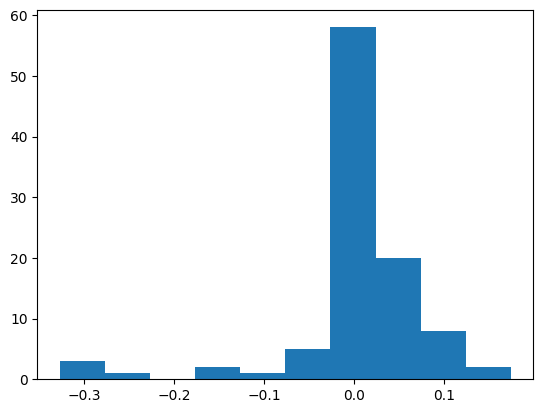

0.017384976
Minimum: -0.327262
Q1 (First Quartile): 1.2822133e-05
Median: 0.008629100182500002
Q3 (Third Quartile): 0.02992410547372573
Maximum: 0.17377096
True
--------------------------


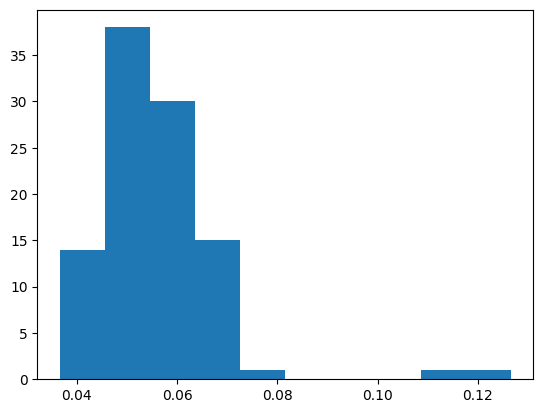

0.04863903
Minimum: 0.03660275257142858
Q1 (First Quartile): 0.04839096951199495
Median: 0.0533585785997574
Q3 (Third Quartile): 0.06160619952716974
Maximum: 0.12660560599999998
True
--------------------------


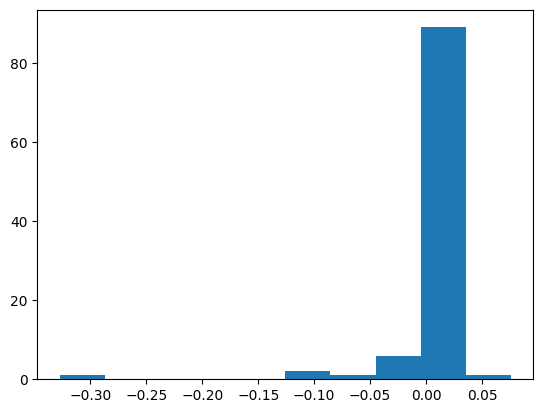

0.0006637573
Minimum: -0.327262
Q1 (First Quartile): 4.4347042797909626e-05
Median: 0.0007067476412658728
Q3 (Third Quartile): 0.0029460633549714937
Maximum: 0.07573843
True
--------------------------


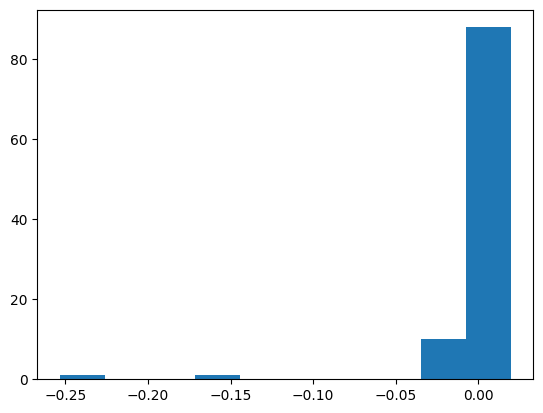

-0.00017880026
Minimum: -0.25327846
Q1 (First Quartile): -0.0002109395134843752
Median: 0.000553783053830303
Q3 (Third Quartile): 0.0025250873304870935
Maximum: 0.019636853377865384
True
--------------------------


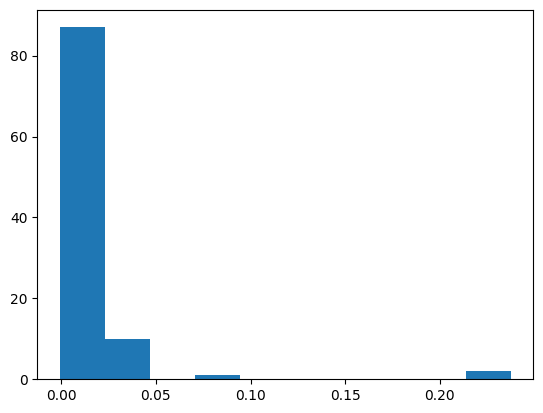

0.00010162845
Minimum: -0.0007083233774642858
Q1 (First Quartile): 0.00021354638128384917
Median: 0.001772741703232408
Q3 (Third Quartile): 0.011011244664884297
Maximum: 0.23745242
True
--------------------------


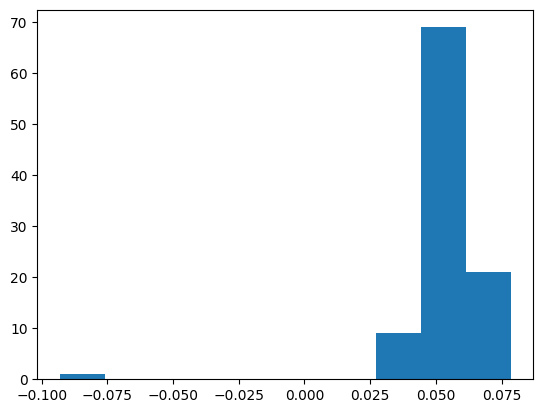

0.060150206
Minimum: -0.09310900933333334
Q1 (First Quartile): 0.0483393628286205
Median: 0.053239732291573263
Q3 (Third Quartile): 0.061230692023259654
Maximum: 0.07853731331147541
True
--------------------------


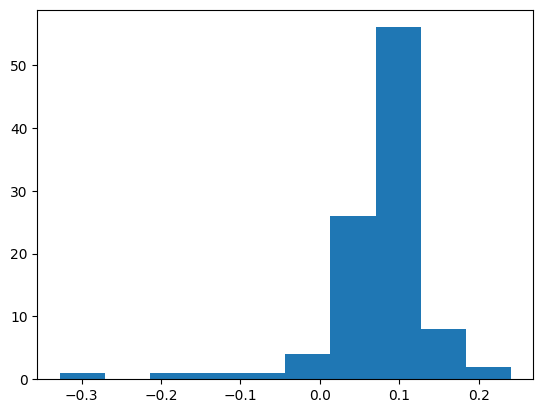

0.08415121
Minimum: -0.327262
Q1 (First Quartile): 0.0662366586845238
Median: 0.07880748891286093
Q3 (Third Quartile): 0.0990662645735294
Maximum: 0.2404426
True
--------------------------


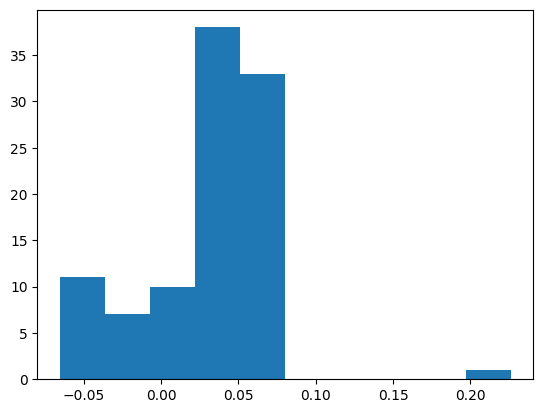

0.032064505
Minimum: -0.06546462391249999
Q1 (First Quartile): 0.018558979465048593
Median: 0.04125682
Q3 (Third Quartile): 0.05724419896984649
Maximum: 0.22618708
True
--------------------------


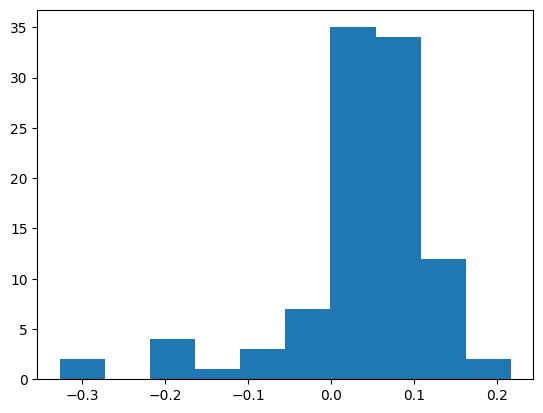

0.0011459142
Minimum: -0.327262
Q1 (First Quartile): 0.0022614756639986844
Median: 0.048179143305342745
Q3 (Third Quartile): 0.08195166391178228
Maximum: 0.21714658
True
--------------------------


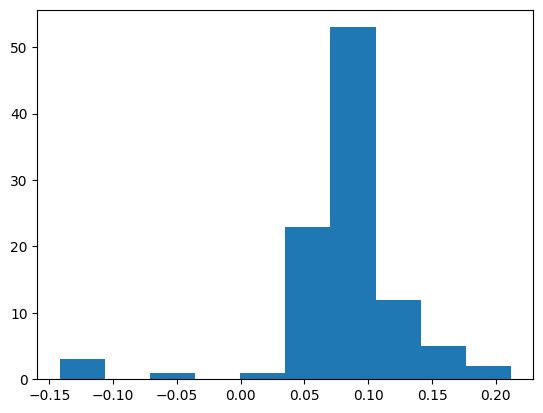

0.11022475
Minimum: -0.14164317
Q1 (First Quartile): 0.06849942356120567
Median: 0.08109232306923889
Q3 (Third Quartile): 0.09805822189560809
Maximum: 0.21167651466666665
True
--------------------------


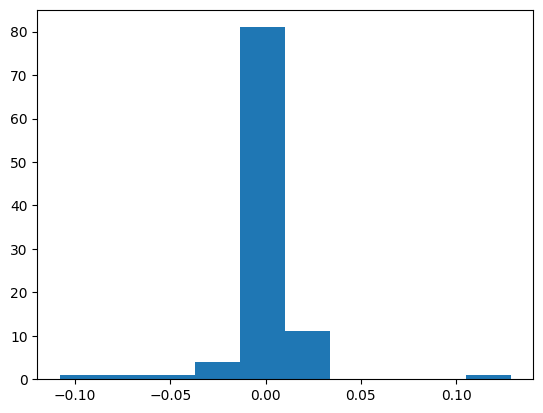

-0.0006018745
Minimum: -0.107920304
Q1 (First Quartile): -0.0007071792225
Median: -2.2568416904545447e-05
Q3 (Third Quartile): 0.002887159988273387
Maximum: 0.12866214
True
--------------------------


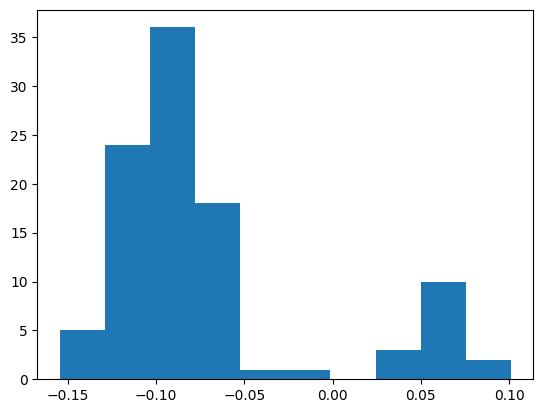

-0.06255852
Minimum: -0.15443241444444444
Q1 (First Quartile): -0.10589531770833335
Median: -0.0877352327
Q3 (Third Quartile): -0.06610987341749999
Maximum: 0.10091861666666667
True
--------------------------


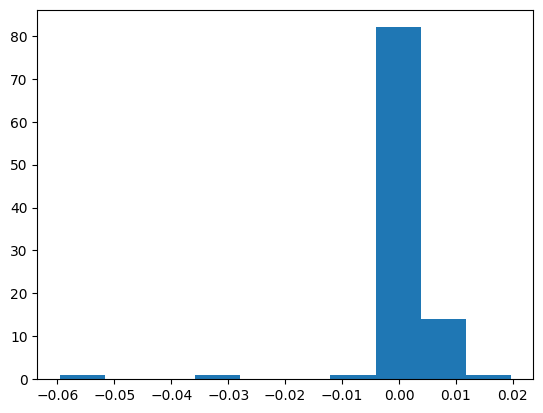

2.7907075e-05
Minimum: -0.059569534
Q1 (First Quartile): 0.0003430706445589569
Median: 0.0011174839674879826
Q3 (Third Quartile): 0.0029705164885203347
Maximum: 0.019636853377865384
True
--------------------------


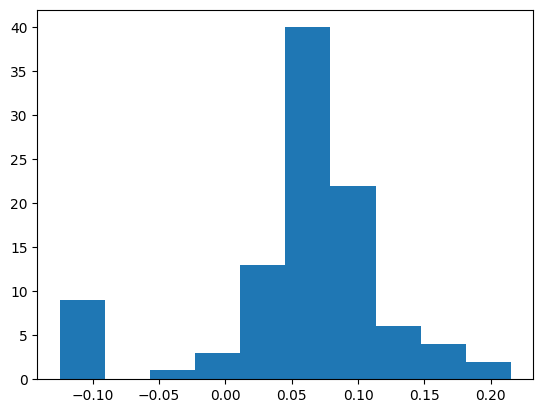

0.1476652
Minimum: -0.12480098
Q1 (First Quartile): 0.0448156746165863
Median: 0.06914901804192547
Q3 (Third Quartile): 0.08740183307291666
Maximum: 0.21515149
True
--------------------------


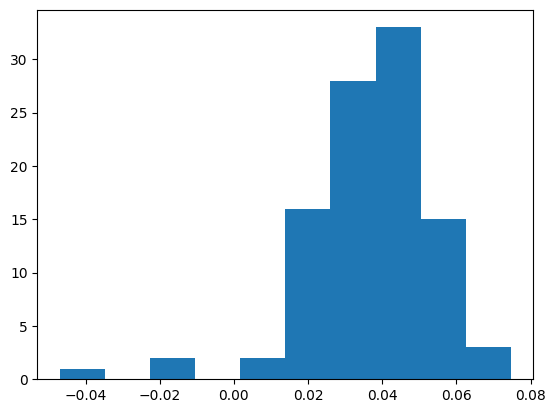

0.03586665
Minimum: -0.046933289999999996
Q1 (First Quartile): 0.028391607047819473
Median: 0.03856333009058579
Q3 (Third Quartile): 0.046106274857276634
Maximum: 0.07466180505714289
True
--------------------------


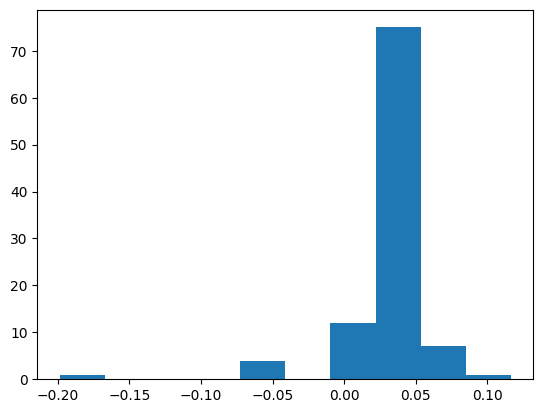

0.049281985
Minimum: -0.19866286
Q1 (First Quartile): 0.027736871865196078
Median: 0.03483968620995671
Q3 (Third Quartile): 0.042151698301282056
Maximum: 0.11657813
True
--------------------------


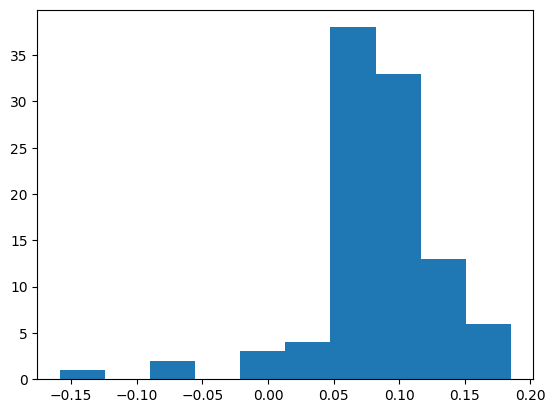

0.085741356
Minimum: -0.1585351866666667
Q1 (First Quartile): 0.0711816340964391
Median: 0.08246255774561403
Q3 (Third Quartile): 0.10820765553191743
Maximum: 0.18506745
True
--------------------------


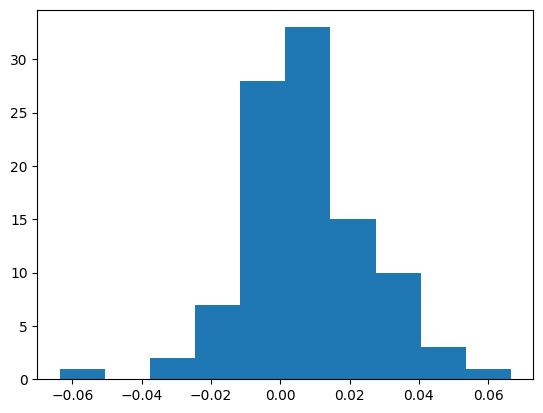

-0.014246954
Minimum: -0.063635804
Q1 (First Quartile): -0.0008094257162923913
Median: 0.008725255693289476
Q3 (Third Quartile): 0.015835946915624996
Maximum: 0.06652388
True
--------------------------


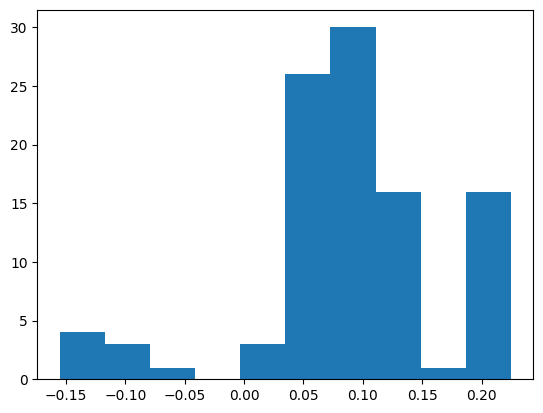

0.17454535
Minimum: -0.15502746473684212
Q1 (First Quartile): 0.061468076035024154
Median: 0.08670835616666667
Q3 (Third Quartile): 0.11476140936885246
Maximum: 0.22448586
True
--------------------------


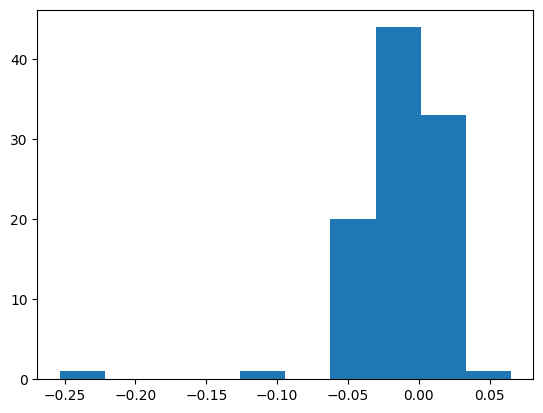

-0.004465663
Minimum: -0.25327846
Q1 (First Quartile): -0.008307602126685484
Median: 0.00034981763917346935
Q3 (Third Quartile): 0.002619098545558823
Maximum: 0.06481981
True
--------------------------


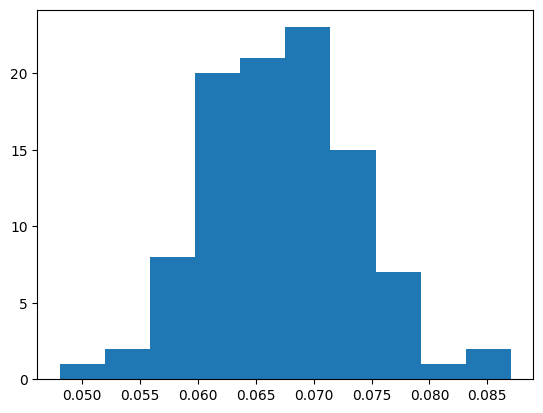

0.116745114
Minimum: 0.0480630397
Q1 (First Quartile): 0.062442794680079336
Median: 0.06729211769355337
Q3 (Third Quartile): 0.07152872034006885
Maximum: 0.08702658999999999
False
--------------------------


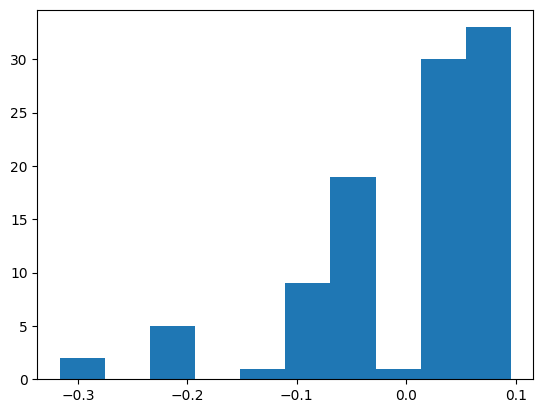

0.05066605
Minimum: -0.31655174
Q1 (First Quartile): -0.0615689
Median: 0.04064037366666666
Q3 (Third Quartile): 0.061911940426526715
Maximum: 0.09554354375
True
--------------------------


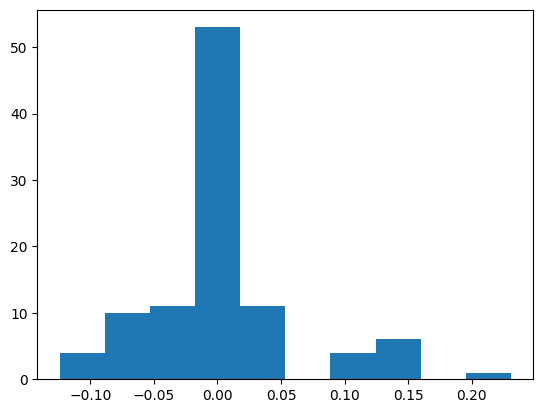

-0.0106162075
Minimum: -0.12388265
Q1 (First Quartile): -0.015925206253125
Median: -0.00589817185
Q3 (Third Quartile): 0.003534637325
Maximum: 0.23074877
True
--------------------------


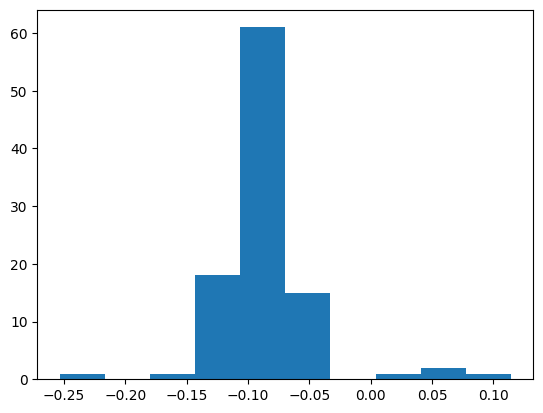

-0.114656866
Minimum: -0.25327846
Q1 (First Quartile): -0.100024223
Median: -0.08501199458708272
Q3 (Third Quartile): -0.07330146456452968
Maximum: 0.11422427
True
--------------------------


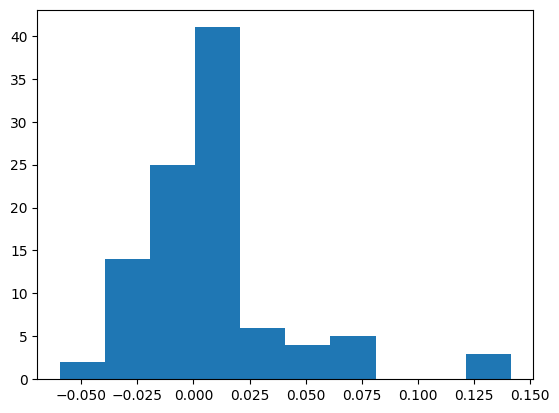

0.001314044
Minimum: -0.059569534
Q1 (First Quartile): -0.0013116334895134168
Median: 0.0015259182906484851
Q3 (Third Quartile): 0.0118137225
Maximum: 0.14148808
True
--------------------------


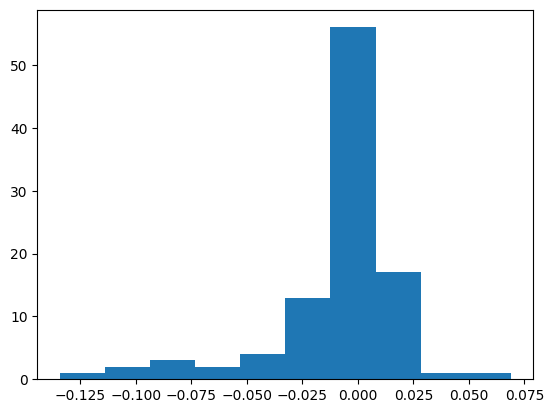

-0.019850748
Minimum: -0.1341429
Q1 (First Quartile): -0.011467532678296704
Median: -0.006249169702083333
Q3 (Third Quartile): 0.0009681851278802843
Maximum: 0.06885569
True
--------------------------


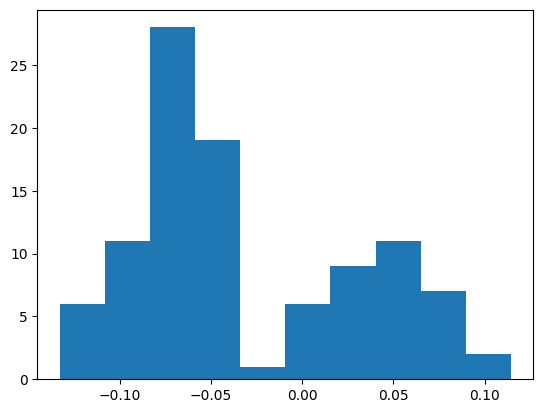

0.0407663
Minimum: -0.13295135
Q1 (First Quartile): -0.07877900588682432
Median: -0.053764506249999997
Q3 (Third Quartile): 0.029901600977941176
Maximum: 0.11438987
True
--------------------------


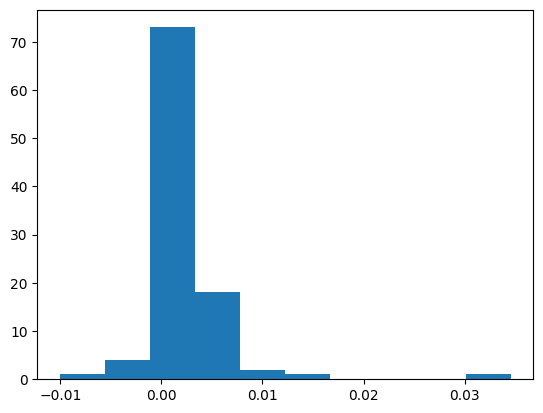

3.1650066e-05
Minimum: -0.010052016924857144
Q1 (First Quartile): 0.0003083127975351247
Median: 0.0011174839674879826
Q3 (Third Quartile): 0.0031557077227178034
Maximum: 0.03457482367585185
True
--------------------------


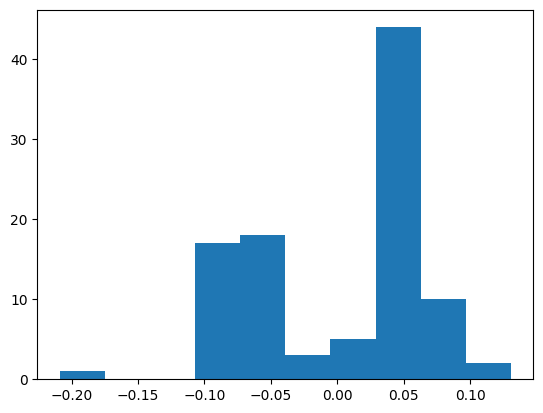

-0.06661458
Minimum: -0.2088615
Q1 (First Quartile): -0.0615689
Median: 0.035011763334444446
Q3 (Third Quartile): 0.055130504916471965
Maximum: 0.13072313
True
--------------------------


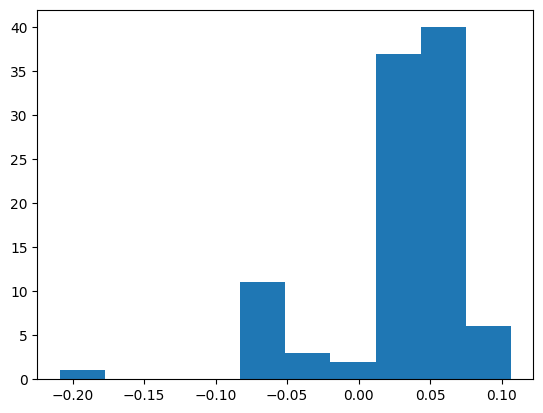

0.057607807
Minimum: -0.2088615
Q1 (First Quartile): 0.024436863672640842
Median: 0.04077756223190789
Q3 (Third Quartile): 0.05474031371489362
Maximum: 0.10649459315789472
True
--------------------------


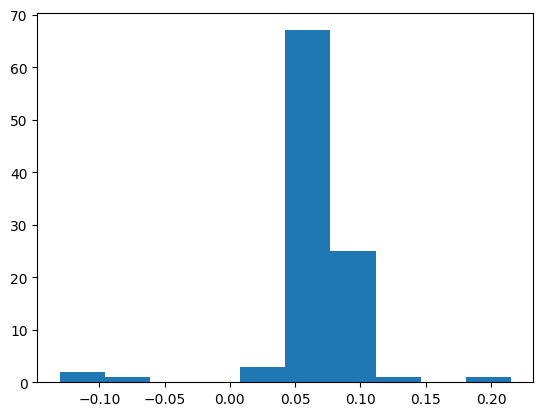

0.04309395
Minimum: -0.13019139
Q1 (First Quartile): 0.06595632921659482
Median: 0.07192059083771848
Q3 (Third Quartile): 0.07752787805770942
Maximum: 0.21515149
True
--------------------------


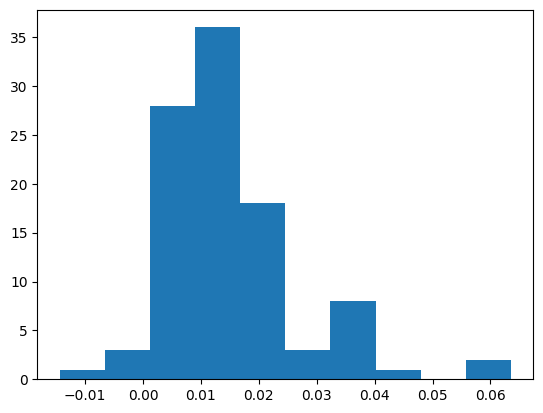

0.008333591
Minimum: -0.01436527
Q1 (First Quartile): 0.007718961142975782
Median: 0.01267295248730159
Q3 (Third Quartile): 0.019613070628968252
Maximum: 0.06352538605555555
True
--------------------------


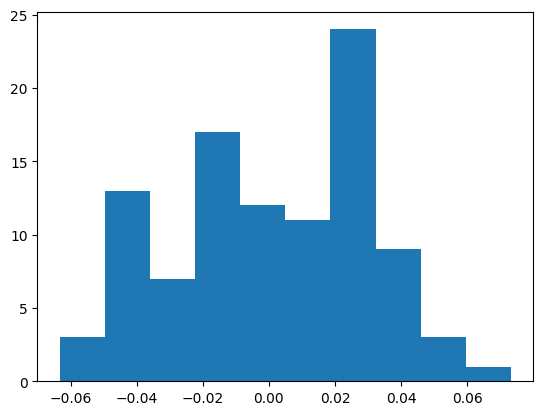

0.026026083
Minimum: -0.063215256
Q1 (First Quartile): -0.02198896
Median: 0.0013362408516483636
Q3 (Third Quartile): 0.0273861785
Maximum: 0.073159207
True
--------------------------


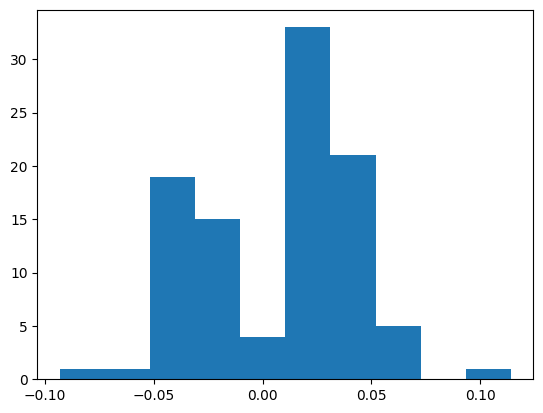

0.022273747
Minimum: -0.0931177
Q1 (First Quartile): -0.02804036
Median: 0.019466502749999996
Q3 (Third Quartile): 0.03603776621078431
Maximum: 0.11405867
True
--------------------------


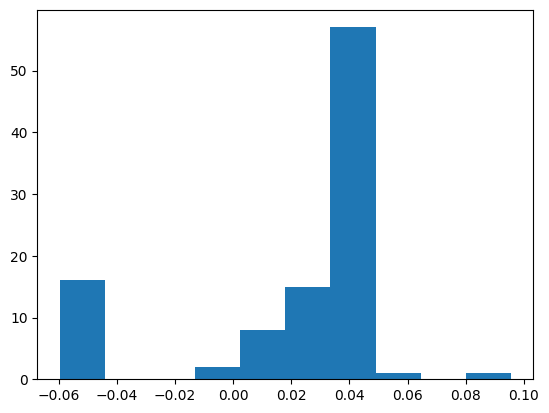

0.027529895
Minimum: -0.059569534
Q1 (First Quartile): 0.01682811801689189
Median: 0.0388664702
Q3 (Third Quartile): 0.042544452513157895
Maximum: 0.09546894
True
--------------------------


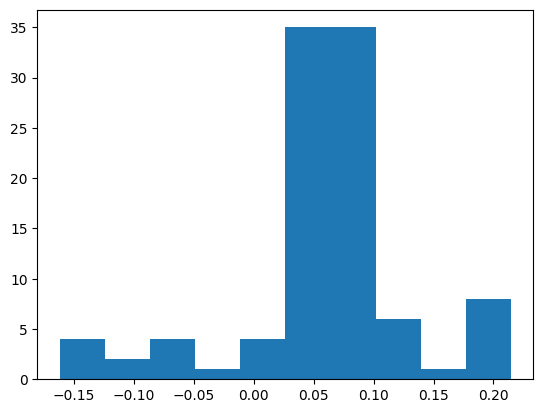

0.039375275
Minimum: -0.16191051
Q1 (First Quartile): 0.04923220690625
Median: 0.06356662885714286
Q3 (Third Quartile): 0.08576493
Maximum: 0.21448883
True
--------------------------


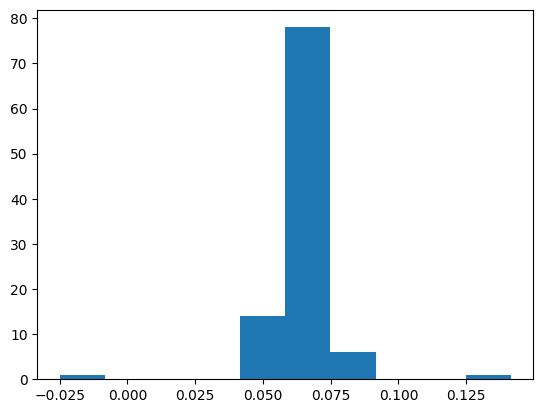

0.06689352
Minimum: -0.0249341782
Q1 (First Quartile): 0.060540053447626425
Median: 0.06442453156434447
Q3 (Third Quartile): 0.07021129585190217
Maximum: 0.14148808
True
--------------------------


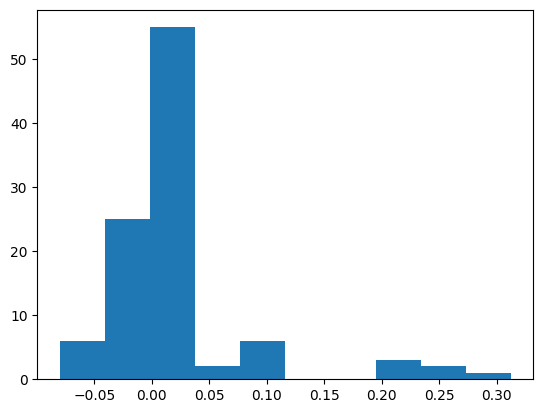

1.2889155e-05
Minimum: -0.07980949625
Q1 (First Quartile): -0.0014653925
Median: -0.00014810363
Q3 (Third Quartile): 0.002205396659637773
Maximum: 0.3123142
True
--------------------------


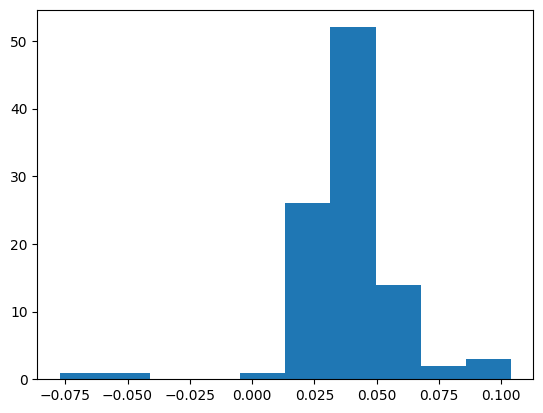

0.050946772
Minimum: -0.07715576685714286
Q1 (First Quartile): 0.03069362149182809
Median: 0.037561882053775746
Q3 (Third Quartile): 0.04807494603124999
Maximum: 0.10388255
True
--------------------------


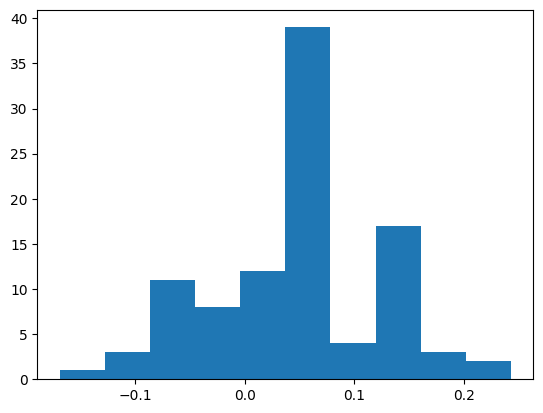

0.094793044
Minimum: -0.16863105
Q1 (First Quartile): -0.00058530413
Median: 0.06695455
Q3 (Third Quartile): 0.0788082215
Maximum: 0.24306695
True
--------------------------


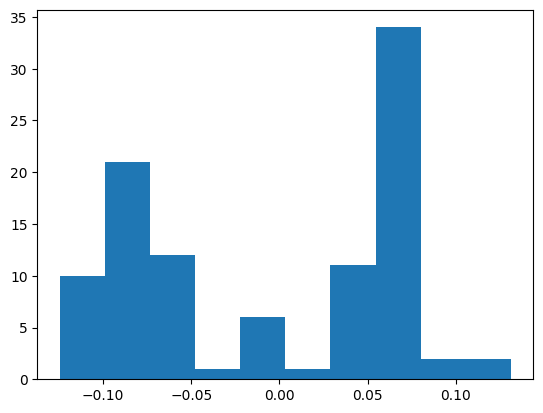

-0.08836019
Minimum: -0.124577428125
Q1 (First Quartile): -0.07845791295833332
Median: 0.005567710250000002
Q3 (Third Quartile): 0.06411940792442812
Maximum: 0.13125113
True
--------------------------


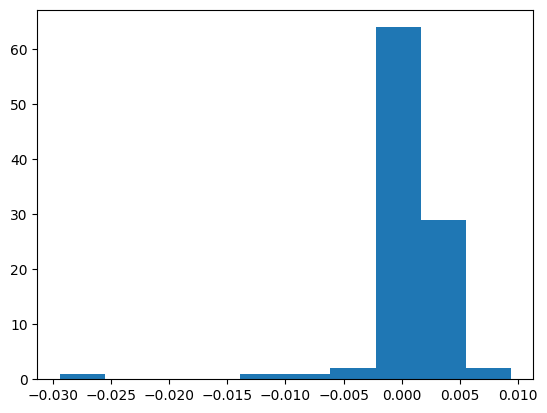

7.3880234e-05
Minimum: -0.029383958937600003
Q1 (First Quartile): 0.000173075887885468
Median: 0.0008524400607039474
Q3 (Third Quartile): 0.002265314857039447
Maximum: 0.009377547739059525
True
--------------------------


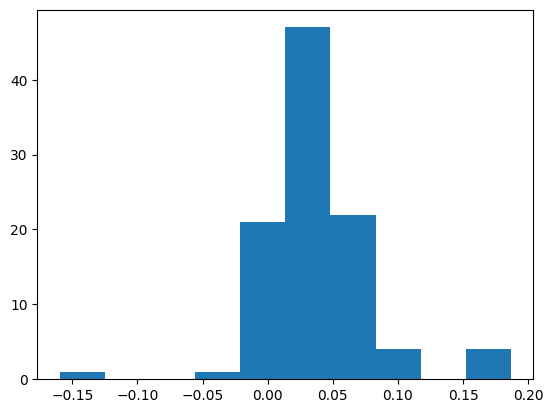

0.045266934
Minimum: -0.159467468
Q1 (First Quartile): 0.01500555408598901
Median: 0.030233397250000002
Q3 (Third Quartile): 0.057391439725
Maximum: 0.18660437
True
--------------------------


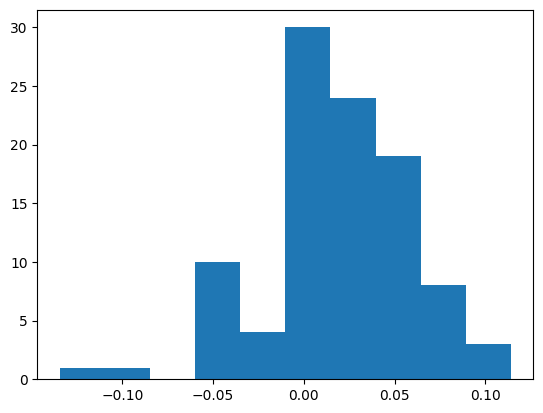

-0.017478056
Minimum: -0.13445097
Q1 (First Quartile): -0.00321626761428125
Median: 0.017461369187852942
Q3 (Third Quartile): 0.042793798
Maximum: 0.11405867
True
--------------------------


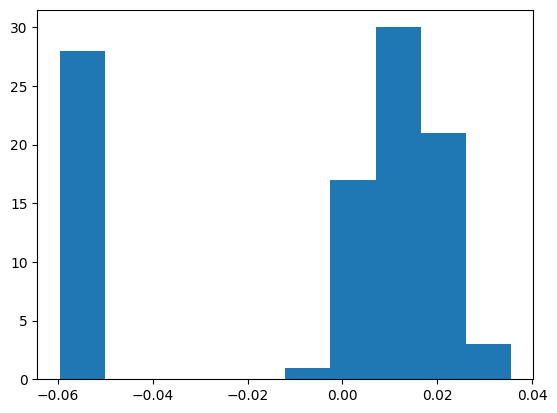

0.01856964
Minimum: -0.059569534
Q1 (First Quartile): -0.05089905
Median: 0.009261343013647411
Q3 (Third Quartile): 0.016365270083333334
Maximum: 0.0354770431519084
True
--------------------------


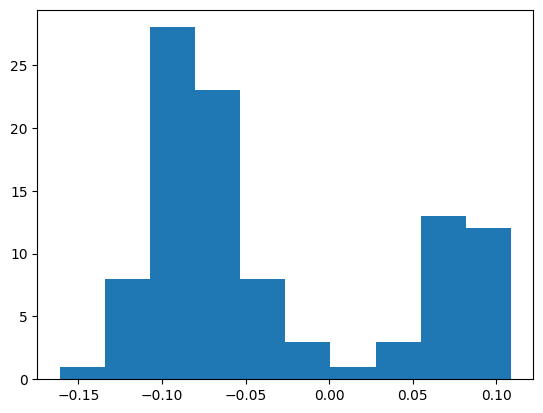

-0.07712743
Minimum: -0.161112
Q1 (First Quartile): -0.088657975
Median: -0.06254137789583333
Q3 (Third Quartile): 0.05205222775
Maximum: 0.10857057
True
--------------------------


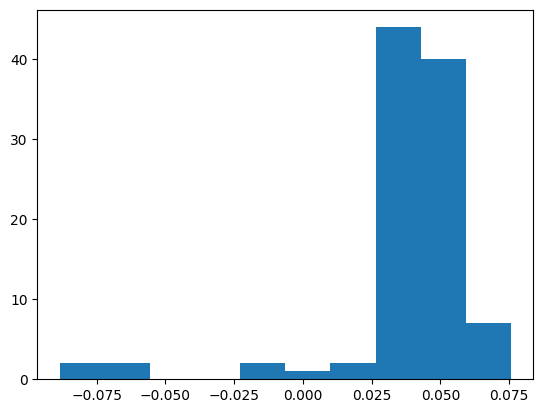

0.04438865
Minimum: -0.08838782
Q1 (First Quartile): 0.0354688714614313
Median: 0.041962680833333335
Q3 (Third Quartile): 0.04802555061555232
Maximum: 0.07563770826315792
True
--------------------------


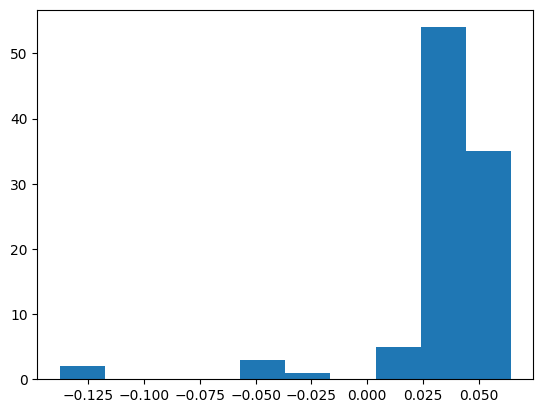

-0.040060684
Minimum: -0.137808
Q1 (First Quartile): 0.03429843043817568
Median: 0.03953651699403446
Q3 (Third Quartile): 0.04746038994935345
Maximum: 0.06448285370370371
True
--------------------------


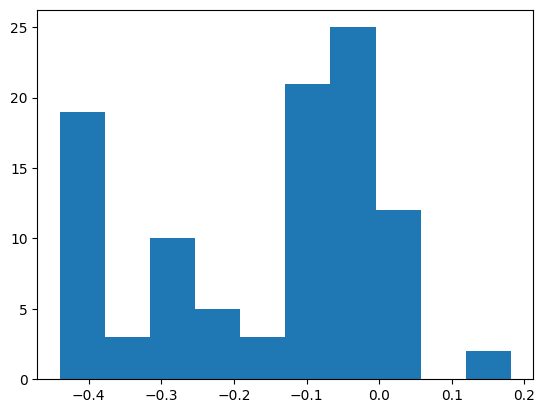

-0.035523288
Minimum: -0.4397846
Q1 (First Quartile): -0.29443255
Median: -0.09429087153333335
Q3 (Third Quartile): -0.02739036
Maximum: 0.18125486
True
--------------------------


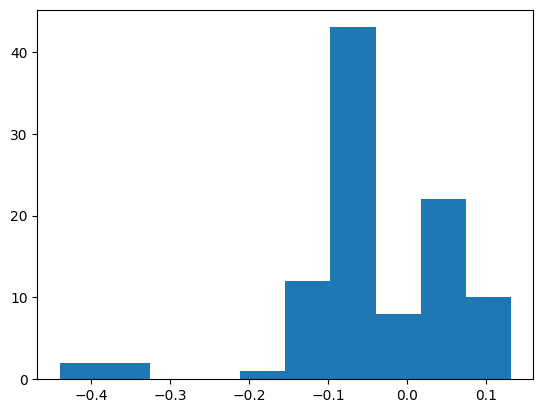

-0.042984813
Minimum: -0.4397846
Q1 (First Quartile): -0.08839822346551723
Median: -0.0581515
Q3 (Third Quartile): 0.042041620249999995
Maximum: 0.13080737
True
--------------------------


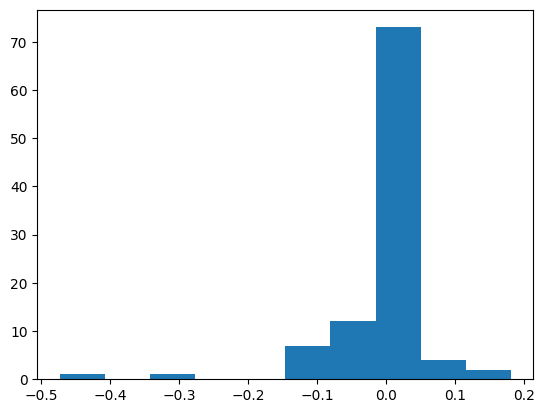

-0.014783877
Minimum: -0.47288948
Q1 (First Quartile): -0.0077121091666666666
Median: -0.0005733967
Q3 (Third Quartile): 0.002482891
Maximum: 0.18125486
True
--------------------------


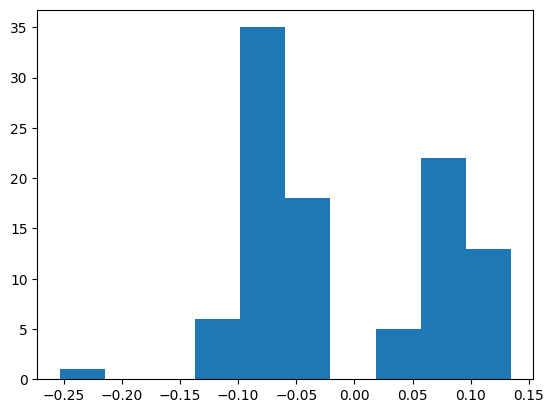

0.061763793
Minimum: -0.25327846
Q1 (First Quartile): -0.07065401489642857
Median: -0.04692448473809524
Q3 (Third Quartile): 0.06695455
Maximum: 0.13443619
True
--------------------------


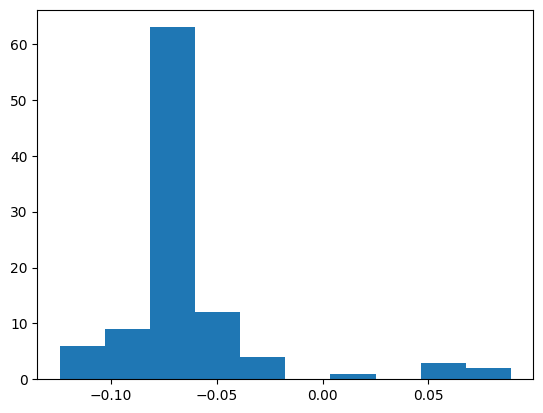

-0.08046553
Minimum: -0.124031425
Q1 (First Quartile): -0.07469901842857143
Median: -0.06845664057112069
Q3 (Third Quartile): -0.060811739263150685
Maximum: 0.08885786
True
--------------------------


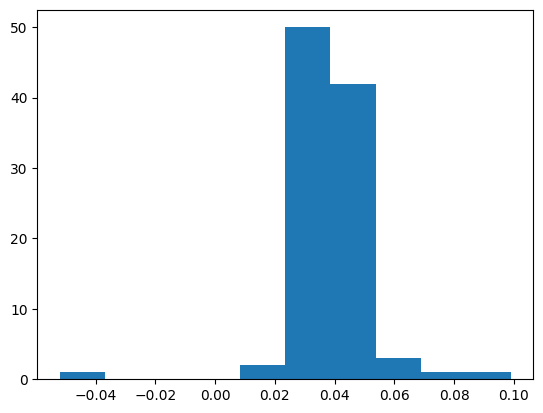

0.049790792
Minimum: -0.05196318
Q1 (First Quartile): 0.03069362149182809
Median: 0.03735713885127254
Q3 (Third Quartile): 0.04702522350746269
Maximum: 0.0990062375
True
--------------------------


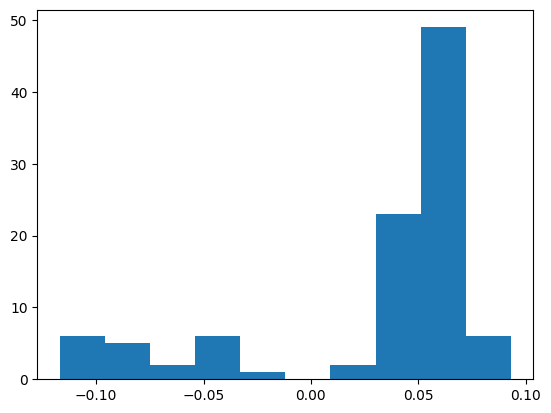

0.05912493
Minimum: -0.116910934
Q1 (First Quartile): 0.03813100975
Median: 0.05254292715
Q3 (Third Quartile): 0.06193226342857144
Maximum: 0.093091115
True
--------------------------


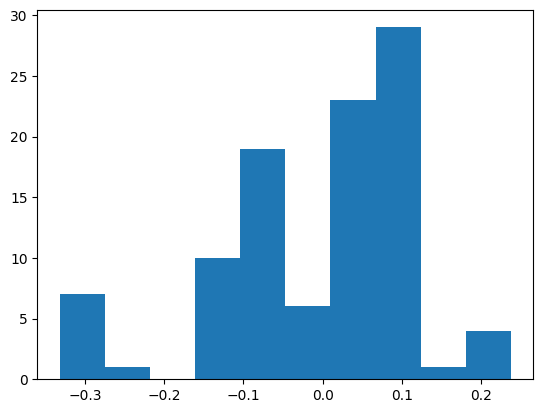

0.07989757
Minimum: -0.33154798
Q1 (First Quartile): -0.08723791965625001
Median: 0.043729043999999995
Q3 (Third Quartile): 0.08642979
Maximum: 0.23745242
True
--------------------------


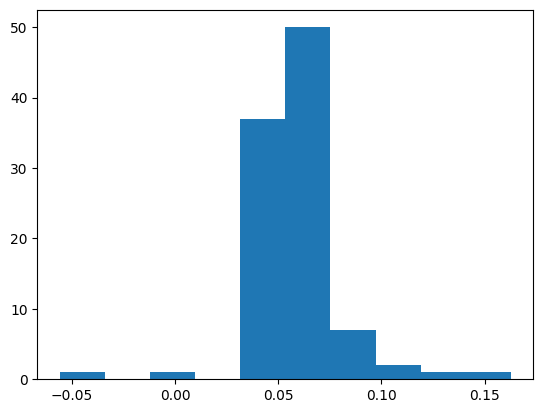

0.04229498
Minimum: -0.055760592
Q1 (First Quartile): 0.04931210598529411
Median: 0.05858854343731671
Q3 (Third Quartile): 0.06695985095909551
Maximum: 0.16266532
True
--------------------------


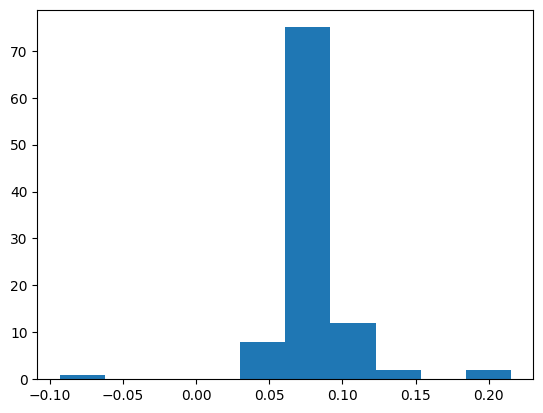

0.08174097
Minimum: -0.09310900933333334
Q1 (First Quartile): 0.06831537150458461
Median: 0.07308132092700981
Q3 (Third Quartile): 0.08350952145851648
Maximum: 0.21515149
True
--------------------------


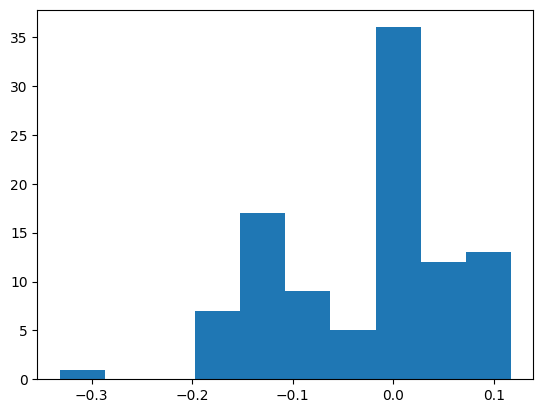

0.03498733
Minimum: -0.33154798
Q1 (First Quartile): -0.10677899375
Median: 0.010466365391666666
Q3 (Third Quartile): 0.026871406352941177
Maximum: 0.11687196
True
--------------------------


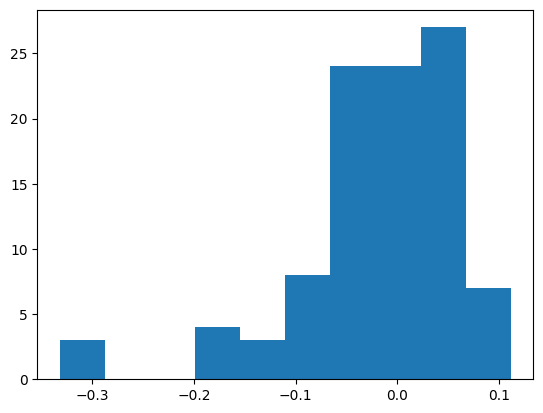

0.035231143
Minimum: -0.33154798
Q1 (First Quartile): -0.04177727
Median: -0.00034137579576507145
Q3 (Third Quartile): 0.043015927
Maximum: 0.11129703992757893
True
--------------------------


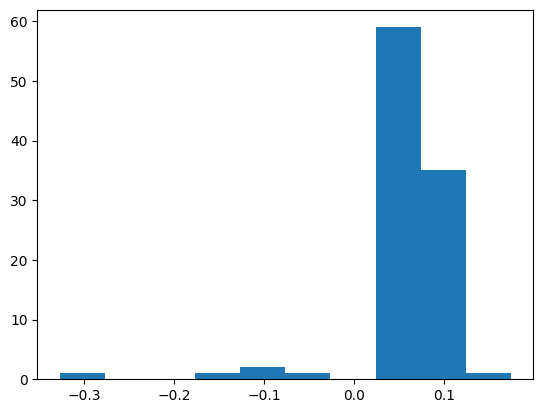

0.0808393
Minimum: -0.327262
Q1 (First Quartile): 0.06362533272470144
Median: 0.07076090468442447
Q3 (Third Quartile): 0.07717775227005347
Maximum: 0.17377096
True
--------------------------


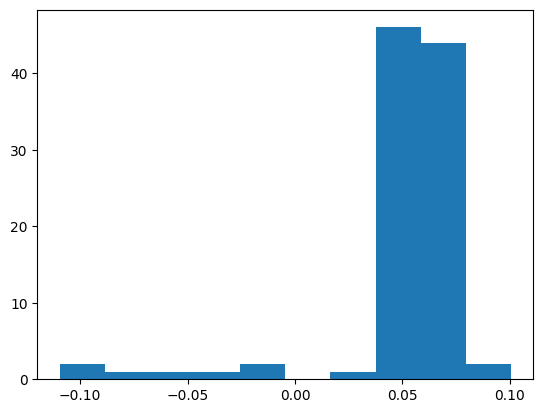

0.04535541
Minimum: -0.109443784
Q1 (First Quartile): 0.04782334195190714
Median: 0.05786055746385442
Q3 (Third Quartile): 0.06400123540860597
Maximum: 0.10046448
True
--------------------------


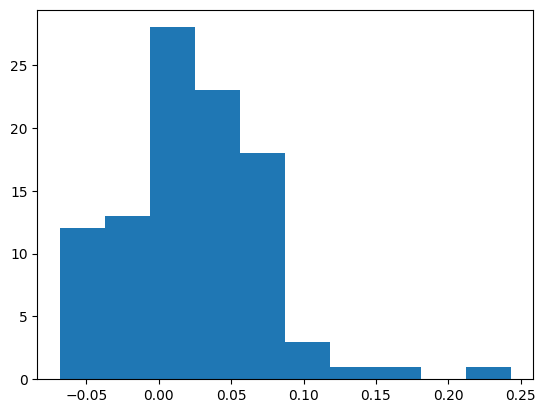

0.04805334
Minimum: -0.06817980555555556
Q1 (First Quartile): -0.0057331724575
Median: 0.021227048880000002
Q3 (Third Quartile): 0.056300133
Maximum: 0.24306695
True
--------------------------


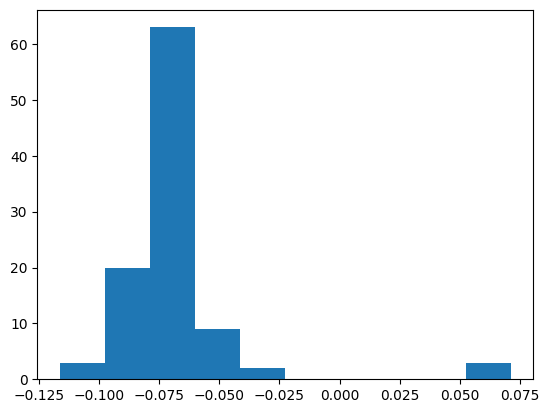

0.05631882
Minimum: -0.116287788375
Q1 (First Quartile): -0.07671459841484268
Median: -0.07075830500713012
Q3 (Third Quartile): -0.06408115427941176
Maximum: 0.07119113
True
--------------------------


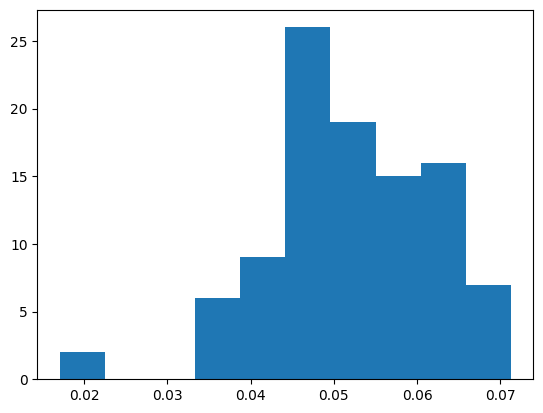

0.04540029
Minimum: 0.0170960637
Q1 (First Quartile): 0.046746498206285125
Median: 0.051731928004431105
Q3 (Third Quartile): 0.05987624511806283
Maximum: 0.0712510600078125
True
--------------------------


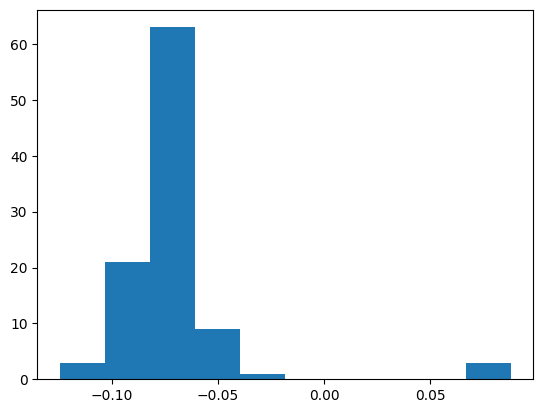

-0.06303653
Minimum: -0.124439314
Q1 (First Quartile): -0.08115096118347953
Median: -0.07216552264770443
Q3 (Third Quartile): -0.06541509587180294
Maximum: 0.08799088
True
--------------------------


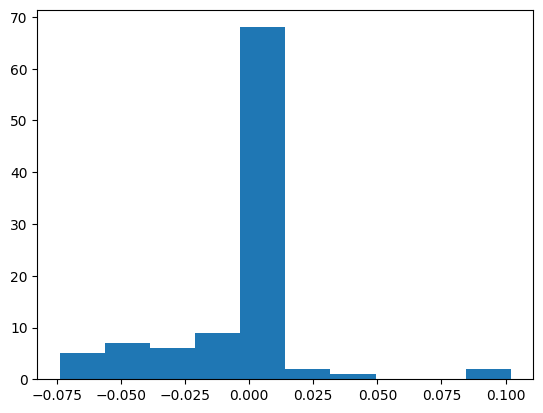

-0.001749645
Minimum: -0.07376488
Q1 (First Quartile): -0.01410334579625
Median: 0.0025870802749370283
Q3 (Third Quartile): 0.008756069947058824
Maximum: 0.10203278
True
--------------------------


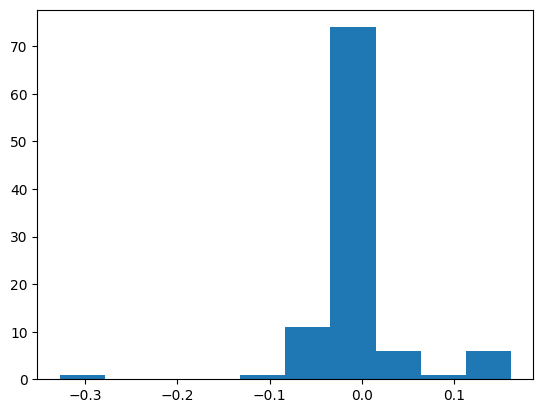

-0.01857027
Minimum: -0.327262
Q1 (First Quartile): -0.021876026
Median: -0.009565639014285714
Q3 (Third Quartile): -0.00019883423075
Maximum: 0.1610451
True
--------------------------


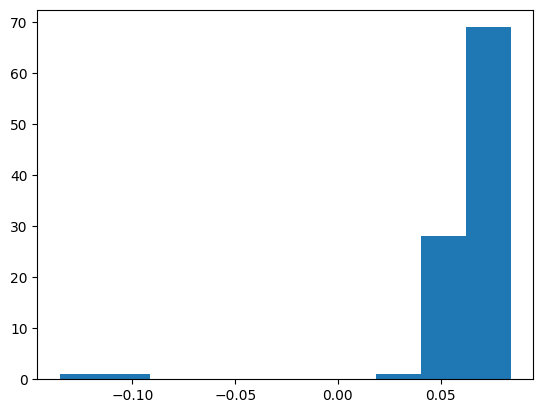

0.065908164
Minimum: -0.13534091899999998
Q1 (First Quartile): 0.06123445385159708
Median: 0.06613345182198763
Q3 (Third Quartile): 0.07134346241119448
Maximum: 0.08420140982786886
True
--------------------------


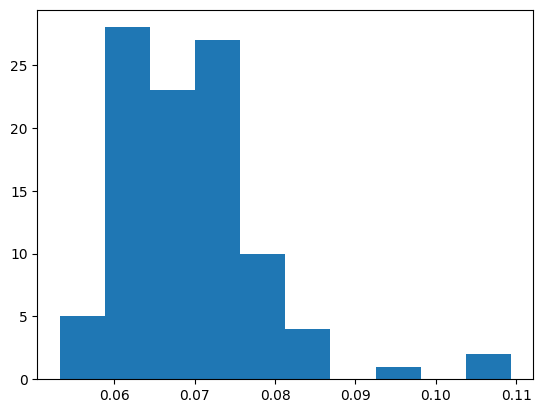

0.046868175
Minimum: 0.05327008867010305
Q1 (First Quartile): 0.06324219912320926
Median: 0.06894675577162249
Q3 (Third Quartile): 0.07278119920644327
Maximum: 0.109298012
False
--------------------------


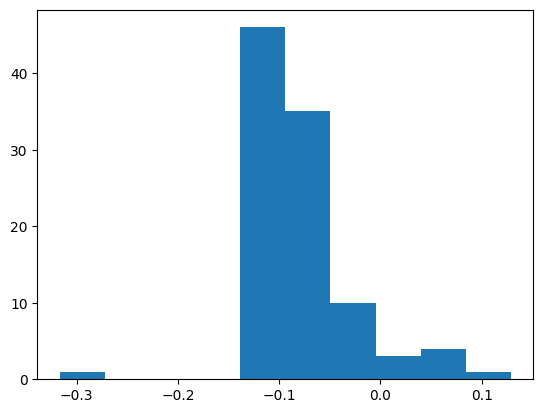

-0.14105463
Minimum: -0.31655174
Q1 (First Quartile): -0.11046974
Median: -0.08916362788571429
Q3 (Third Quartile): -0.06489319811034801
Maximum: 0.12866214
True
--------------------------


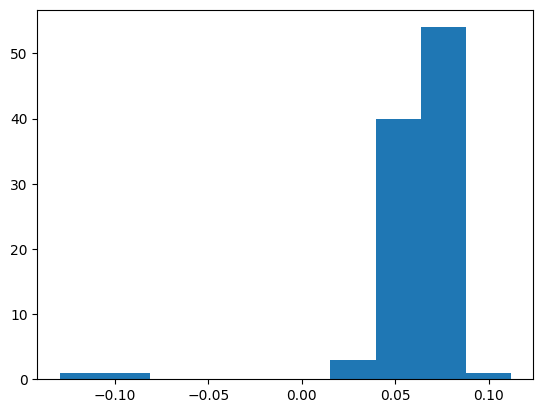

0.07924642
Minimum: -0.12928255
Q1 (First Quartile): 0.05958839058855799
Median: 0.06457900611244219
Q3 (Third Quartile): 0.07074933532283238
Maximum: 0.111742504
True
--------------------------


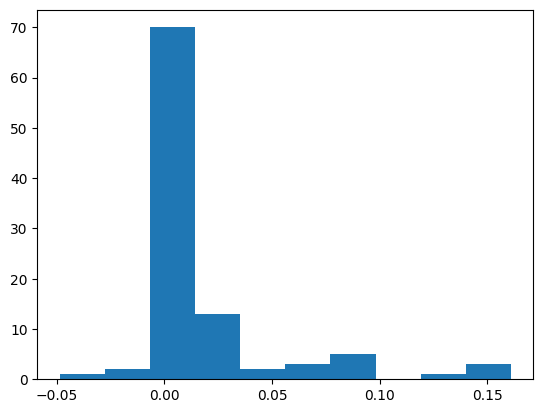

6.44064e-05
Minimum: -0.048618063
Q1 (First Quartile): 0.00010778603837643098
Median: 0.0016251240215807692
Q3 (Third Quartile): 0.01650806714670947
Maximum: 0.1610451
True
--------------------------


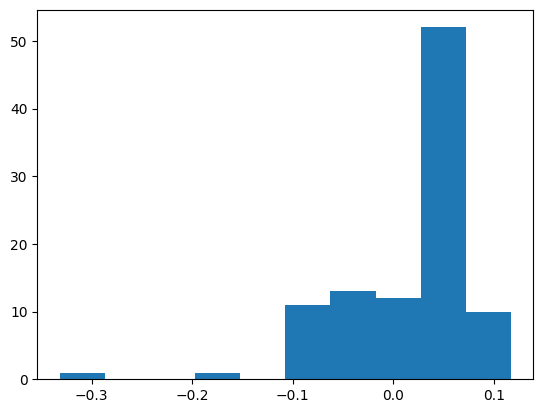

0.038603976
Minimum: -0.33154798
Q1 (First Quartile): -0.02439343325
Median: 0.04873293373333334
Q3 (Third Quartile): 0.06301193358333333
Maximum: 0.11687196
True
--------------------------


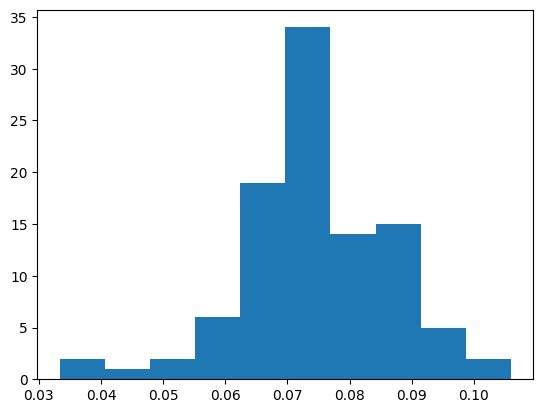

0.10172133
Minimum: 0.03338235394348388
Q1 (First Quartile): 0.06852649130054565
Median: 0.07308132092700981
Q3 (Third Quartile): 0.0827678631007085
Maximum: 0.10592943361403508
True
--------------------------


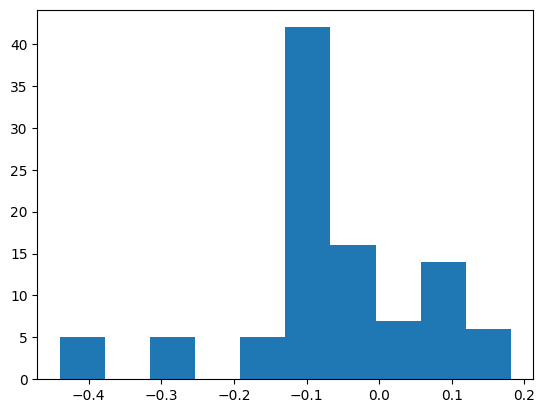

-0.20486325
Minimum: -0.4397846
Q1 (First Quartile): -0.1130965224
Median: -0.07425130692187501
Q3 (Third Quartile): 0.023877919
Maximum: 0.18125486
True
--------------------------


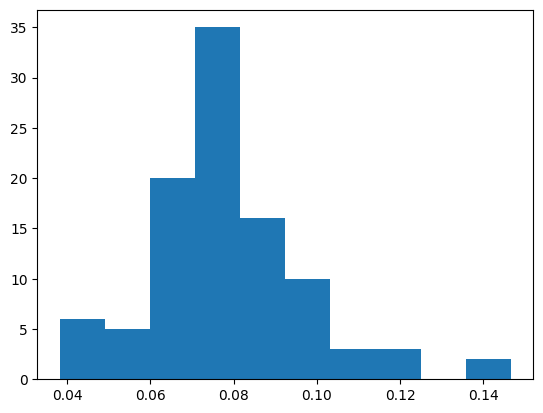

0.079742596
Minimum: 0.03823203929881864
Q1 (First Quartile): 0.06918248599194227
Median: 0.0765552376897163
Q3 (Third Quartile): 0.08684099374667553
Maximum: 0.14657077708333333
True
--------------------------


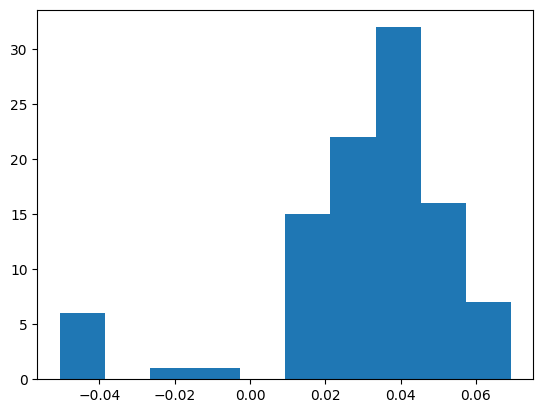

0.025368921
Minimum: -0.05045920825
Q1 (First Quartile): 0.024818040744381945
Median: 0.035523752921568626
Q3 (Third Quartile): 0.043897482783027963
Maximum: 0.069248125
True
--------------------------


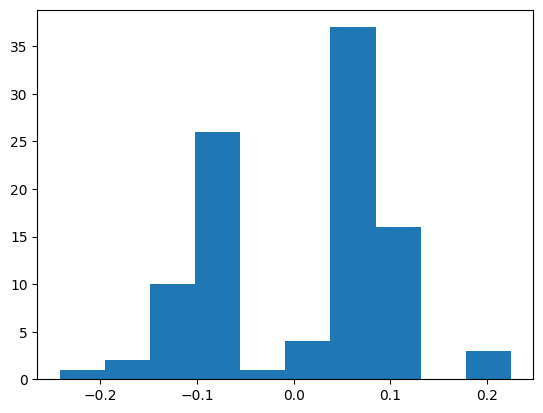

-0.105722606
Minimum: -0.24160579
Q1 (First Quartile): -0.0833617525
Median: 0.051093703500000004
Q3 (Third Quartile): 0.0772929304621212
Maximum: 0.22448586
True
--------------------------


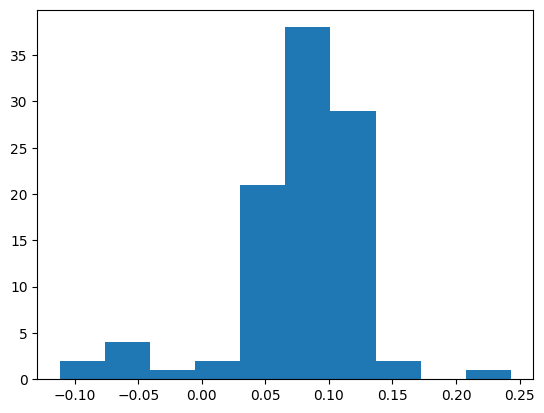

0.05541924
Minimum: -0.11157219
Q1 (First Quartile): 0.056300133
Median: 0.06696029
Q3 (Third Quartile): 0.12871453
Maximum: 0.24306695
True
--------------------------


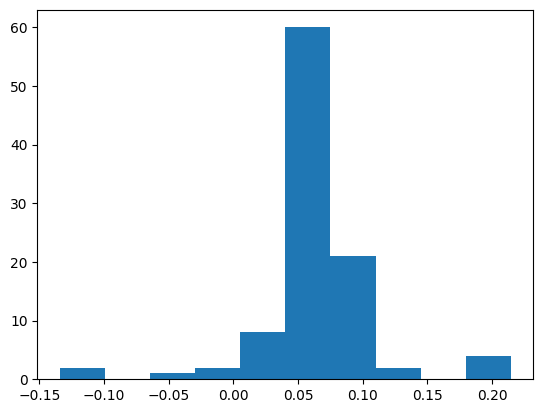

0.09106466
Minimum: -0.13420787
Q1 (First Quartile): 0.049369358
Median: 0.0633379428
Q3 (Third Quartile): 0.0763159554005682
Maximum: 0.21448883
True
--------------------------


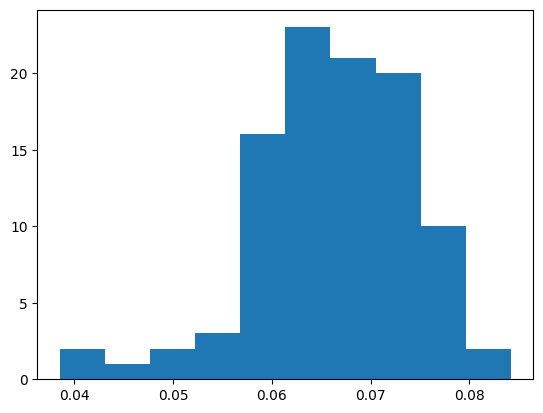

0.06036815
Minimum: 0.03853214700877192
Q1 (First Quartile): 0.06195578852177068
Median: 0.06642785225001548
Q3 (Third Quartile): 0.07152872034006885
Maximum: 0.08420140982786886
True
--------------------------


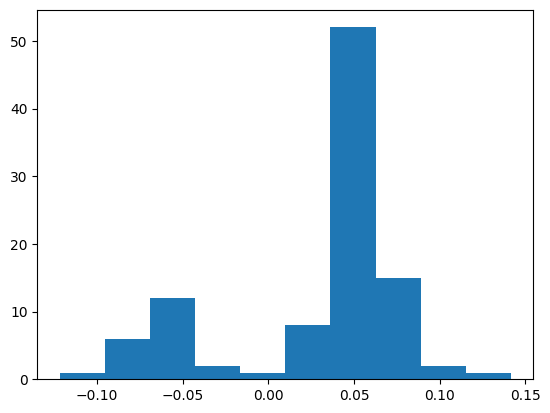

0.050679997
Minimum: -0.12176117022222223
Q1 (First Quartile): 0.03419359302970143
Median: 0.053199336
Q3 (Third Quartile): 0.060444875091379316
Maximum: 0.14148808
True
--------------------------


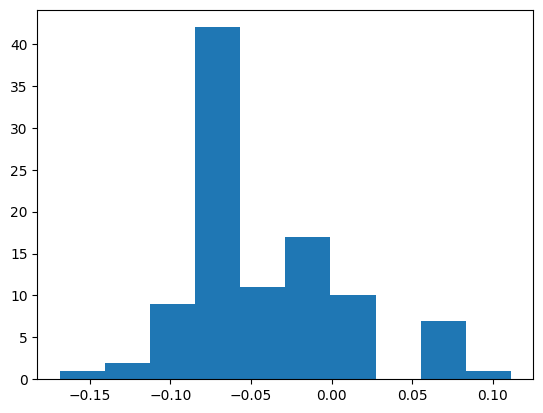

-0.10449427
Minimum: -0.16863105
Q1 (First Quartile): -0.07324053725781252
Median: -0.061184304236301376
Q3 (Third Quartile): -0.009632155195833334
Maximum: 0.11125433
True
--------------------------


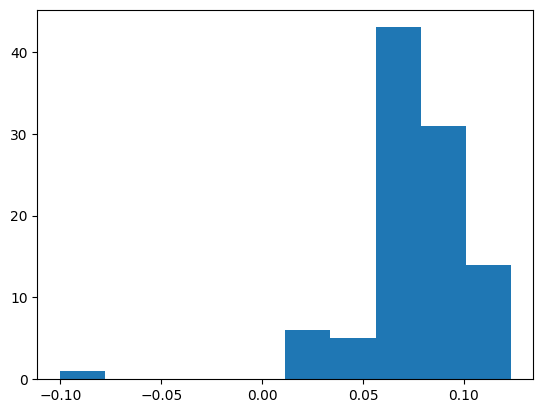

0.07750209
Minimum: -0.10029603733333335
Q1 (First Quartile): 0.06771497381944444
Median: 0.07703888278030302
Q3 (Third Quartile): 0.09217086512989983
Maximum: 0.1232343562083333
True
--------------------------


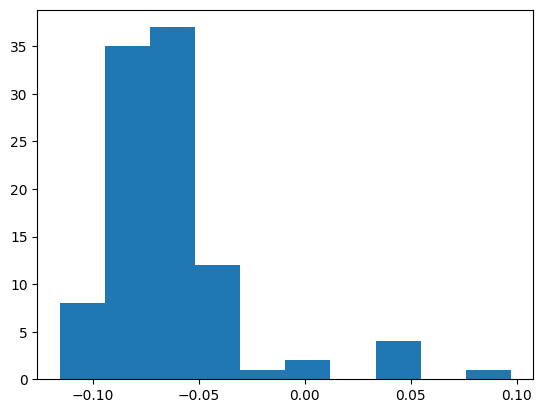

-0.034416385
Minimum: -0.11553908333333333
Q1 (First Quartile): -0.08002998446428572
Median: -0.0674108740806383
Q3 (Third Quartile): -0.05506475525
Maximum: 0.09709264
True
--------------------------


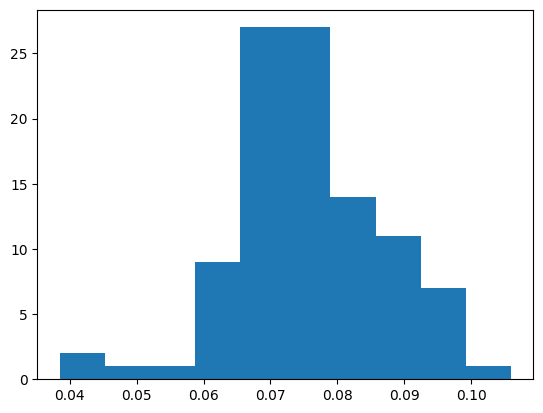

0.08791569
Minimum: 0.03853214700877192
Q1 (First Quartile): 0.06979338116512297
Median: 0.0743023930885254
Q3 (Third Quartile): 0.0827678631007085
Maximum: 0.10592943361403508
True
--------------------------


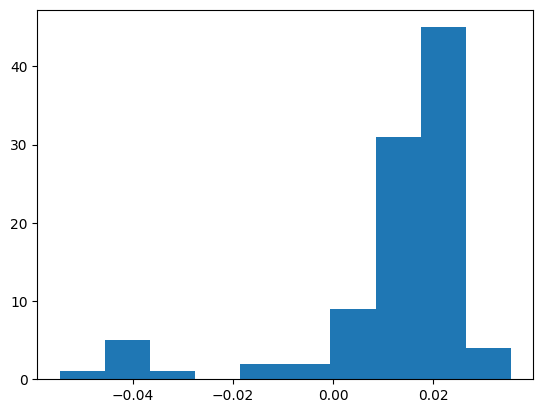

0.010571033
Minimum: -0.054602765
Q1 (First Quartile): 0.012278141829945799
Median: 0.01719154798489011
Q3 (Third Quartile): 0.019221065922675522
Maximum: 0.0354770431519084
True
--------------------------


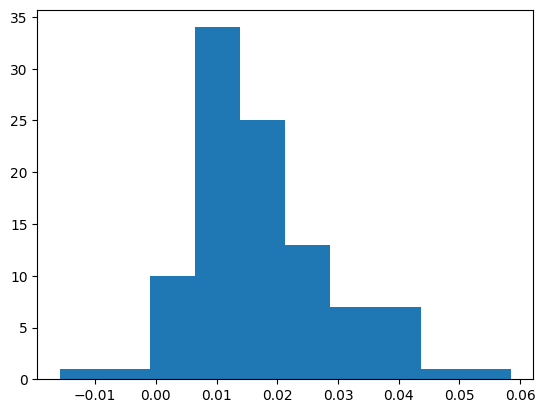

0.010917651
Minimum: -0.015789483714285714
Q1 (First Quartile): 0.00988811042412878
Median: 0.015327507921428571
Q3 (Third Quartile): 0.02299272879578125
Maximum: 0.05846130333333333
True
--------------------------


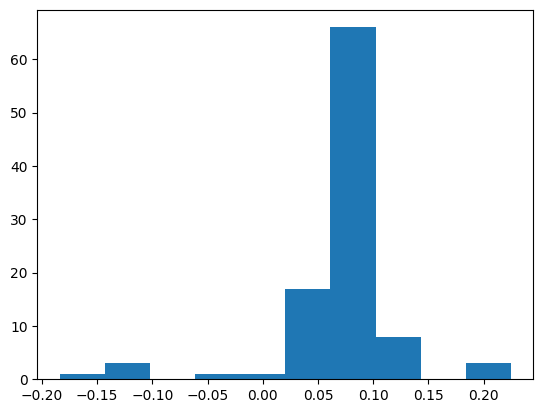

0.09046236
Minimum: -0.18358667
Q1 (First Quartile): 0.0631024708176948
Median: 0.07211334807910641
Q3 (Third Quartile): 0.07990409956582169
Maximum: 0.22448586
True
--------------------------


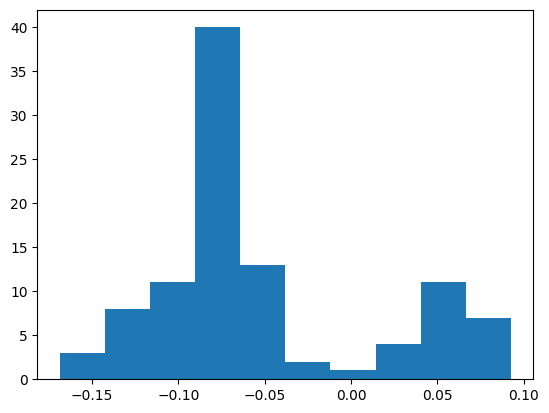

-0.06533389
Minimum: -0.16863105
Q1 (First Quartile): -0.08802855999999999
Median: -0.07374655807142858
Q3 (Third Quartile): -0.0385098622
Maximum: 0.09252605
True
--------------------------


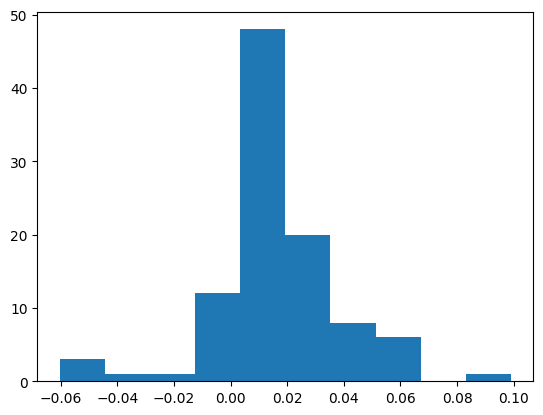

0.012797326
Minimum: -0.060323026599999996
Q1 (First Quartile): 0.007718961142975782
Median: 0.013501462213484848
Q3 (Third Quartile): 0.02546306721987004
Maximum: 0.0990062375
True
--------------------------


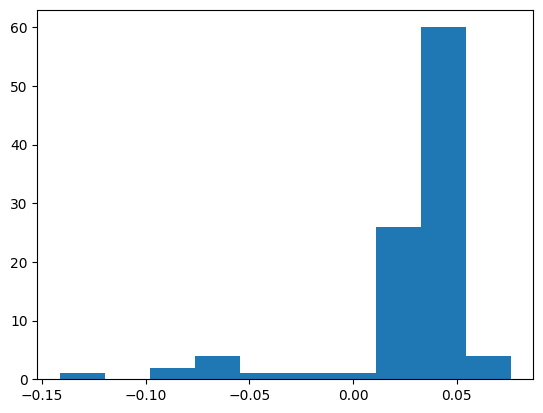

-0.034164548
Minimum: -0.14139342
Q1 (First Quartile): 0.02817478107743226
Median: 0.03588191323074556
Q3 (Third Quartile): 0.04470685483333334
Maximum: 0.0761351867586207
True
--------------------------


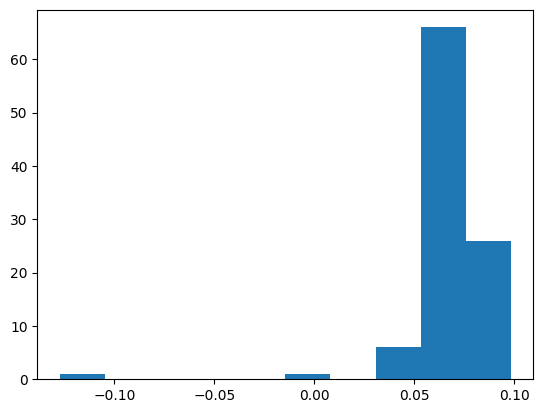

0.06881362
Minimum: -0.127257718
Q1 (First Quartile): 0.06572040155357141
Median: 0.07097914571041476
Q3 (Third Quartile): 0.0759613316194853
Maximum: 0.09828045925
True
--------------------------


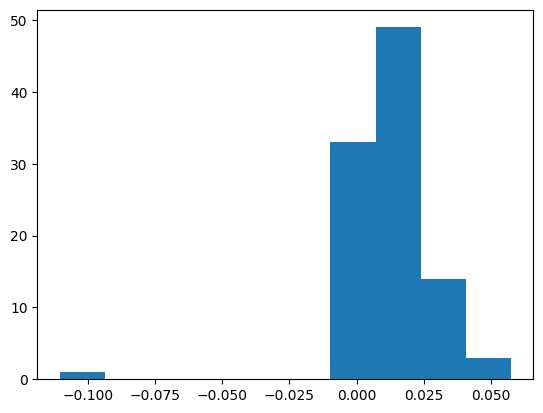

0.0056840526
Minimum: -0.11046974
Q1 (First Quartile): 0.0047820984701625
Median: 0.00938807809825756
Q3 (Third Quartile): 0.017474935651298915
Maximum: 0.057385081219999995
True
--------------------------


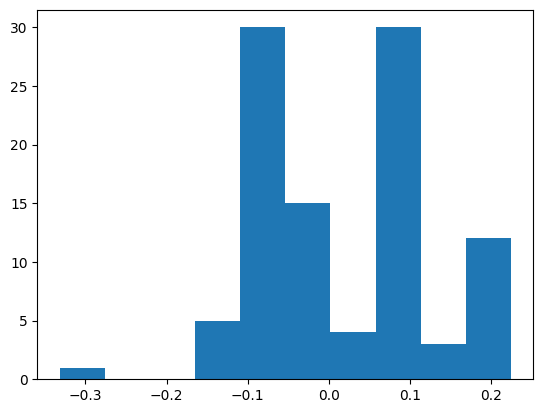

-0.012200006
Minimum: -0.33154798
Q1 (First Quartile): -0.07157197376298702
Median: 0.0005062089365842592
Q3 (Third Quartile): 0.11125433
Maximum: 0.22448586
True
--------------------------


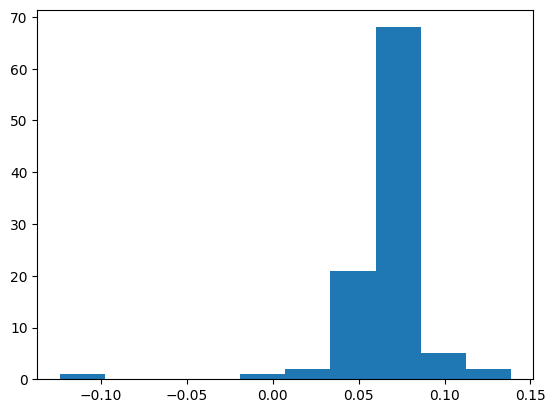

0.0670352
Minimum: -0.124031425
Q1 (First Quartile): 0.05983803774322169
Median: 0.06815390036064427
Q3 (Third Quartile): 0.07323230297257534
Maximum: 0.1386098060526316
True
--------------------------


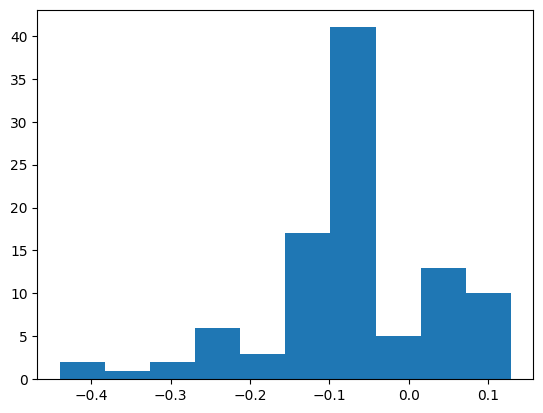

-0.15284134
Minimum: -0.4397846
Q1 (First Quartile): -0.11450041359375
Median: -0.07386347991071429
Q3 (Third Quartile): -0.0017428527
Maximum: 0.12866214
True
--------------------------


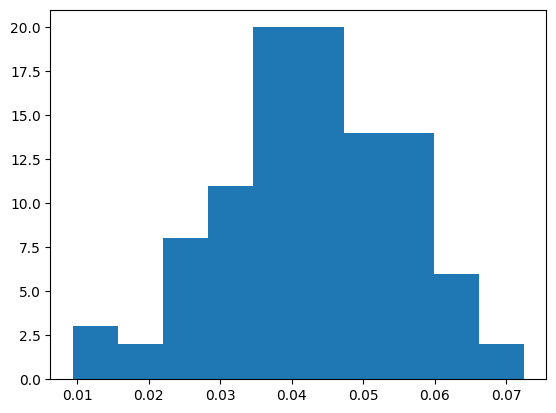

0.041875407
Minimum: 0.009409085823529414
Q1 (First Quartile): 0.0348498513777811
Median: 0.04369584851888342
Q3 (Third Quartile): 0.05155831780232558
Maximum: 0.07244065362303666
True
--------------------------


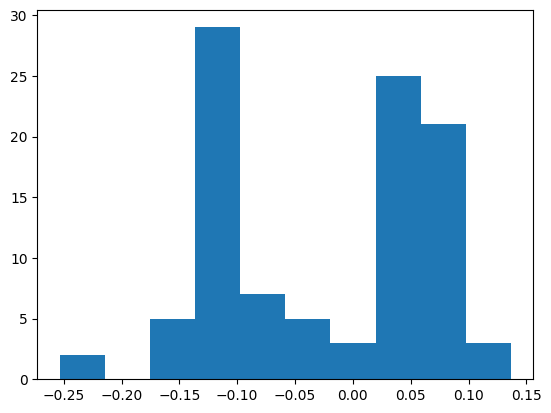

-0.08183709
Minimum: -0.25327846
Q1 (First Quartile): -0.1116808409375
Median: 0.00599478365
Q3 (Third Quartile): 0.058350560340143846
Maximum: 0.1365448
True
--------------------------


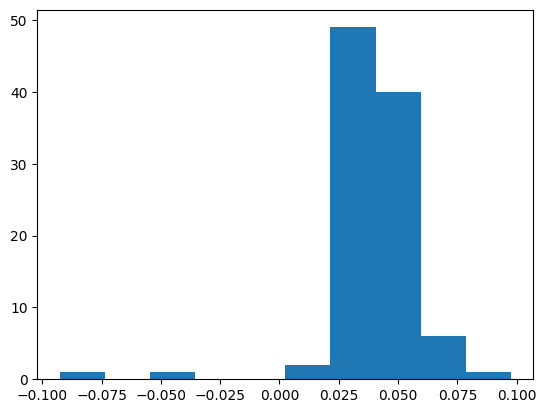

0.035798907
Minimum: -0.09259271
Q1 (First Quartile): 0.03520877952968614
Median: 0.03906628373059361
Q3 (Third Quartile): 0.046574023020939735
Maximum: 0.097540356
True
--------------------------


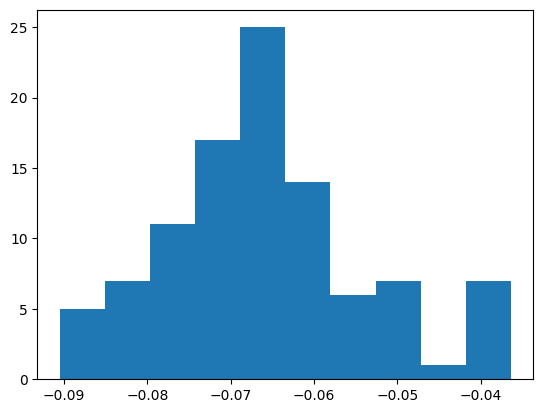

-0.05046153
Minimum: -0.09048
Q1 (First Quartile): -0.07391687828923077
Median: -0.0675766310106383
Q3 (Third Quartile): -0.060624317592105265
Maximum: -0.03639649
True
--------------------------


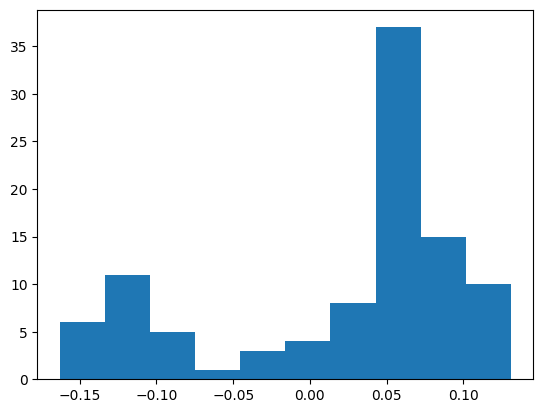

0.058077037
Minimum: -0.16292104
Q1 (First Quartile): -0.01983279585
Median: 0.0533585785997574
Q3 (Third Quartile): 0.07201989700640427
Maximum: 0.130901213875
True
--------------------------


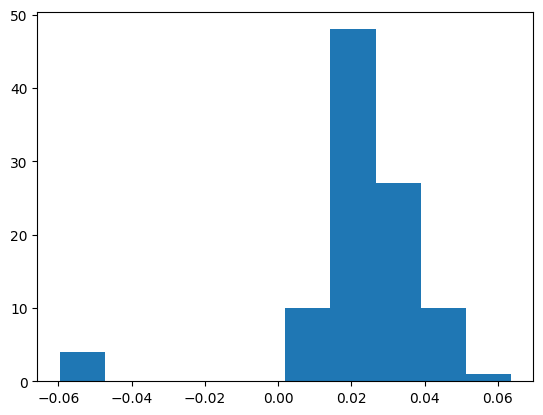

0.016141325
Minimum: -0.059569534
Q1 (First Quartile): 0.01725493478466599
Median: 0.023137080928571425
Q3 (Third Quartile): 0.03278871047424242
Maximum: 0.06352538605555555
True
--------------------------


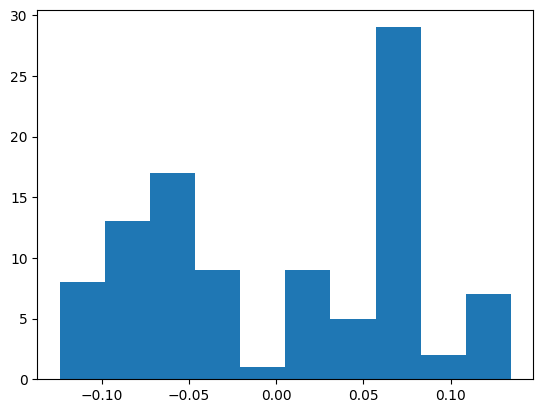

0.06793174
Minimum: -0.12388265
Q1 (First Quartile): -0.067228541505
Median: 0.011826638
Q3 (Third Quartile): 0.06695455
Maximum: 0.13443619
True
--------------------------


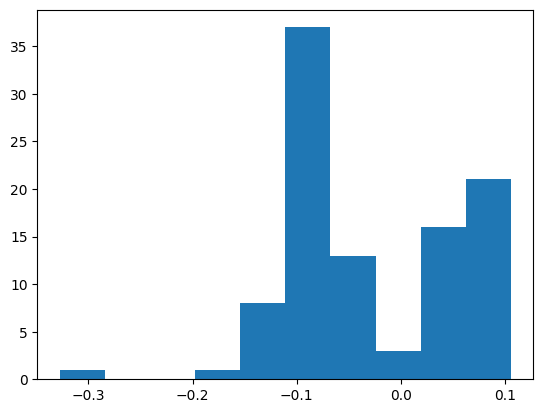

-0.071823195
Minimum: -0.327262
Q1 (First Quartile): -0.08977960855714287
Median: -0.06285951698148148
Q3 (Third Quartile): 0.05418402205113636
Maximum: 0.105225146
True
--------------------------


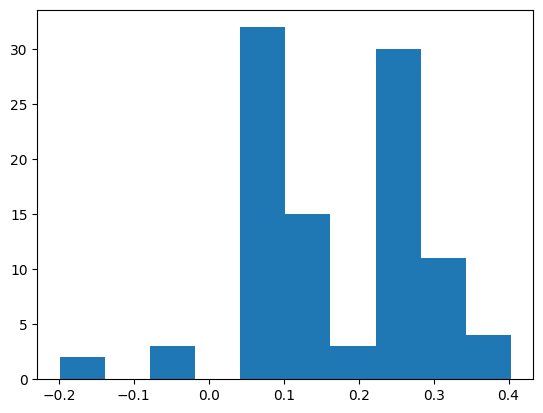

0.13681778
Minimum: -0.19866286
Q1 (First Quartile): 0.08623573
Median: 0.14720443892857143
Q3 (Third Quartile): 0.24306695
Maximum: 0.40301746
True
--------------------------


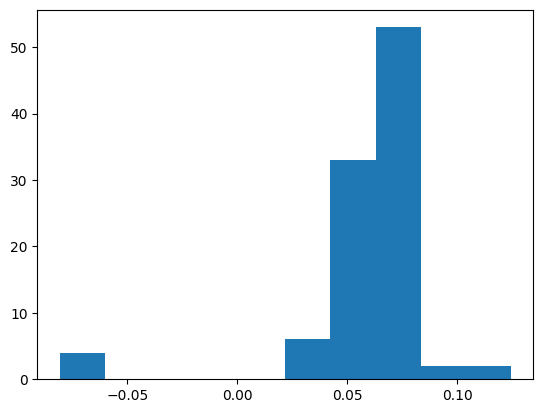

0.06267117
Minimum: -0.08071515339999999
Q1 (First Quartile): 0.05575208713611482
Median: 0.06497774105635243
Q3 (Third Quartile): 0.07223339470948617
Maximum: 0.12443945166666666
True
--------------------------


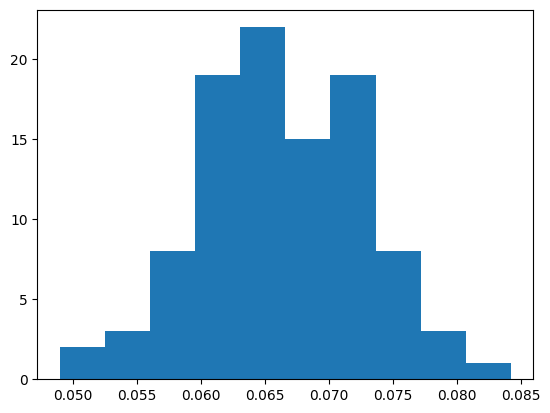

0.060105532
Minimum: 0.04896235586178863
Q1 (First Quartile): 0.0612572598990953
Median: 0.0661685072403626
Q3 (Third Quartile): 0.07108917181195312
Maximum: 0.08420140982786886
True
--------------------------


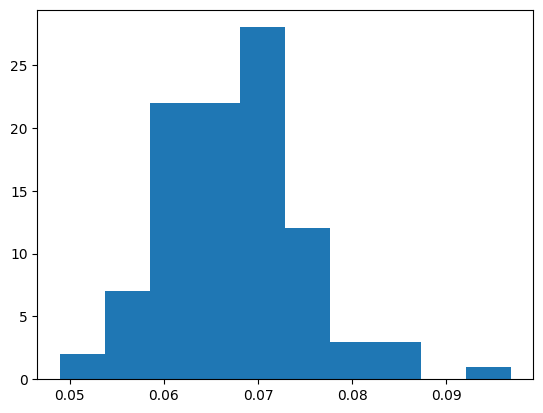

0.07100639
Minimum: 0.04896235586178863
Q1 (First Quartile): 0.06191593109772521
Median: 0.06768410730266106
Q3 (Third Quartile): 0.07209907453391386
Maximum: 0.0968389329272727
True
--------------------------


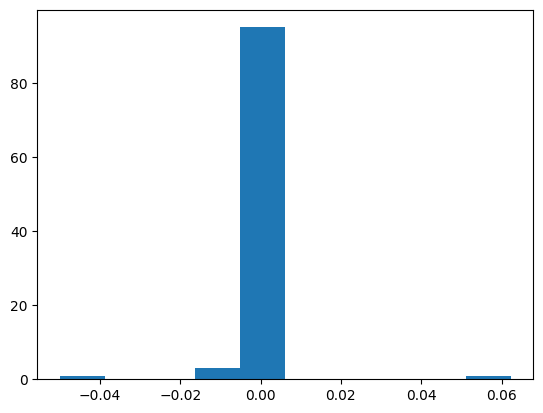

-0.006122068
Minimum: -0.04994297
Q1 (First Quartile): -0.00045582640249999996
Median: -0.00013433418775
Q3 (Third Quartile): 0.0002257556408029891
Maximum: 0.06229532
True
--------------------------


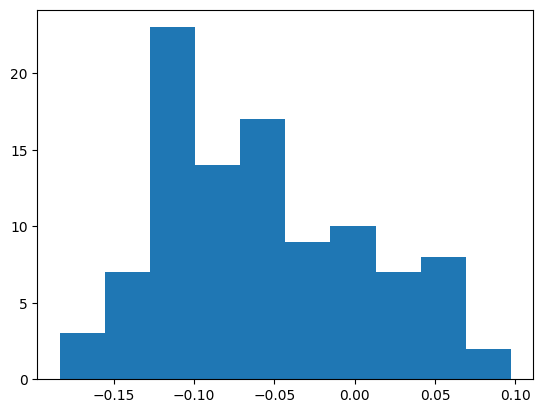

-0.015846092
Minimum: -0.18358667
Q1 (First Quartile): -0.1118958925
Median: -0.06401081189999999
Q3 (Third Quartile): -0.010255202175
Maximum: 0.09709264
True
--------------------------


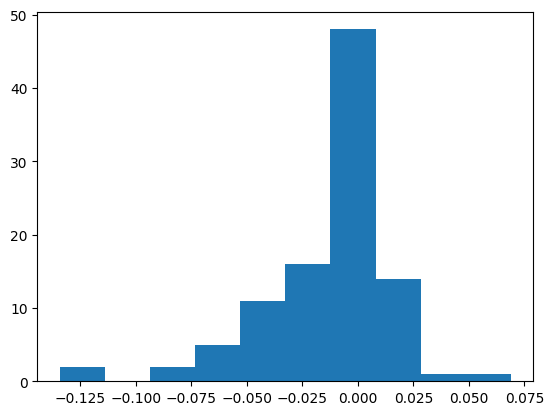

-0.019651374
Minimum: -0.1341429
Q1 (First Quartile): -0.02262480097727273
Median: -0.008615032833333335
Q3 (Third Quartile): -6.209796156249998e-05
Maximum: 0.06885569
True
--------------------------


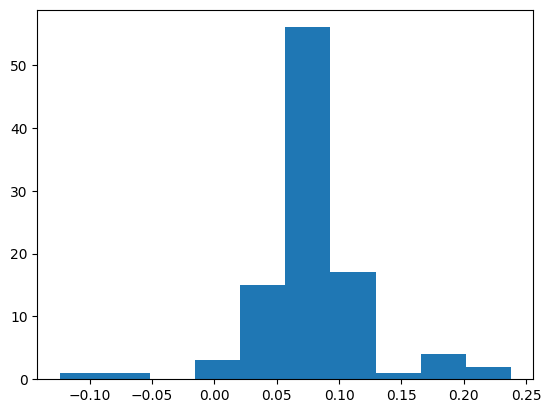

0.107323185
Minimum: -0.12388265
Q1 (First Quartile): 0.06232646243221343
Median: 0.07409990613018749
Q3 (Third Quartile): 0.09217086512989983
Maximum: 0.23775575
True
--------------------------


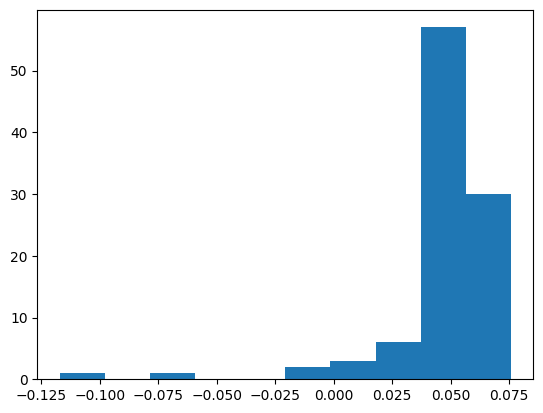

0.0623599
Minimum: -0.11699024
Q1 (First Quartile): 0.0441705634749349
Median: 0.050413125128776375
Q3 (Third Quartile): 0.05799965225182596
Maximum: 0.07563770826315792
True
--------------------------


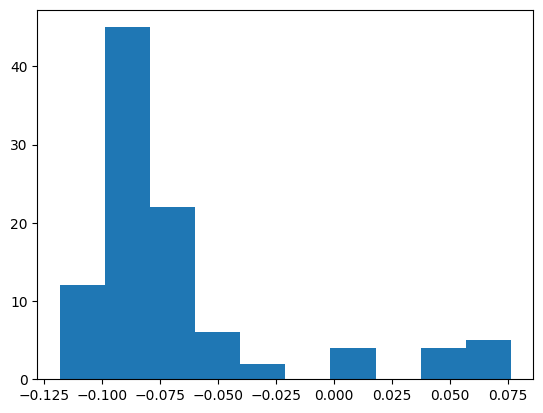

-0.07796012
Minimum: -0.11825669
Q1 (First Quartile): -0.09214297
Median: -0.08083247197777779
Q3 (Third Quartile): -0.06632547893014706
Maximum: 0.0762482
True
--------------------------


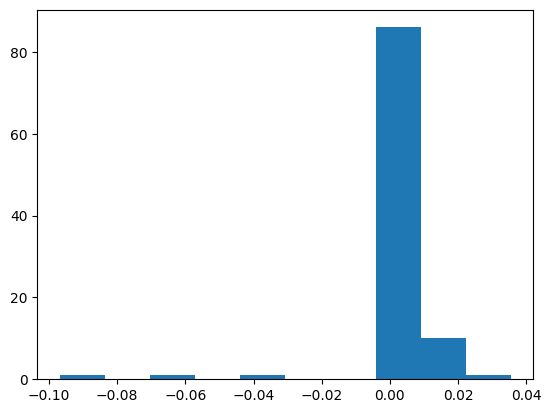

0.0039396286
Minimum: -0.0967976
Q1 (First Quartile): 0.00111133078734875
Median: 0.0032332714718194444
Q3 (Third Quartile): 0.00615761361644385
Maximum: 0.0354770431519084
True
--------------------------


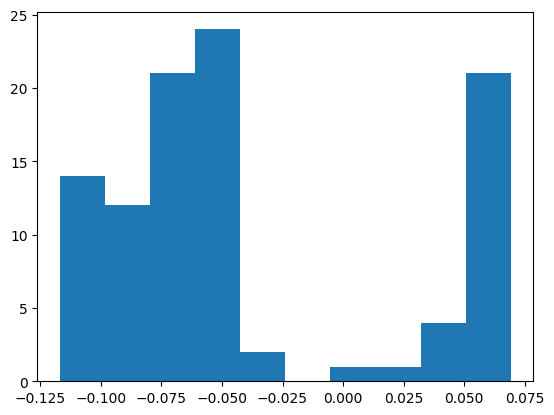

-0.06309685
Minimum: -0.116910934
Q1 (First Quartile): -0.08123795187587413
Median: -0.05929033692261905
Q3 (Third Quartile): 0.02674388476875
Maximum: 0.069248125
True
--------------------------


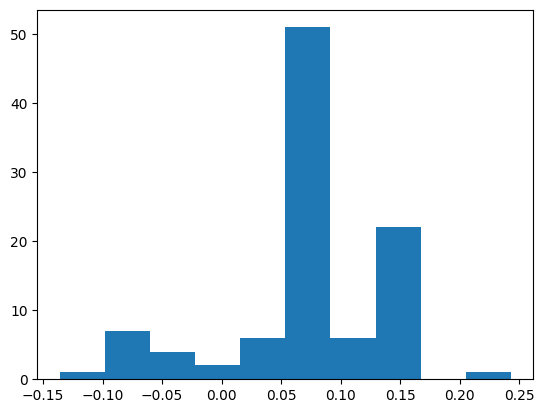

0.052388474
Minimum: -0.13580634
Q1 (First Quartile): 0.056300133
Median: 0.06695455
Q3 (Third Quartile): 0.12871453
Maximum: 0.24306695
True
--------------------------


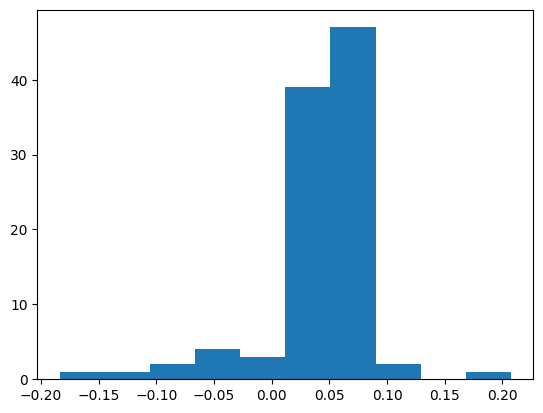

0.05137042
Minimum: -0.18358667
Q1 (First Quartile): 0.03319391930681818
Median: 0.050790284166666665
Q3 (Third Quartile): 0.06147011415625
Maximum: 0.20719887
True
--------------------------


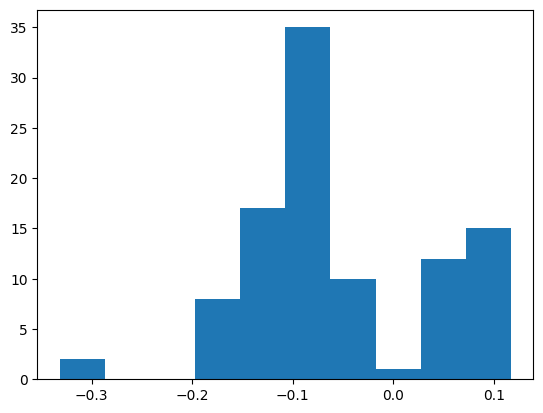

-0.099448845
Minimum: -0.33154798
Q1 (First Quartile): -0.11097666012175325
Median: -0.078572765
Q3 (Third Quartile): 0.044141462904255316
Maximum: 0.11687196
True
--------------------------


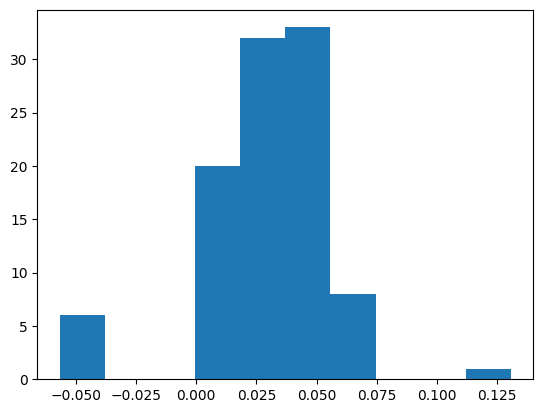

0.024834266
Minimum: -0.056671559999999996
Q1 (First Quartile): 0.01780916815359239
Median: 0.033382061053113546
Q3 (Third Quartile): 0.04469481793582888
Maximum: 0.13072313
True
--------------------------


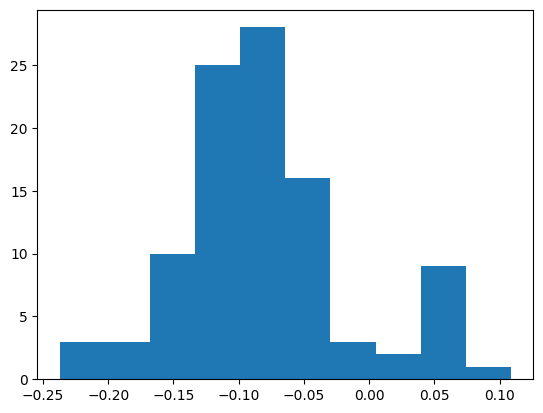

-0.072316006
Minimum: -0.23707876000000003
Q1 (First Quartile): -0.12709976625000002
Median: -0.08913978673214286
Q3 (Third Quartile): -0.061247549694642855
Maximum: 0.10857057
True
--------------------------


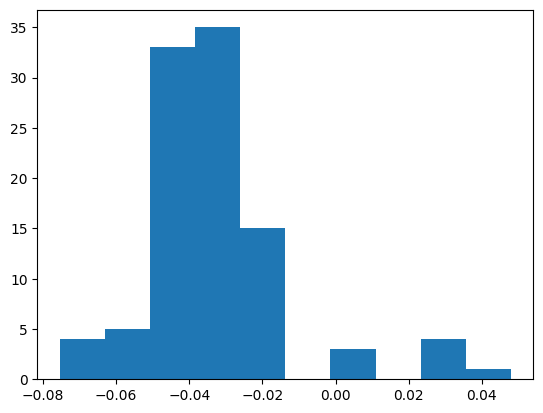

-0.03466904
Minimum: -0.07533902
Q1 (First Quartile): -0.04186676675
Median: -0.035943143
Q3 (Third Quartile): -0.027789768
Maximum: 0.047889034
True
--------------------------


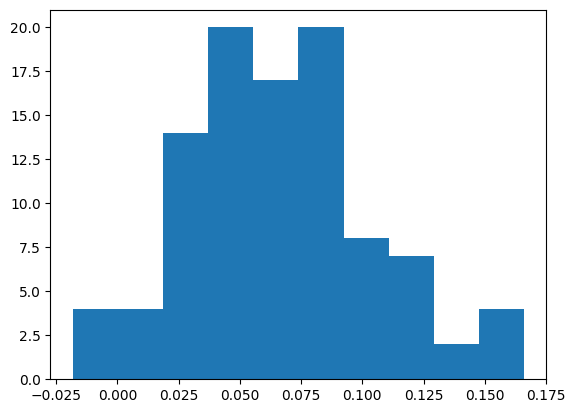

0.07233673
Minimum: -0.01814038
Q1 (First Quartile): 0.038809119669117646
Median: 0.06904332690003358
Q3 (Third Quartile): 0.08529908405099779
Maximum: 0.165960655
True
--------------------------


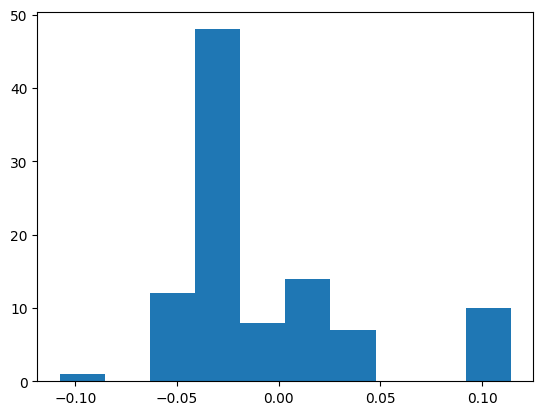

-0.029123506
Minimum: -0.1076018
Q1 (First Quartile): -0.038289443
Median: -0.02198896
Q3 (Third Quartile): 0.01881977
Maximum: 0.11405867
True
--------------------------


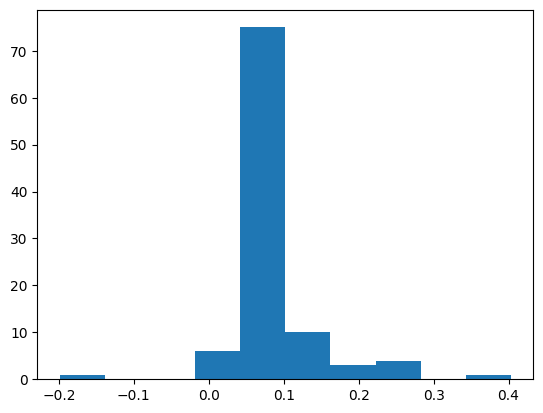

0.05493406
Minimum: -0.19866286
Q1 (First Quartile): 0.0682944695535264
Median: 0.07678382317090396
Q3 (Third Quartile): 0.09119632412989984
Maximum: 0.40301746
True
--------------------------
0.9813664596273292


In [100]:
n = len(y_test)
c=0
upper, lower = [], []
for yhat_100, y in zip(individual_preds.T, y_test):
    plt.hist(yhat_100)
    plt.show()
    minimum = np.min(yhat_100)
    q1 = np.percentile(yhat_100, 25)
    median = np.median(yhat_100)
    q3 = np.percentile(yhat_100, 75)
    maximum = np.max(yhat_100)

    # Output the summary
    print(y)
    print("Minimum:", minimum)
    print("Q1 (First Quartile):", q1)
    print("Median:", median)
    print("Q3 (Third Quartile):", q3)
    print("Maximum:", maximum)
    in_dist = y > minimum and y < maximum
    print(in_dist)
    if in_dist:
        c += 1
    print("--------------------------")
    
print(c / n)    
    
    

<Axes: >

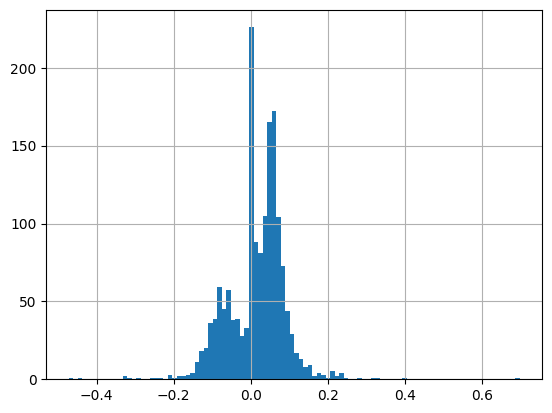

In [102]:
run['wpa_avg'].hist(bins=100)

In [ ]:
plt.plot(y_test, "ro")
plt.fill_between(
    np.arange(len(upper)), lower, upper, alpha=0.2, color="r",
    label="Pred. interval")
plt.xlabel("Ordered samples.")
plt.ylabel("Values and prediction intervals.")
plt.xlim([0, 500])
plt.show()